# Preprocessing of Raw Data

This preprocessing step is important to delete noise, standarize data and guarantee a quality analysis for the single cell RNA sequencing.

#### Import Libraries and data

In [4]:
pip install scanpy anndata scrublet matplotlib seaborn numpy pandas scipy scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [7]:
import scanpy as sc
import anndata as ad
# import scrublet as scr
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.decomposition import PCA
from IPython.core.display import display, HTML
import os, json, sys, re


C:\Users\henry\AppData\Local\Temp\ipykernel_21204\3441369323.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


#### Data Load

In [8]:
data_path = "C:/Users/henry/Desktop/python/jbook_rna/datos/Single-cell RNASeq data from Mouse Brain"
data_path2 = "C:/Users/henry/Desktop/python/jbook_rna/datos/Theory - Intro to single-cell RNAseq Images"

In [23]:
glioblastoma_norm_file = os.path.join(data_path, "glioblastoma_normalized.h5ad")
glioblastoma_raw_file = os.path.join(data_path, "glioblastoma_raw.h5ad")
pbmc3k_file = os.path.join(data_path, "pbmc3k.h5ad")

adata_glioblastoma_norm = sc.read_h5ad(glioblastoma_norm_file)
adata_glioblastoma_raw = sc.read_h5ad(glioblastoma_raw_file)
adata_pbmc3k = sc.read_h5ad(pbmc3k_file)

c:\Users\henry\miniconda3\envs\ml_venv\lib\site-packages\anndata\compat\__init__.py:311: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
c:\Users\henry\miniconda3\envs\ml_venv\lib\site-packages\anndata\compat\__init__.py:311: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


## **Quality Control (QC)**

In [10]:
print(adata_glioblastoma_raw)


AnnData object with n_obs × n_vars = 1853 × 7683
    obs: 'disease_state', 'plate_id', 'tissue', 'patient_id', 'cell_type', 'neoplastic_state', 'diagnosis'


In [11]:
print(f'The data contains the following cells and gene count: \nNumber of cells: {adata_glioblastoma_raw.n_obs}')
print(f'Number of genes: {adata_glioblastoma_raw.n_vars}')

The data contains the following cells and gene count: 
Number of cells: 1853
Number of genes: 7683


### Quality control metrics

#### 📌 Quality Control (QC) Metrics in scRNA-seq

1️⃣ **Number of Cells Expressing Each Gene (`gene_counts`)**
- Measures how **widely expressed** each gene is across cells.  
- Genes expressed in **very few cells** may be **technical noise**.  
- Helps decide **which genes to keep** in downstream analysis.  

2️⃣ **Number of Detected Genes per Cell (`n_genes_by_cell`)**
- Indicates the **complexity** of RNA content in each cell.  
- **Low values** suggest dead cells or empty droplets.  
- **High values** may indicate doublets (two cells captured together).  

3️⃣ **Total UMI Counts per Cell (`total_UMI_counts`)**
- Represents the **sequencing depth** per cell.  
- **Low counts** suggest poor RNA capture or damaged cells.  
- **High counts** can indicate doublets or highly active cells.  

🔍 **These metrics help identify low-quality cells before filtering.**


In [24]:
adata_glioblastoma_raw.var['gene_count'] = np.array((adata_glioblastoma_raw.X > 0).sum(axis=0)).flatten()
adata_glioblastoma_raw.obs['n_genes_by_cell'] = (adata_glioblastoma_raw.X > 0).sum(axis=1)
adata_glioblastoma_raw.obs['total_UMI_counts'] = adata_glioblastoma_raw.X.sum(axis=1)

gene level metrics

In [17]:
adata_glioblastoma_raw.var[["gene_count"]].head()  # Show first 5 genes


,gene_count
index,
ENSG00000000005,2
ENSG00000001561,245
ENSG00000001629,715
ENSG00000002587,1268
ENSG00000002933,548


cell level metrics

In [14]:
adata_glioblastoma_raw.obs[["n_genes_by_cell", "total_UMI_counts"]].head()  # Show first 5 cells


,n_genes_by_cell,total_UMI_counts
index,,
GSM2243439,1341,159262.312500
GSM2243444,1456,326321.875000
GSM2243445,1849,196996.859375
GSM2243447,100,90933.562500
GSM2243452,1788,208278.578125


Summary statistics

In [28]:
adata_glioblastoma_raw.obs[["n_genes_by_cell", "total_UMI_counts"]].describe()


,n_genes_by_cell,total_UMI_counts
count,1853.000000,1853.000000
mean,1268.398273,144684.312500
std,378.551631,78055.953125
min,41.000000,48.202415
25%,1054.000000,88120.328125
50%,1271.000000,133640.687500
75%,1512.000000,192708.296875
max,2513.000000,514206.531250


plots

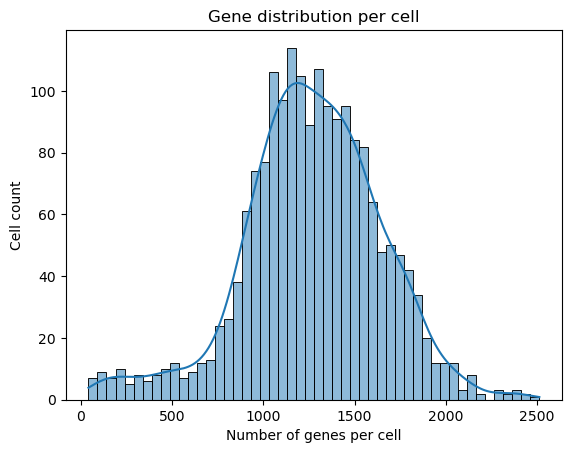

In [32]:
# Plot histogram of number of genes per cell
sns.histplot(adata_glioblastoma_raw.obs['n_genes_by_cell'], bins = 50, kde=True)
plt.xlabel('Number of genes per cell')
plt.ylabel('Cell count')
plt.title('Gene distribution per cell')
plt.show()

### 🧬 Unique Molecular Identifiers (UMIs)

#### What is a UMI?
A **Unique Molecular Identifier (UMI)** is a short **random barcode** added to RNA molecules before sequencing.  
UMIs help correct for **PCR amplification bias** and improve the accuracy of gene expression quantification in single-cell RNA sequencing (**scRNA-seq**).

####  Why Are UMIs Important?
1️⃣ **Reduce PCR Bias** → Prevents artificially inflated gene expression caused by PCR duplicates.  
2️⃣ **Improve Quantification** → Counts only **unique UMIs**, not sequencing reads, for accurate expression levels.  
3️⃣ **Remove Technical Noise** → Helps correct sequencing errors and distinguish true biological signals.  

####  How Are UMIs Used in scRNA-seq?
- **Low UMI counts** → Suggests low RNA content, dead cells, or empty droplets.  
- **High UMI counts** → Could indicate doublets (two cells captured together).  
- **UMI filtering** ensures that only high-quality data is used in downstream analysis.  

 **UMIs improve scRNA-seq accuracy by eliminating technical biases.** 🚀


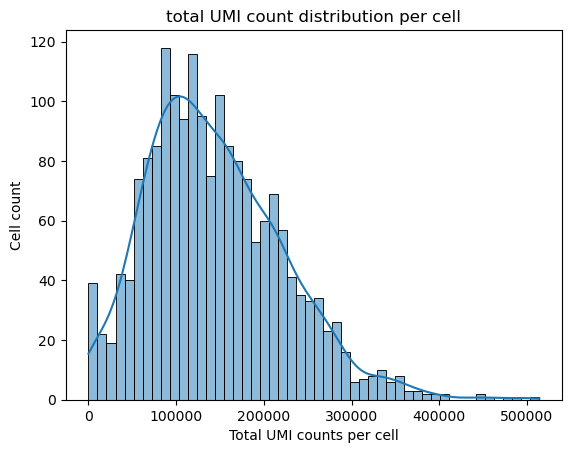

In [33]:
# Plot histogram of total UMI counts per cell
sns.histplot(adata_glioblastoma_raw.obs['total_UMI_counts'], bins = 50, kde=True)
plt.xlabel('Total UMI counts per cell')
plt.ylabel('Cell count')
plt.title('total UMI count distribution per cell')
plt.show()

Violin

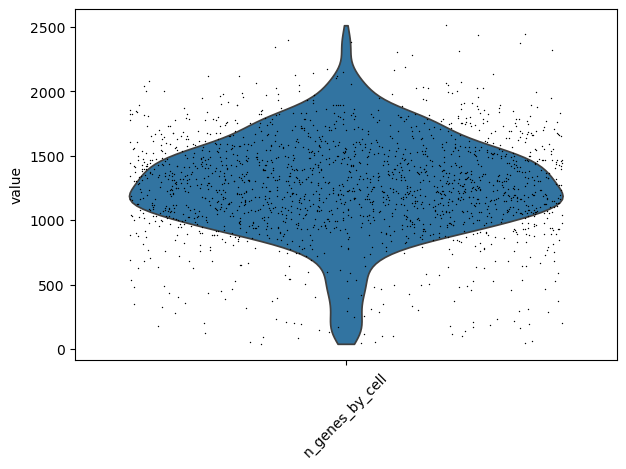

In [34]:
# Violin plot for gene counts per cell
sc.pl.violin(adata_glioblastoma_raw, keys='n_genes_by_cell', jitter=0.4, rotation=45)

## **Cell filtering**

####  Why Do We Filter Cells?

We remove cells that are:  
1️⃣ **Low-quality or dead** → Few detected genes or low UMI counts.  
2️⃣ **Potential doublets** → Abnormally high UMI counts (two cells captured together).  
3️⃣ **Stressed or apoptotic** → High percentage of mitochondrial RNA.  

---

#### 📊 How Do We Define Filtering Thresholds?

We use **three key QC metrics**:  

| **Metric**                      | **Issue Detected**                                     | **Filtering Rule** |
|----------------------------------|------------------------------------------------------|----------------------|
| **Total UMI Counts**             | Low = Empty droplets, debris<br>High = Possible doublets | Keep cells with a **moderate range** of UMI counts |
| **Number of Genes per Cell**     | Low = Dead/low-quality cells<br>High = Doublets     | Set **lower/upper cutoffs** based on distribution |
| **Mitochondrial Gene Percentage** | High = Cell stress, apoptosis                      | Remove cells with **too high mito RNA%** |

In [ ]:
# Print a sample of gene names to manually inspect for mitochondrial genes
print(adata_glioblastoma_raw.var_names.to_list()[:7683])  # Show first 7683 gene names


['ENSG00000000005', 'ENSG00000001561', 'ENSG00000001629', 'ENSG00000002587', 'ENSG00000002933', 'ENSG00000003056', 'ENSG00000003137', 'ENSG00000004478', 'ENSG00000004779', 'ENSG00000004799', 'ENSG00000004848', 'ENSG00000005001', 'ENSG00000005022', 'ENSG00000005073', 'ENSG00000005175', 'ENSG00000005243', 'ENSG00000005381', 'ENSG00000005421', 'ENSG00000005513', 'ENSG00000006059', 'ENSG00000006116', 'ENSG00000006194', 'ENSG00000006210', 'ENSG00000006451', 'ENSG00000006530', 'ENSG00000006606', 'ENSG00000006634', 'ENSG00000006831', 'ENSG00000007306', 'ENSG00000007376', 'ENSG00000007520', 'ENSG00000007968', 'ENSG00000008018', 'ENSG00000008118', 'ENSG00000008197', 'ENSG00000008282', 'ENSG00000008438', 'ENSG00000008988', 'ENSG00000010310', 'ENSG00000010319', 'ENSG00000010610', 'ENSG00000010818', 'ENSG00000011083', 'ENSG00000011198', 'ENSG00000011347', 'ENSG00000011376', 'ENSG00000012232', 'ENSG00000012779', 'ENSG00000012963', 'ENSG00000013275', 'ENSG00000013288', 'ENSG00000013293', 'ENSG000000

In [ ]:
!pip install mygene
import mygene

#### geenrs

In [25]:
mg = mygene.MyGeneInfo()
ensembl_ids = ['ENSG00000000005', 'ENSG00000001561', 'ENSG00000001629', 'ENSG00000002587', 'ENSG00000002933', 'ENSG00000003056', 'ENSG00000003137', 'ENSG00000004478', 'ENSG00000004779', 'ENSG00000004799', 'ENSG00000004848', 'ENSG00000005001', 'ENSG00000005022', 'ENSG00000005073', 'ENSG00000005175', 'ENSG00000005243', 'ENSG00000005381', 'ENSG00000005421', 'ENSG00000005513', 'ENSG00000006059', 'ENSG00000006116', 'ENSG00000006194', 'ENSG00000006210', 'ENSG00000006451', 'ENSG00000006530', 'ENSG00000006606', 'ENSG00000006634', 'ENSG00000006831', 'ENSG00000007306', 'ENSG00000007376', 'ENSG00000007520', 'ENSG00000007968', 'ENSG00000008018', 'ENSG00000008118', 'ENSG00000008197', 'ENSG00000008282', 'ENSG00000008438', 'ENSG00000008988', 'ENSG00000010310', 'ENSG00000010319', 'ENSG00000010610', 'ENSG00000010818', 'ENSG00000011083', 'ENSG00000011198', 'ENSG00000011347', 'ENSG00000011376', 'ENSG00000012232', 'ENSG00000012779', 'ENSG00000012963', 'ENSG00000013275', 'ENSG00000013288', 'ENSG00000013293', 'ENSG00000013392', 'ENSG00000013503', 'ENSG00000013523', 'ENSG00000013583', 'ENSG00000013588', 'ENSG00000014123', 'ENSG00000014138', 'ENSG00000014164', 'ENSG00000015413', 'ENSG00000015479', 'ENSG00000015532', 'ENSG00000016602', 'ENSG00000019186', 'ENSG00000019505', 'ENSG00000019549', 'ENSG00000019995', 'ENSG00000022556', 'ENSG00000022567', 'ENSG00000023191', 'ENSG00000023318', 'ENSG00000023516', 'ENSG00000023572', 'ENSG00000023608', 'ENSG00000023909', 'ENSG00000025772', 'ENSG00000027001', 'ENSG00000027644', 'ENSG00000028839', 'ENSG00000029559', 'ENSG00000031691', 'ENSG00000033050', 'ENSG00000034053', 'ENSG00000034510', 'ENSG00000034713', 'ENSG00000035141', 'ENSG00000035681', 'ENSG00000035687', 'ENSG00000035720', 'ENSG00000036448', 'ENSG00000036473', 'ENSG00000036530', 'ENSG00000037042', 'ENSG00000037241', 'ENSG00000037965', 'ENSG00000038002', 'ENSG00000038210', 'ENSG00000038295', 'ENSG00000039139', 'ENSG00000039987', 'ENSG00000041353', 'ENSG00000042813', 'ENSG00000043039', 'ENSG00000043591', 'ENSG00000044012', 'ENSG00000044090', 'ENSG00000044574', 'ENSG00000046774', 'ENSG00000047597', 'ENSG00000047662', 'ENSG00000048405', 'ENSG00000048544', 'ENSG00000049249', 'ENSG00000049449', 'ENSG00000049656', 'ENSG00000050344', 'ENSG00000051382', 'ENSG00000051596', 'ENSG00000052850', 'ENSG00000053328', 'ENSG00000053372', 'ENSG00000053438', 'ENSG00000053918', 'ENSG00000054282', 'ENSG00000054392', 'ENSG00000054598', 'ENSG00000054803', 'ENSG00000055813', 'ENSG00000056050', 'ENSG00000056736', 'ENSG00000057468', 'ENSG00000057757', 'ENSG00000058056', 'ENSG00000058262', 'ENSG00000059573', 'ENSG00000059588', 'ENSG00000059758', 'ENSG00000060069', 'ENSG00000060140', 'ENSG00000060558', 'ENSG00000061656', 'ENSG00000061936', 'ENSG00000062725', 'ENSG00000063180', 'ENSG00000063241', 'ENSG00000063515', 'ENSG00000063660', 'ENSG00000064195', 'ENSG00000064199', 'ENSG00000064218', 'ENSG00000064300', 'ENSG00000064726', 'ENSG00000064932', 'ENSG00000065057', 'ENSG00000065308', 'ENSG00000065320', 'ENSG00000065491', 'ENSG00000065518', 'ENSG00000065833', 'ENSG00000065923', 'ENSG00000065970', 'ENSG00000066230', 'ENSG00000066379', 'ENSG00000066422', 'ENSG00000066557', 'ENSG00000066777', 'ENSG00000067167', 'ENSG00000067182', 'ENSG00000067248', 'ENSG00000067533', 'ENSG00000067704', 'ENSG00000067900', 'ENSG00000068079', 'ENSG00000068697', 'ENSG00000068985', 'ENSG00000069482', 'ENSG00000069509', 'ENSG00000069696', 'ENSG00000069764', 'ENSG00000069943', 'ENSG00000070018', 'ENSG00000070019', 'ENSG00000070031', 'ENSG00000070047', 'ENSG00000070193', 'ENSG00000070404', 'ENSG00000070601', 'ENSG00000070761', 'ENSG00000070770', 'ENSG00000070915', 'ENSG00000070950', 'ENSG00000071203', 'ENSG00000071677', 'ENSG00000071991', 'ENSG00000072315', 'ENSG00000072415', 'ENSG00000072657', 'ENSG00000072864', 'ENSG00000072954', 'ENSG00000072958', 'ENSG00000073598', 'ENSG00000073734', 'ENSG00000073754', 'ENSG00000073861', 'ENSG00000073969', 'ENSG00000074181', 'ENSG00000074201', 'ENSG00000074695', 'ENSG00000074771', 'ENSG00000074842', 'ENSG00000075035', 'ENSG00000075043', 'ENSG00000075089', 'ENSG00000075131', 'ENSG00000075188', 'ENSG00000075290', 'ENSG00000075388', 'ENSG00000075429', 'ENSG00000075461', 'ENSG00000075643', 'ENSG00000076003', 'ENSG00000076043', 'ENSG00000076258', 'ENSG00000076356', 'ENSG00000076641', 'ENSG00000076650', 'ENSG00000076662', 'ENSG00000076716', 'ENSG00000076826', 'ENSG00000077080', 'ENSG00000077152', 'ENSG00000077274', 'ENSG00000077312', 'ENSG00000077348', 'ENSG00000077498', 'ENSG00000077514', 'ENSG00000077943', 'ENSG00000077984', 'ENSG00000078081', 'ENSG00000078237', 'ENSG00000078401', 'ENSG00000078579', 'ENSG00000078898', 'ENSG00000079112', 'ENSG00000079257', 'ENSG00000079432', 'ENSG00000079435', 'ENSG00000079462', 'ENSG00000079557', 'ENSG00000080007', 'ENSG00000080031', 'ENSG00000080200', 'ENSG00000080293', 'ENSG00000080371', 'ENSG00000080511', 'ENSG00000080573', 'ENSG00000080608', 'ENSG00000080819', 'ENSG00000081041', 'ENSG00000081051', 'ENSG00000081181', 'ENSG00000081237', 'ENSG00000081791', 'ENSG00000081800', 'ENSG00000081818', 'ENSG00000082068', 'ENSG00000082516', 'ENSG00000083093', 'ENSG00000083168', 'ENSG00000083635', 'ENSG00000083782', 'ENSG00000083807', 'ENSG00000083817', 'ENSG00000083845', 'ENSG00000083896', 'ENSG00000083937', 'ENSG00000084073', 'ENSG00000084092', 'ENSG00000084463', 'ENSG00000084628', 'ENSG00000084734', 'ENSG00000085231', 'ENSG00000085721', 'ENSG00000085871', 'ENSG00000086189', 'ENSG00000086506', 'ENSG00000086544', 'ENSG00000086548', 'ENSG00000086827', 'ENSG00000086967', 'ENSG00000087074', 'ENSG00000087076', 'ENSG00000087128', 'ENSG00000087250', 'ENSG00000087301', 'ENSG00000087302', 'ENSG00000087338', 'ENSG00000087448', 'ENSG00000087510', 'ENSG00000088038', 'ENSG00000088053', 'ENSG00000088179', 'ENSG00000088256', 'ENSG00000088320', 'ENSG00000088356', 'ENSG00000088782', 'ENSG00000088882', 'ENSG00000088930', 'ENSG00000089116', 'ENSG00000089163', 'ENSG00000089199', 'ENSG00000089220', 'ENSG00000089248', 'ENSG00000089486', 'ENSG00000089558', 'ENSG00000089692', 'ENSG00000089723', 'ENSG00000089737', 'ENSG00000089902', 'ENSG00000090013', 'ENSG00000090339', 'ENSG00000090382', 'ENSG00000090402', 'ENSG00000090432', 'ENSG00000090530', 'ENSG00000090565', 'ENSG00000090581', 'ENSG00000090776', 'ENSG00000090971', 'ENSG00000091009', 'ENSG00000091010', 'ENSG00000091073', 'ENSG00000091262', 'ENSG00000091317', 'ENSG00000091482', 'ENSG00000091483', 'ENSG00000091542', 'ENSG00000091640', 'ENSG00000091651', 'ENSG00000091664', 'ENSG00000091704', 'ENSG00000091844', 'ENSG00000091947', 'ENSG00000092067', 'ENSG00000092201', 'ENSG00000092531', 'ENSG00000093009', 'ENSG00000093217', 'ENSG00000094661', 'ENSG00000094796', 'ENSG00000094804', 'ENSG00000095015', 'ENSG00000095110', 'ENSG00000095464', 'ENSG00000095587', 'ENSG00000095627', 'ENSG00000095752', 'ENSG00000095932', 'ENSG00000096092', 'ENSG00000096401', 'ENSG00000097096', 'ENSG00000099194', 'ENSG00000099203', 'ENSG00000099282', 'ENSG00000099326', 'ENSG00000099330', 'ENSG00000099337', 'ENSG00000099399', 'ENSG00000099617', 'ENSG00000099624', 'ENSG00000099769', 'ENSG00000099795', 'ENSG00000099800', 'ENSG00000099804', 'ENSG00000099812', 'ENSG00000099822', 'ENSG00000099834', 'ENSG00000099849', 'ENSG00000099860', 'ENSG00000099953', 'ENSG00000099956', 'ENSG00000099974', 'ENSG00000099977', 'ENSG00000099984', 'ENSG00000099985', 'ENSG00000100053', 'ENSG00000100075', 'ENSG00000100078', 'ENSG00000100079', 'ENSG00000100122', 'ENSG00000100170', 'ENSG00000100191', 'ENSG00000100197', 'ENSG00000100206', 'ENSG00000100207', 'ENSG00000100209', 'ENSG00000100216', 'ENSG00000100249', 'ENSG00000100276', 'ENSG00000100285', 'ENSG00000100290', 'ENSG00000100302', 'ENSG00000100314', 'ENSG00000100320', 'ENSG00000100348', 'ENSG00000100365', 'ENSG00000100373', 'ENSG00000100387', 'ENSG00000100410', 'ENSG00000100418', 'ENSG00000100426', 'ENSG00000100441', 'ENSG00000100448', 'ENSG00000100490', 'ENSG00000100522', 'ENSG00000100557', 'ENSG00000100558', 'ENSG00000100564', 'ENSG00000100580', 'ENSG00000100583', 'ENSG00000100591', 'ENSG00000100596', 'ENSG00000100601', 'ENSG00000100625', 'ENSG00000100647', 'ENSG00000100652', 'ENSG00000100749', 'ENSG00000100884', 'ENSG00000100941', 'ENSG00000100983', 'ENSG00000100985', 'ENSG00000101000', 'ENSG00000101003', 'ENSG00000101074', 'ENSG00000101132', 'ENSG00000101161', 'ENSG00000101162', 'ENSG00000101188', 'ENSG00000101189', 'ENSG00000101193', 'ENSG00000101200', 'ENSG00000101213', 'ENSG00000101230', 'ENSG00000101280', 'ENSG00000101282', 'ENSG00000101292', 'ENSG00000101323', 'ENSG00000101327', 'ENSG00000101335', 'ENSG00000101342', 'ENSG00000101347', 'ENSG00000101350', 'ENSG00000101367', 'ENSG00000101400', 'ENSG00000101405', 'ENSG00000101421', 'ENSG00000101435', 'ENSG00000101438', 'ENSG00000101439', 'ENSG00000101440', 'ENSG00000101441', 'ENSG00000101442', 'ENSG00000101445', 'ENSG00000101446', 'ENSG00000101463', 'ENSG00000101470', 'ENSG00000101542', 'ENSG00000101544', 'ENSG00000101577', 'ENSG00000101665', 'ENSG00000101695', 'ENSG00000101825', 'ENSG00000101846', 'ENSG00000101856', 'ENSG00000101882', 'ENSG00000101883', 'ENSG00000101890', 'ENSG00000101935', 'ENSG00000102055', 'ENSG00000102057', 'ENSG00000102076', 'ENSG00000102096', 'ENSG00000102104', 'ENSG00000102109', 'ENSG00000102128', 'ENSG00000102174', 'ENSG00000102195', 'ENSG00000102218', 'ENSG00000102226', 'ENSG00000102239', 'ENSG00000102245', 'ENSG00000102302', 'ENSG00000102313', 'ENSG00000102359', 'ENSG00000102393', 'ENSG00000102409', 'ENSG00000102539', 'ENSG00000102678', 'ENSG00000102683', 'ENSG00000102699', 'ENSG00000102738', 'ENSG00000102753', 'ENSG00000102794', 'ENSG00000102802', 'ENSG00000102837', 'ENSG00000102870', 'ENSG00000102891', 'ENSG00000102897', 'ENSG00000102921', 'ENSG00000102931', 'ENSG00000102934', 'ENSG00000102962', 'ENSG00000102981', 'ENSG00000102996', 'ENSG00000103021', 'ENSG00000103024', 'ENSG00000103042', 'ENSG00000103047', 'ENSG00000103089', 'ENSG00000103121', 'ENSG00000103150', 'ENSG00000103154', 'ENSG00000103187', 'ENSG00000103222', 'ENSG00000103226', 'ENSG00000103241', 'ENSG00000103254', 'ENSG00000103257', 'ENSG00000103260', 'ENSG00000103319', 'ENSG00000103415', 'ENSG00000103429', 'ENSG00000103512', 'ENSG00000103569', 'ENSG00000103671', 'ENSG00000103707', 'ENSG00000103740', 'ENSG00000103769', 'ENSG00000104044', 'ENSG00000104059', 'ENSG00000104067', 'ENSG00000104112', 'ENSG00000104129', 'ENSG00000104140', 'ENSG00000104147', 'ENSG00000104154', 'ENSG00000104237', 'ENSG00000104267', 'ENSG00000104312', 'ENSG00000104325', 'ENSG00000104327', 'ENSG00000104331', 'ENSG00000104361', 'ENSG00000104369', 'ENSG00000104371', 'ENSG00000104408', 'ENSG00000104412', 'ENSG00000104442', 'ENSG00000104472', 'ENSG00000104499', 'ENSG00000104522', 'ENSG00000104529', 'ENSG00000104643', 'ENSG00000104671', 'ENSG00000104689', 'ENSG00000104714', 'ENSG00000104728', 'ENSG00000104755', 'ENSG00000104804', 'ENSG00000104808', 'ENSG00000104823', 'ENSG00000104848', 'ENSG00000104879', 'ENSG00000104883', 'ENSG00000104888', 'ENSG00000104889', 'ENSG00000104897', 'ENSG00000104899', 'ENSG00000104901', 'ENSG00000104903', 'ENSG00000104918', 'ENSG00000104941', 'ENSG00000104967', 'ENSG00000104969', 'ENSG00000104972', 'ENSG00000104974', 'ENSG00000104979', 'ENSG00000104980', 'ENSG00000104983', 'ENSG00000104998', 'ENSG00000105011', 'ENSG00000105072', 'ENSG00000105088', 'ENSG00000105127', 'ENSG00000105131', 'ENSG00000105141', 'ENSG00000105171', 'ENSG00000105193', 'ENSG00000105202', 'ENSG00000105205', 'ENSG00000105219', 'ENSG00000105220', 'ENSG00000105229', 'ENSG00000105245', 'ENSG00000105246', 'ENSG00000105258', 'ENSG00000105261', 'ENSG00000105329', 'ENSG00000105355', 'ENSG00000105369', 'ENSG00000105370', 'ENSG00000105371', 'ENSG00000105372', 'ENSG00000105374', 'ENSG00000105376', 'ENSG00000105379', 'ENSG00000105398', 'ENSG00000105401', 'ENSG00000105402', 'ENSG00000105427', 'ENSG00000105428', 'ENSG00000105438', 'ENSG00000105464', 'ENSG00000105467', 'ENSG00000105497', 'ENSG00000105507', 'ENSG00000105514', 'ENSG00000105523', 'ENSG00000105538', 'ENSG00000105550', 'ENSG00000105583', 'ENSG00000105605', 'ENSG00000105609', 'ENSG00000105610', 'ENSG00000105612', 'ENSG00000105613', 'ENSG00000105617', 'ENSG00000105618', 'ENSG00000105619', 'ENSG00000105641', 'ENSG00000105643', 'ENSG00000105649', 'ENSG00000105668', 'ENSG00000105675', 'ENSG00000105679', 'ENSG00000105696', 'ENSG00000105697', 'ENSG00000105708', 'ENSG00000105722', 'ENSG00000105737', 'ENSG00000105750', 'ENSG00000105755', 'ENSG00000105767', 'ENSG00000105810', 'ENSG00000105849', 'ENSG00000105855', 'ENSG00000105880', 'ENSG00000105954', 'ENSG00000105989', 'ENSG00000105991', 'ENSG00000105996', 'ENSG00000106004', 'ENSG00000106006', 'ENSG00000106025', 'ENSG00000106028', 'ENSG00000106031', 'ENSG00000106049', 'ENSG00000106123', 'ENSG00000106178', 'ENSG00000106211', 'ENSG00000106236', 'ENSG00000106299', 'ENSG00000106302', 'ENSG00000106305', 'ENSG00000106328', 'ENSG00000106344', 'ENSG00000106355', 'ENSG00000106366', 'ENSG00000106436', 'ENSG00000106511', 'ENSG00000106524', 'ENSG00000106537', 'ENSG00000106538', 'ENSG00000106591', 'ENSG00000106615', 'ENSG00000106631', 'ENSG00000106635', 'ENSG00000106636', 'ENSG00000106780', 'ENSG00000106803', 'ENSG00000106804', 'ENSG00000106952', 'ENSG00000107014', 'ENSG00000107018', 'ENSG00000107020', 'ENSG00000107130', 'ENSG00000107185', 'ENSG00000107201', 'ENSG00000107281', 'ENSG00000107282', 'ENSG00000107295', 'ENSG00000107338', 'ENSG00000107341', 'ENSG00000107438', 'ENSG00000107447', 'ENSG00000107719', 'ENSG00000107815', 'ENSG00000107854', 'ENSG00000107859', 'ENSG00000107862', 'ENSG00000107968', 'ENSG00000107984', 'ENSG00000108055', 'ENSG00000108239', 'ENSG00000108244', 'ENSG00000108255', 'ENSG00000108256', 'ENSG00000108298', 'ENSG00000108379', 'ENSG00000108389', 'ENSG00000108405', 'ENSG00000108406', 'ENSG00000108417', 'ENSG00000108424', 'ENSG00000108510', 'ENSG00000108511', 'ENSG00000108518', 'ENSG00000108551', 'ENSG00000108556', 'ENSG00000108561', 'ENSG00000108576', 'ENSG00000108591', 'ENSG00000108639', 'ENSG00000108651', 'ENSG00000108666', 'ENSG00000108671', 'ENSG00000108691', 'ENSG00000108700', 'ENSG00000108702', 'ENSG00000108733', 'ENSG00000108759', 'ENSG00000108784', 'ENSG00000108798', 'ENSG00000108829', 'ENSG00000108830', 'ENSG00000108849', 'ENSG00000108861', 'ENSG00000108878', 'ENSG00000108947', 'ENSG00000108953', 'ENSG00000108960', 'ENSG00000109047', 'ENSG00000109061', 'ENSG00000109079', 'ENSG00000109089', 'ENSG00000109101', 'ENSG00000109132', 'ENSG00000109163', 'ENSG00000109181', 'ENSG00000109208', 'ENSG00000109272', 'ENSG00000109323', 'ENSG00000109424', 'ENSG00000109436', 'ENSG00000109458', 'ENSG00000109471', 'ENSG00000109610', 'ENSG00000109674', 'ENSG00000109705', 'ENSG00000109756', 'ENSG00000109758', 'ENSG00000109805', 'ENSG00000109819', 'ENSG00000109846', 'ENSG00000109851', 'ENSG00000109919', 'ENSG00000109927', 'ENSG00000109929', 'ENSG00000109943', 'ENSG00000109991', 'ENSG00000110042', 'ENSG00000110057', 'ENSG00000110060', 'ENSG00000110063', 'ENSG00000110092', 'ENSG00000110107', 'ENSG00000110108', 'ENSG00000110148', 'ENSG00000110200', 'ENSG00000110203', 'ENSG00000110218', 'ENSG00000110237', 'ENSG00000110244', 'ENSG00000110315', 'ENSG00000110328', 'ENSG00000110330', 'ENSG00000110344', 'ENSG00000110375', 'ENSG00000110395', 'ENSG00000110484', 'ENSG00000110619', 'ENSG00000110628', 'ENSG00000110696', 'ENSG00000110700', 'ENSG00000110711', 'ENSG00000110719', 'ENSG00000110848', 'ENSG00000110852', 'ENSG00000110876', 'ENSG00000110887', 'ENSG00000110917', 'ENSG00000110925', 'ENSG00000110944', 'ENSG00000110955', 'ENSG00000110975', 'ENSG00000110987', 'ENSG00000111012', 'ENSG00000111046', 'ENSG00000111049', 'ENSG00000111052', 'ENSG00000111058', 'ENSG00000111087', 'ENSG00000111144', 'ENSG00000111145', 'ENSG00000111196', 'ENSG00000111215', 'ENSG00000111231', 'ENSG00000111241', 'ENSG00000111254', 'ENSG00000111262', 'ENSG00000111266', 'ENSG00000111269', 'ENSG00000111291', 'ENSG00000111300', 'ENSG00000111328', 'ENSG00000111341', 'ENSG00000111348', 'ENSG00000111404', 'ENSG00000111405', 'ENSG00000111412', 'ENSG00000111432', 'ENSG00000111481', 'ENSG00000111536', 'ENSG00000111537', 'ENSG00000111581', 'ENSG00000111639', 'ENSG00000111644', 'ENSG00000111652', 'ENSG00000111671', 'ENSG00000111674', 'ENSG00000111701', 'ENSG00000111711', 'ENSG00000111713', 'ENSG00000111775', 'ENSG00000111786', 'ENSG00000111796', 'ENSG00000111816', 'ENSG00000111845', 'ENSG00000111875', 'ENSG00000111885', 'ENSG00000111897', 'ENSG00000111911', 'ENSG00000111962', 'ENSG00000111981', 'ENSG00000112029', 'ENSG00000112039', 'ENSG00000112079', 'ENSG00000112110', 'ENSG00000112115', 'ENSG00000112116', 'ENSG00000112149', 'ENSG00000112164', 'ENSG00000112167', 'ENSG00000112175', 'ENSG00000112195', 'ENSG00000112218', 'ENSG00000112232', 'ENSG00000112234', 'ENSG00000112246', 'ENSG00000112273', 'ENSG00000112299', 'ENSG00000112306', 'ENSG00000112312', 'ENSG00000112365', 'ENSG00000112379', 'ENSG00000112406', 'ENSG00000112462', 'ENSG00000112494', 'ENSG00000112511', 'ENSG00000112514', 'ENSG00000112578', 'ENSG00000112584', 'ENSG00000112599', 'ENSG00000112619', 'ENSG00000112658', 'ENSG00000112742', 'ENSG00000112796', 'ENSG00000112799', 'ENSG00000112818', 'ENSG00000112852', 'ENSG00000112874', 'ENSG00000112877', 'ENSG00000112893', 'ENSG00000112981', 'ENSG00000113068', 'ENSG00000113070', 'ENSG00000113088', 'ENSG00000113100', 'ENSG00000113196', 'ENSG00000113205', 'ENSG00000113209', 'ENSG00000113211', 'ENSG00000113212', 'ENSG00000113248', 'ENSG00000113302', 'ENSG00000113318', 'ENSG00000113369', 'ENSG00000113430', 'ENSG00000113504', 'ENSG00000113525', 'ENSG00000113555', 'ENSG00000113575', 'ENSG00000113583', 'ENSG00000113594', 'ENSG00000113597', 'ENSG00000113643', 'ENSG00000113732', 'ENSG00000113749', 'ENSG00000113805', 'ENSG00000113845', 'ENSG00000113905', 'ENSG00000113946', 'ENSG00000113966', 'ENSG00000114107', 'ENSG00000114113', 'ENSG00000114115', 'ENSG00000114124', 'ENSG00000114166', 'ENSG00000114200', 'ENSG00000114248', 'ENSG00000114315', 'ENSG00000114349', 'ENSG00000114383', 'ENSG00000114446', 'ENSG00000114450', 'ENSG00000114487', 'ENSG00000114547', 'ENSG00000114573', 'ENSG00000114638', 'ENSG00000114646', 'ENSG00000114654', 'ENSG00000114656', 'ENSG00000114686', 'ENSG00000114735', 'ENSG00000114744', 'ENSG00000114767', 'ENSG00000114784', 'ENSG00000114790', 'ENSG00000114850', 'ENSG00000114854', 'ENSG00000114999', 'ENSG00000115008', 'ENSG00000115042', 'ENSG00000115073', 'ENSG00000115112', 'ENSG00000115128', 'ENSG00000115145', 'ENSG00000115165', 'ENSG00000115226', 'ENSG00000115267', 'ENSG00000115268', 'ENSG00000115290', 'ENSG00000115361', 'ENSG00000115368', 'ENSG00000115386', 'ENSG00000115457', 'ENSG00000115461', 'ENSG00000115474', 'ENSG00000115488', 'ENSG00000115507', 'ENSG00000115520', 'ENSG00000115596', 'ENSG00000115598', 'ENSG00000115607', 'ENSG00000115616', 'ENSG00000115665', 'ENSG00000115705', 'ENSG00000115738', 'ENSG00000115825', 'ENSG00000115850', 'ENSG00000115942', 'ENSG00000115946', 'ENSG00000115956', 'ENSG00000115998', 'ENSG00000116014', 'ENSG00000116031', 'ENSG00000116032', 'ENSG00000116035', 'ENSG00000116096', 'ENSG00000116120', 'ENSG00000116157', 'ENSG00000116176', 'ENSG00000116251', 'ENSG00000116273', 'ENSG00000116574', 'ENSG00000116649', 'ENSG00000116704', 'ENSG00000116711', 'ENSG00000116721', 'ENSG00000116726', 'ENSG00000116741', 'ENSG00000116745', 'ENSG00000116752', 'ENSG00000116771', 'ENSG00000116819', 'ENSG00000116824', 'ENSG00000116903', 'ENSG00000116954', 'ENSG00000116981', 'ENSG00000116996', 'ENSG00000117000', 'ENSG00000117016', 'ENSG00000117020', 'ENSG00000117091', 'ENSG00000117118', 'ENSG00000117148', 'ENSG00000117228', 'ENSG00000117318', 'ENSG00000117461', 'ENSG00000117472', 'ENSG00000117507', 'ENSG00000117560', 'ENSG00000117592', 'ENSG00000117593', 'ENSG00000117594', 'ENSG00000117614', 'ENSG00000117691', 'ENSG00000117748', 'ENSG00000118017', 'ENSG00000118096', 'ENSG00000118137', 'ENSG00000118217', 'ENSG00000118231', 'ENSG00000118245', 'ENSG00000118271', 'ENSG00000118292', 'ENSG00000118402', 'ENSG00000118434', 'ENSG00000118491', 'ENSG00000118496', 'ENSG00000118508', 'ENSG00000118523', 'ENSG00000118526', 'ENSG00000118620', 'ENSG00000118655', 'ENSG00000118702', 'ENSG00000118707', 'ENSG00000118762', 'ENSG00000118804', 'ENSG00000118816', 'ENSG00000118849', 'ENSG00000118971', 'ENSG00000118972', 'ENSG00000119013', 'ENSG00000119048', 'ENSG00000119138', 'ENSG00000119147', 'ENSG00000119227', 'ENSG00000119242', 'ENSG00000119321', 'ENSG00000119421', 'ENSG00000119431', 'ENSG00000119457', 'ENSG00000119514', 'ENSG00000119523', 'ENSG00000119541', 'ENSG00000119547', 'ENSG00000119614', 'ENSG00000119632', 'ENSG00000119640', 'ENSG00000119669', 'ENSG00000119686', 'ENSG00000119698', 'ENSG00000119699', 'ENSG00000119705', 'ENSG00000119737', 'ENSG00000119865', 'ENSG00000119878', 'ENSG00000119900', 'ENSG00000119913', 'ENSG00000119915', 'ENSG00000119922', 'ENSG00000119938', 'ENSG00000119973', 'ENSG00000119986', 'ENSG00000120055', 'ENSG00000120057', 'ENSG00000120063', 'ENSG00000120068', 'ENSG00000120071', 'ENSG00000120075', 'ENSG00000120088', 'ENSG00000120094', 'ENSG00000120129', 'ENSG00000120137', 'ENSG00000120149', 'ENSG00000120162', 'ENSG00000120210', 'ENSG00000120211', 'ENSG00000120215', 'ENSG00000120235', 'ENSG00000120242', 'ENSG00000120256', 'ENSG00000120262', 'ENSG00000120279', 'ENSG00000120280', 'ENSG00000120306', 'ENSG00000120322', 'ENSG00000120324', 'ENSG00000120327', 'ENSG00000120328', 'ENSG00000120329', 'ENSG00000120333', 'ENSG00000120337', 'ENSG00000120436', 'ENSG00000120437', 'ENSG00000120563', 'ENSG00000120645', 'ENSG00000120647', 'ENSG00000120675', 'ENSG00000120688', 'ENSG00000120696', 'ENSG00000120697', 'ENSG00000120729', 'ENSG00000120738', 'ENSG00000120800', 'ENSG00000120832', 'ENSG00000120837', 'ENSG00000120875', 'ENSG00000120937', 'ENSG00000120952', 'ENSG00000121005', 'ENSG00000121039', 'ENSG00000121053', 'ENSG00000121058', 'ENSG00000121075', 'ENSG00000121104', 'ENSG00000121152', 'ENSG00000121211', 'ENSG00000121297', 'ENSG00000121314', 'ENSG00000121318', 'ENSG00000121351', 'ENSG00000121361', 'ENSG00000121377', 'ENSG00000121381', 'ENSG00000121406', 'ENSG00000121454', 'ENSG00000121552', 'ENSG00000121621', 'ENSG00000121634', 'ENSG00000121691', 'ENSG00000121743', 'ENSG00000121769', 'ENSG00000121797', 'ENSG00000121807', 'ENSG00000121853', 'ENSG00000121864', 'ENSG00000121871', 'ENSG00000121879', 'ENSG00000121895', 'ENSG00000121905', 'ENSG00000121966', 'ENSG00000122035', 'ENSG00000122042', 'ENSG00000122122', 'ENSG00000122180', 'ENSG00000122254', 'ENSG00000122420', 'ENSG00000122435', 'ENSG00000122484', 'ENSG00000122557', 'ENSG00000122585', 'ENSG00000122592', 'ENSG00000122679', 'ENSG00000122692', 'ENSG00000122711', 'ENSG00000122728', 'ENSG00000122778', 'ENSG00000122859', 'ENSG00000122862', 'ENSG00000122863', 'ENSG00000122971', 'ENSG00000123066', 'ENSG00000123091', 'ENSG00000123095', 'ENSG00000123165', 'ENSG00000123171', 'ENSG00000123268', 'ENSG00000123307', 'ENSG00000123353', 'ENSG00000123364', 'ENSG00000123388', 'ENSG00000123407', 'ENSG00000123496', 'ENSG00000123500', 'ENSG00000123545', 'ENSG00000123569', 'ENSG00000123570', 'ENSG00000123575', 'ENSG00000123576', 'ENSG00000123584', 'ENSG00000123594', 'ENSG00000123595', 'ENSG00000123610', 'ENSG00000123685', 'ENSG00000123689', 'ENSG00000123700', 'ENSG00000123728', 'ENSG00000123810', 'ENSG00000123901', 'ENSG00000123975', 'ENSG00000123977', 'ENSG00000123999', 'ENSG00000124019', 'ENSG00000124089', 'ENSG00000124091', 'ENSG00000124098', 'ENSG00000124102', 'ENSG00000124103', 'ENSG00000124107', 'ENSG00000124134', 'ENSG00000124145', 'ENSG00000124157', 'ENSG00000124171', 'ENSG00000124172', 'ENSG00000124196', 'ENSG00000124198', 'ENSG00000124203', 'ENSG00000124209', 'ENSG00000124212', 'ENSG00000124216', 'ENSG00000124217', 'ENSG00000124227', 'ENSG00000124237', 'ENSG00000124249', 'ENSG00000124257', 'ENSG00000124374', 'ENSG00000124383', 'ENSG00000124391', 'ENSG00000124449', 'ENSG00000124466', 'ENSG00000124479', 'ENSG00000124541', 'ENSG00000124562', 'ENSG00000124575', 'ENSG00000124602', 'ENSG00000124608', 'ENSG00000124610', 'ENSG00000124613', 'ENSG00000124635', 'ENSG00000124657', 'ENSG00000124659', 'ENSG00000124701', 'ENSG00000124713', 'ENSG00000124733', 'ENSG00000124743', 'ENSG00000124766', 'ENSG00000124767', 'ENSG00000124784', 'ENSG00000124785', 'ENSG00000124786', 'ENSG00000124827', 'ENSG00000124875', 'ENSG00000124882', 'ENSG00000124935', 'ENSG00000124939', 'ENSG00000125148', 'ENSG00000125207', 'ENSG00000125249', 'ENSG00000125255', 'ENSG00000125266', 'ENSG00000125285', 'ENSG00000125304', 'ENSG00000125352', 'ENSG00000125356', 'ENSG00000125384', 'ENSG00000125398', 'ENSG00000125430', 'ENSG00000125449', 'ENSG00000125458', 'ENSG00000125492', 'ENSG00000125498', 'ENSG00000125505', 'ENSG00000125508', 'ENSG00000125510', 'ENSG00000125522', 'ENSG00000125531', 'ENSG00000125533', 'ENSG00000125534', 'ENSG00000125571', 'ENSG00000125650', 'ENSG00000125652', 'ENSG00000125656', 'ENSG00000125657', 'ENSG00000125741', 'ENSG00000125788', 'ENSG00000125810', 'ENSG00000125815', 'ENSG00000125816', 'ENSG00000125817', 'ENSG00000125820', 'ENSG00000125827', 'ENSG00000125831', 'ENSG00000125845', 'ENSG00000125848', 'ENSG00000125851', 'ENSG00000125869', 'ENSG00000125872', 'ENSG00000125878', 'ENSG00000125879', 'ENSG00000125895', 'ENSG00000125901', 'ENSG00000125903', 'ENSG00000125910', 'ENSG00000125965', 'ENSG00000125966', 'ENSG00000125968', 'ENSG00000125977', 'ENSG00000125998', 'ENSG00000126003', 'ENSG00000126010', 'ENSG00000126062', 'ENSG00000126216', 'ENSG00000126233', 'ENSG00000126243', 'ENSG00000126246', 'ENSG00000126249', 'ENSG00000126251', 'ENSG00000126262', 'ENSG00000126264', 'ENSG00000126266', 'ENSG00000126267', 'ENSG00000126353', 'ENSG00000126368', 'ENSG00000126453', 'ENSG00000126458', 'ENSG00000126500', 'ENSG00000126524', 'ENSG00000126549', 'ENSG00000126550', 'ENSG00000126603', 'ENSG00000126749', 'ENSG00000126752', 'ENSG00000126775', 'ENSG00000126778', 'ENSG00000126803', 'ENSG00000126814', 'ENSG00000126821', 'ENSG00000126838', 'ENSG00000126861', 'ENSG00000126945', 'ENSG00000126950', 'ENSG00000126953', 'ENSG00000127022', 'ENSG00000127080', 'ENSG00000127083', 'ENSG00000127125', 'ENSG00000127129', 'ENSG00000127220', 'ENSG00000127252', 'ENSG00000127311', 'ENSG00000127324', 'ENSG00000127337', 'ENSG00000127362', 'ENSG00000127364', 'ENSG00000127366', 'ENSG00000127377', 'ENSG00000127412', 'ENSG00000127452', 'ENSG00000127511', 'ENSG00000127515', 'ENSG00000127528', 'ENSG00000127529', 'ENSG00000127530', 'ENSG00000127533', 'ENSG00000127578', 'ENSG00000127588', 'ENSG00000127666', 'ENSG00000127720', 'ENSG00000127743', 'ENSG00000127774', 'ENSG00000127780', 'ENSG00000127837', 'ENSG00000127884', 'ENSG00000127920', 'ENSG00000127922', 'ENSG00000127951', 'ENSG00000128011', 'ENSG00000128016', 'ENSG00000128045', 'ENSG00000128050', 'ENSG00000128052', 'ENSG00000128059', 'ENSG00000128165', 'ENSG00000128185', 'ENSG00000128203', 'ENSG00000128218', 'ENSG00000128228', 'ENSG00000128250', 'ENSG00000128262', 'ENSG00000128266', 'ENSG00000128283', 'ENSG00000128285', 'ENSG00000128310', 'ENSG00000128313', 'ENSG00000128322', 'ENSG00000128342', 'ENSG00000128383', 'ENSG00000128408', 'ENSG00000128519', 'ENSG00000128524', 'ENSG00000128534', 'ENSG00000128564', 'ENSG00000128578', 'ENSG00000128590', 'ENSG00000128594', 'ENSG00000128602', 'ENSG00000128617', 'ENSG00000128655', 'ENSG00000128710', 'ENSG00000128714', 'ENSG00000128731', 'ENSG00000128872', 'ENSG00000128917', 'ENSG00000128928', 'ENSG00000129028', 'ENSG00000129048', 'ENSG00000129071', 'ENSG00000129151', 'ENSG00000129152', 'ENSG00000129159', 'ENSG00000129167', 'ENSG00000129170', 'ENSG00000129194', 'ENSG00000129244', 'ENSG00000129295', 'ENSG00000129355', 'ENSG00000129437', 'ENSG00000129450', 'ENSG00000129473', 'ENSG00000129514', 'ENSG00000129518', 'ENSG00000129596', 'ENSG00000129654', 'ENSG00000129673', 'ENSG00000129744', 'ENSG00000129749', 'ENSG00000129757', 'ENSG00000129864', 'ENSG00000129873', 'ENSG00000129910', 'ENSG00000129911', 'ENSG00000129932', 'ENSG00000129951', 'ENSG00000129988', 'ENSG00000130023', 'ENSG00000130035', 'ENSG00000130037', 'ENSG00000130038', 'ENSG00000130054', 'ENSG00000130175', 'ENSG00000130176', 'ENSG00000130182', 'ENSG00000130193', 'ENSG00000130202', 'ENSG00000130203', 'ENSG00000130208', 'ENSG00000130300', 'ENSG00000130312', 'ENSG00000130313', 'ENSG00000130349', 'ENSG00000130368', 'ENSG00000130382', 'ENSG00000130383', 'ENSG00000130385', 'ENSG00000130427', 'ENSG00000130433', 'ENSG00000130449', 'ENSG00000130487', 'ENSG00000130489', 'ENSG00000130513', 'ENSG00000130522', 'ENSG00000130538', 'ENSG00000130560', 'ENSG00000130643', 'ENSG00000130649', 'ENSG00000130656', 'ENSG00000130699', 'ENSG00000130700', 'ENSG00000130701', 'ENSG00000130711', 'ENSG00000130724', 'ENSG00000130725', 'ENSG00000130734', 'ENSG00000130748', 'ENSG00000130749', 'ENSG00000130751', 'ENSG00000130758', 'ENSG00000130764', 'ENSG00000130766', 'ENSG00000130827', 'ENSG00000130921', 'ENSG00000130935', 'ENSG00000130943', 'ENSG00000130948', 'ENSG00000130957', 'ENSG00000131013', 'ENSG00000131015', 'ENSG00000131042', 'ENSG00000131055', 'ENSG00000131068', 'ENSG00000131094', 'ENSG00000131097', 'ENSG00000131143', 'ENSG00000131148', 'ENSG00000131153', 'ENSG00000131174', 'ENSG00000131187', 'ENSG00000131233', 'ENSG00000131264', 'ENSG00000131368', 'ENSG00000131375', 'ENSG00000131379', 'ENSG00000131400', 'ENSG00000131462', 'ENSG00000131471', 'ENSG00000131475', 'ENSG00000131480', 'ENSG00000131482', 'ENSG00000131495', 'ENSG00000131669', 'ENSG00000131721', 'ENSG00000131737', 'ENSG00000131791', 'ENSG00000131844', 'ENSG00000131848', 'ENSG00000131873', 'ENSG00000131910', 'ENSG00000131931', 'ENSG00000131941', 'ENSG00000131944', 'ENSG00000132002', 'ENSG00000132003', 'ENSG00000132005', 'ENSG00000132109', 'ENSG00000132164', 'ENSG00000132323', 'ENSG00000132386', 'ENSG00000132429', 'ENSG00000132434', 'ENSG00000132446', 'ENSG00000132467', 'ENSG00000132478', 'ENSG00000132481', 'ENSG00000132518', 'ENSG00000132581', 'ENSG00000132631', 'ENSG00000132661', 'ENSG00000132671', 'ENSG00000132703', 'ENSG00000132718', 'ENSG00000132740', 'ENSG00000132744', 'ENSG00000132801', 'ENSG00000132825', 'ENSG00000132840', 'ENSG00000132846', 'ENSG00000132855', 'ENSG00000132911', 'ENSG00000132963', 'ENSG00000132965', 'ENSG00000132975', 'ENSG00000133020', 'ENSG00000133055', 'ENSG00000133101', 'ENSG00000133105', 'ENSG00000133111', 'ENSG00000133116', 'ENSG00000133169', 'ENSG00000133195', 'ENSG00000133243', 'ENSG00000133328', 'ENSG00000133392', 'ENSG00000133393', 'ENSG00000133398', 'ENSG00000133433', 'ENSG00000133460', 'ENSG00000133574', 'ENSG00000133639', 'ENSG00000133704', 'ENSG00000133731', 'ENSG00000133800', 'ENSG00000133808', 'ENSG00000133863', 'ENSG00000133874', 'ENSG00000133878', 'ENSG00000133884', 'ENSG00000133935', 'ENSG00000133937', 'ENSG00000133962', 'ENSG00000133980', 'ENSG00000133985', 'ENSG00000134007', 'ENSG00000134020', 'ENSG00000134049', 'ENSG00000134056', 'ENSG00000134058', 'ENSG00000134061', 'ENSG00000134070', 'ENSG00000134086', 'ENSG00000134107', 'ENSG00000134121', 'ENSG00000134153', 'ENSG00000134160', 'ENSG00000134198', 'ENSG00000134200', 'ENSG00000134247', 'ENSG00000134249', 'ENSG00000134253', 'ENSG00000134259', 'ENSG00000134287', 'ENSG00000134297', 'ENSG00000134339', 'ENSG00000134389', 'ENSG00000134438', 'ENSG00000134443', 'ENSG00000134489', 'ENSG00000134531', 'ENSG00000134533', 'ENSG00000134538', 'ENSG00000134548', 'ENSG00000134569', 'ENSG00000134575', 'ENSG00000134594', 'ENSG00000134595', 'ENSG00000134640', 'ENSG00000134716', 'ENSG00000134757', 'ENSG00000134760', 'ENSG00000134765', 'ENSG00000134780', 'ENSG00000134809', 'ENSG00000134812', 'ENSG00000134827', 'ENSG00000134830', 'ENSG00000134873', 'ENSG00000134917', 'ENSG00000134962', 'ENSG00000135045', 'ENSG00000135077', 'ENSG00000135097', 'ENSG00000135116', 'ENSG00000135144', 'ENSG00000135175', 'ENSG00000135211', 'ENSG00000135222', 'ENSG00000135245', 'ENSG00000135249', 'ENSG00000135312', 'ENSG00000135324', 'ENSG00000135334', 'ENSG00000135346', 'ENSG00000135355', 'ENSG00000135372', 'ENSG00000135374', 'ENSG00000135378', 'ENSG00000135413', 'ENSG00000135414', 'ENSG00000135436', 'ENSG00000135437', 'ENSG00000135441', 'ENSG00000135443', 'ENSG00000135452', 'ENSG00000135457', 'ENSG00000135472', 'ENSG00000135482', 'ENSG00000135517', 'ENSG00000135519', 'ENSG00000135521', 'ENSG00000135547', 'ENSG00000135569', 'ENSG00000135577', 'ENSG00000135587', 'ENSG00000135604', 'ENSG00000135617', 'ENSG00000135625', 'ENSG00000135643', 'ENSG00000135697', 'ENSG00000135698', 'ENSG00000135722', 'ENSG00000135736', 'ENSG00000135744', 'ENSG00000135763', 'ENSG00000135766', 'ENSG00000135776', 'ENSG00000135801', 'ENSG00000135845', 'ENSG00000135862', 'ENSG00000135898', 'ENSG00000135900', 'ENSG00000135902', 'ENSG00000135914', 'ENSG00000135925', 'ENSG00000135929', 'ENSG00000135940', 'ENSG00000135945', 'ENSG00000135956', 'ENSG00000135960', 'ENSG00000135972', 'ENSG00000135973', 'ENSG00000135974', 'ENSG00000136040', 'ENSG00000136052', 'ENSG00000136159', 'ENSG00000136206', 'ENSG00000136213', 'ENSG00000136240', 'ENSG00000136274', 'ENSG00000136327', 'ENSG00000136383', 'ENSG00000136444', 'ENSG00000136451', 'ENSG00000136457', 'ENSG00000136463', 'ENSG00000136478', 'ENSG00000136490', 'ENSG00000136492', 'ENSG00000136514', 'ENSG00000136542', 'ENSG00000136634', 'ENSG00000136694', 'ENSG00000136698', 'ENSG00000136710', 'ENSG00000136718', 'ENSG00000136720', 'ENSG00000136783', 'ENSG00000136834', 'ENSG00000136839', 'ENSG00000136859', 'ENSG00000136881', 'ENSG00000136888', 'ENSG00000136897', 'ENSG00000136918', 'ENSG00000136928', 'ENSG00000136931', 'ENSG00000136938', 'ENSG00000136939', 'ENSG00000136982', 'ENSG00000136986', 'ENSG00000136999', 'ENSG00000137038', 'ENSG00000137040', 'ENSG00000137077', 'ENSG00000137078', 'ENSG00000137080', 'ENSG00000137124', 'ENSG00000137142', 'ENSG00000137168', 'ENSG00000137198', 'ENSG00000137252', 'ENSG00000137267', 'ENSG00000137273', 'ENSG00000137285', 'ENSG00000137288', 'ENSG00000137310', 'ENSG00000137312', 'ENSG00000137331', 'ENSG00000137337', 'ENSG00000137338', 'ENSG00000137343', 'ENSG00000137364', 'ENSG00000137392', 'ENSG00000137393', 'ENSG00000137404', 'ENSG00000137411', 'ENSG00000137414', 'ENSG00000137440', 'ENSG00000137441', 'ENSG00000137460', 'ENSG00000137462', 'ENSG00000137463', 'ENSG00000137492', 'ENSG00000137500', 'ENSG00000137502', 'ENSG00000137513', 'ENSG00000137547', 'ENSG00000137558', 'ENSG00000137561', 'ENSG00000137634', 'ENSG00000137673', 'ENSG00000137674', 'ENSG00000137675', 'ENSG00000137700', 'ENSG00000137709', 'ENSG00000137714', 'ENSG00000137720', 'ENSG00000137806', 'ENSG00000137842', 'ENSG00000137875', 'ENSG00000137876', 'ENSG00000137877', 'ENSG00000137880', 'ENSG00000137960', 'ENSG00000137975', 'ENSG00000137976', 'ENSG00000138083', 'ENSG00000138109', 'ENSG00000138131', 'ENSG00000138135', 'ENSG00000138136', 'ENSG00000138152', 'ENSG00000138160', 'ENSG00000138166', 'ENSG00000138175', 'ENSG00000138271', 'ENSG00000138308', 'ENSG00000138336', 'ENSG00000138379', 'ENSG00000138381', 'ENSG00000138442', 'ENSG00000138459', 'ENSG00000138463', 'ENSG00000138483', 'ENSG00000138495', 'ENSG00000138587', 'ENSG00000138593', 'ENSG00000138600', 'ENSG00000138604', 'ENSG00000138615', 'ENSG00000138622', 'ENSG00000138623', 'ENSG00000138646', 'ENSG00000138650', 'ENSG00000138653', 'ENSG00000138663', 'ENSG00000138669', 'ENSG00000138684', 'ENSG00000138686', 'ENSG00000138722', 'ENSG00000138755', 'ENSG00000138760', 'ENSG00000138792', 'ENSG00000138794', 'ENSG00000138795', 'ENSG00000138801', 'ENSG00000138813', 'ENSG00000138944', 'ENSG00000139053', 'ENSG00000139055', 'ENSG00000139133', 'ENSG00000139144', 'ENSG00000139155', 'ENSG00000139168', 'ENSG00000139173', 'ENSG00000139187', 'ENSG00000139193', 'ENSG00000139194', 'ENSG00000139211', 'ENSG00000139223', 'ENSG00000139233', 'ENSG00000139266', 'ENSG00000139269', 'ENSG00000139278', 'ENSG00000139318', 'ENSG00000139329', 'ENSG00000139330', 'ENSG00000139344', 'ENSG00000139352', 'ENSG00000139433', 'ENSG00000139438', 'ENSG00000139515', 'ENSG00000139517', 'ENSG00000139547', 'ENSG00000139549', 'ENSG00000139572', 'ENSG00000139574', 'ENSG00000139610', 'ENSG00000139645', 'ENSG00000139648', 'ENSG00000139656', 'ENSG00000139668', 'ENSG00000139719', 'ENSG00000139722', 'ENSG00000139725', 'ENSG00000139767', 'ENSG00000139780', 'ENSG00000139797', 'ENSG00000139800', 'ENSG00000139826', 'ENSG00000139832', 'ENSG00000139874', 'ENSG00000139890', 'ENSG00000139914', 'ENSG00000139946', 'ENSG00000139985', 'ENSG00000139988', 'ENSG00000140022', 'ENSG00000140030', 'ENSG00000140057', 'ENSG00000140067', 'ENSG00000140093', 'ENSG00000140259', 'ENSG00000140285', 'ENSG00000140323', 'ENSG00000140379', 'ENSG00000140395', 'ENSG00000140406', 'ENSG00000140450', 'ENSG00000140505', 'ENSG00000140548', 'ENSG00000140694', 'ENSG00000140743', 'ENSG00000140749', 'ENSG00000140807', 'ENSG00000140830', 'ENSG00000140832', 'ENSG00000140835', 'ENSG00000140932', 'ENSG00000140986', 'ENSG00000141026', 'ENSG00000141034', 'ENSG00000141076', 'ENSG00000141096', 'ENSG00000141194', 'ENSG00000141200', 'ENSG00000141232', 'ENSG00000141294', 'ENSG00000141349', 'ENSG00000141385', 'ENSG00000141437', 'ENSG00000141448', 'ENSG00000141452', 'ENSG00000141543', 'ENSG00000141556', 'ENSG00000141574', 'ENSG00000141579', 'ENSG00000141642', 'ENSG00000141664', 'ENSG00000141668', 'ENSG00000141744', 'ENSG00000141750', 'ENSG00000141753', 'ENSG00000141854', 'ENSG00000141933', 'ENSG00000141934', 'ENSG00000141946', 'ENSG00000141965', 'ENSG00000141968', 'ENSG00000141977', 'ENSG00000141985', 'ENSG00000142039', 'ENSG00000142149', 'ENSG00000142178', 'ENSG00000142182', 'ENSG00000142188', 'ENSG00000142207', 'ENSG00000142235', 'ENSG00000142319', 'ENSG00000142408', 'ENSG00000142409', 'ENSG00000142444', 'ENSG00000142459', 'ENSG00000142484', 'ENSG00000142507', 'ENSG00000142511', 'ENSG00000142513', 'ENSG00000142534', 'ENSG00000142538', 'ENSG00000142544', 'ENSG00000142549', 'ENSG00000142552', 'ENSG00000142606', 'ENSG00000142615', 'ENSG00000142619', 'ENSG00000142623', 'ENSG00000142677', 'ENSG00000142684', 'ENSG00000142686', 'ENSG00000142694', 'ENSG00000142959', 'ENSG00000143001', 'ENSG00000143006', 'ENSG00000143028', 'ENSG00000143032', 'ENSG00000143067', 'ENSG00000143105', 'ENSG00000143107', 'ENSG00000143125', 'ENSG00000143126', 'ENSG00000143162', 'ENSG00000143184', 'ENSG00000143185', 'ENSG00000143196', 'ENSG00000143217', 'ENSG00000143256', 'ENSG00000143278', 'ENSG00000143315', 'ENSG00000143320', 'ENSG00000143333', 'ENSG00000143340', 'ENSG00000143368', 'ENSG00000143412', 'ENSG00000143443', 'ENSG00000143473', 'ENSG00000143520', 'ENSG00000143536', 'ENSG00000143545', 'ENSG00000143546', 'ENSG00000143552', 'ENSG00000143556', 'ENSG00000143614', 'ENSG00000143627', 'ENSG00000143630', 'ENSG00000143641', 'ENSG00000143653', 'ENSG00000143702', 'ENSG00000143751', 'ENSG00000143772', 'ENSG00000143786', 'ENSG00000143816', 'ENSG00000143862', 'ENSG00000143867', 'ENSG00000143869', 'ENSG00000143878', 'ENSG00000143921', 'ENSG00000143942', 'ENSG00000143971', 'ENSG00000144010', 'ENSG00000144015', 'ENSG00000144021', 'ENSG00000144035', 'ENSG00000144063', 'ENSG00000144119', 'ENSG00000144214', 'ENSG00000144227', 'ENSG00000144228', 'ENSG00000144233', 'ENSG00000144407', 'ENSG00000144410', 'ENSG00000144476', 'ENSG00000144559', 'ENSG00000144579', 'ENSG00000144583', 'ENSG00000144635', 'ENSG00000144647', 'ENSG00000144649', 'ENSG00000144746', 'ENSG00000144771', 'ENSG00000144791', 'ENSG00000144792', 'ENSG00000144820', 'ENSG00000144821', 'ENSG00000144827', 'ENSG00000144837', 'ENSG00000144840', 'ENSG00000144909', 'ENSG00000144959', 'ENSG00000144962', 'ENSG00000145022', 'ENSG00000145040', 'ENSG00000145088', 'ENSG00000145113', 'ENSG00000145248', 'ENSG00000145283', 'ENSG00000145309', 'ENSG00000145337', 'ENSG00000145354', 'ENSG00000145358', 'ENSG00000145375', 'ENSG00000145384', 'ENSG00000145386', 'ENSG00000145414', 'ENSG00000145423', 'ENSG00000145425', 'ENSG00000145506', 'ENSG00000145569', 'ENSG00000145649', 'ENSG00000145700', 'ENSG00000145734', 'ENSG00000145736', 'ENSG00000145779', 'ENSG00000145780', 'ENSG00000145781', 'ENSG00000145808', 'ENSG00000145826', 'ENSG00000145839', 'ENSG00000145850', 'ENSG00000145861', 'ENSG00000145911', 'ENSG00000145912', 'ENSG00000145936', 'ENSG00000145945', 'ENSG00000145949', 'ENSG00000146001', 'ENSG00000146005', 'ENSG00000146006', 'ENSG00000146047', 'ENSG00000146049', 'ENSG00000146066', 'ENSG00000146072', 'ENSG00000146085', 'ENSG00000146109', 'ENSG00000146112', 'ENSG00000146197', 'ENSG00000146221', 'ENSG00000146233', 'ENSG00000146242', 'ENSG00000146250', 'ENSG00000146281', 'ENSG00000146360', 'ENSG00000146378', 'ENSG00000146383', 'ENSG00000146385', 'ENSG00000146386', 'ENSG00000146399', 'ENSG00000146411', 'ENSG00000146433', 'ENSG00000146477', 'ENSG00000146618', 'ENSG00000146670', 'ENSG00000146676', 'ENSG00000146678', 'ENSG00000146700', 'ENSG00000146707', 'ENSG00000146729', 'ENSG00000146830', 'ENSG00000146857', 'ENSG00000146858', 'ENSG00000146859', 'ENSG00000146904', 'ENSG00000146909', 'ENSG00000147003', 'ENSG00000147027', 'ENSG00000147059', 'ENSG00000147117', 'ENSG00000147119', 'ENSG00000147127', 'ENSG00000147138', 'ENSG00000147160', 'ENSG00000147183', 'ENSG00000147223', 'ENSG00000147246', 'ENSG00000147262', 'ENSG00000147400', 'ENSG00000147432', 'ENSG00000147434', 'ENSG00000147437', 'ENSG00000147570', 'ENSG00000147571', 'ENSG00000147586', 'ENSG00000147588', 'ENSG00000147592', 'ENSG00000147596', 'ENSG00000147606', 'ENSG00000147613', 'ENSG00000147614', 'ENSG00000147649', 'ENSG00000147684', 'ENSG00000147697', 'ENSG00000147804', 'ENSG00000147813', 'ENSG00000147869', 'ENSG00000147872', 'ENSG00000147873', 'ENSG00000147885', 'ENSG00000147896', 'ENSG00000147912', 'ENSG00000148082', 'ENSG00000148123', 'ENSG00000148136', 'ENSG00000148154', 'ENSG00000148156', 'ENSG00000148215', 'ENSG00000148248', 'ENSG00000148290', 'ENSG00000148291', 'ENSG00000148296', 'ENSG00000148297', 'ENSG00000148300', 'ENSG00000148303', 'ENSG00000148377', 'ENSG00000148386', 'ENSG00000148400', 'ENSG00000148411', 'ENSG00000148483', 'ENSG00000148602', 'ENSG00000148672', 'ENSG00000148677', 'ENSG00000148730', 'ENSG00000148734', 'ENSG00000148795', 'ENSG00000148826', 'ENSG00000148926', 'ENSG00000148948', 'ENSG00000148950', 'ENSG00000148965', 'ENSG00000149021', 'ENSG00000149050', 'ENSG00000149133', 'ENSG00000149136', 'ENSG00000149150', 'ENSG00000149201', 'ENSG00000149218', 'ENSG00000149269', 'ENSG00000149300', 'ENSG00000149305', 'ENSG00000149357', 'ENSG00000149480', 'ENSG00000149489', 'ENSG00000149507', 'ENSG00000149534', 'ENSG00000149541', 'ENSG00000149573', 'ENSG00000149575', 'ENSG00000149596', 'ENSG00000149609', 'ENSG00000149634', 'ENSG00000149635', 'ENSG00000149651', 'ENSG00000149654', 'ENSG00000149735', 'ENSG00000149742', 'ENSG00000149761', 'ENSG00000149792', 'ENSG00000149798', 'ENSG00000149823', 'ENSG00000150261', 'ENSG00000150269', 'ENSG00000150281', 'ENSG00000150433', 'ENSG00000150457', 'ENSG00000150594', 'ENSG00000150628', 'ENSG00000150630', 'ENSG00000150637', 'ENSG00000150667', 'ENSG00000150681', 'ENSG00000150750', 'ENSG00000150783', 'ENSG00000150787', 'ENSG00000150907', 'ENSG00000150938', 'ENSG00000150990', 'ENSG00000151005', 'ENSG00000151006', 'ENSG00000151014', 'ENSG00000151025', 'ENSG00000151033', 'ENSG00000151093', 'ENSG00000151117', 'ENSG00000151135', 'ENSG00000151151', 'ENSG00000151176', 'ENSG00000151304', 'ENSG00000151360', 'ENSG00000151365', 'ENSG00000151379', 'ENSG00000151388', 'ENSG00000151475', 'ENSG00000151572', 'ENSG00000151615', 'ENSG00000151650', 'ENSG00000151715', 'ENSG00000151790', 'ENSG00000151846', 'ENSG00000151929', 'ENSG00000151962', 'ENSG00000151967', 'ENSG00000152049', 'ENSG00000152078', 'ENSG00000152086', 'ENSG00000152093', 'ENSG00000152127', 'ENSG00000152137', 'ENSG00000152192', 'ENSG00000152193', 'ENSG00000152207', 'ENSG00000152213', 'ENSG00000152219', 'ENSG00000152253', 'ENSG00000152254', 'ENSG00000152266', 'ENSG00000152270', 'ENSG00000152284', 'ENSG00000152315', 'ENSG00000152380', 'ENSG00000152382', 'ENSG00000152409', 'ENSG00000152454', 'ENSG00000152467', 'ENSG00000152475', 'ENSG00000152503', 'ENSG00000152518', 'ENSG00000152580', 'ENSG00000152661', 'ENSG00000152669', 'ENSG00000152672', 'ENSG00000152705', 'ENSG00000152749', 'ENSG00000152760', 'ENSG00000152766', 'ENSG00000152778', 'ENSG00000152785', 'ENSG00000152894', 'ENSG00000152932', 'ENSG00000152939', 'ENSG00000152942', 'ENSG00000152944', 'ENSG00000152977', 'ENSG00000153044', 'ENSG00000153060', 'ENSG00000153140', 'ENSG00000153147', 'ENSG00000153162', 'ENSG00000153214', 'ENSG00000153347', 'ENSG00000153395', 'ENSG00000153406', 'ENSG00000153485', 'ENSG00000153498', 'ENSG00000153574', 'ENSG00000153714', 'ENSG00000153767', 'ENSG00000153774', 'ENSG00000153879', 'ENSG00000153933', 'ENSG00000153975', 'ENSG00000153976', 'ENSG00000153989', 'ENSG00000154007', 'ENSG00000154059', 'ENSG00000154079', 'ENSG00000154124', 'ENSG00000154127', 'ENSG00000154143', 'ENSG00000154165', 'ENSG00000154174', 'ENSG00000154188', 'ENSG00000154252', 'ENSG00000154309', 'ENSG00000154342', 'ENSG00000154415', 'ENSG00000154438', 'ENSG00000154478', 'ENSG00000154485', 'ENSG00000154518', 'ENSG00000154548', 'ENSG00000154589', 'ENSG00000154620', 'ENSG00000154640', 'ENSG00000154646', 'ENSG00000154710', 'ENSG00000154736', 'ENSG00000154764', 'ENSG00000154813', 'ENSG00000154839', 'ENSG00000154945', 'ENSG00000154997', 'ENSG00000155011', 'ENSG00000155087', 'ENSG00000155093', 'ENSG00000155099', 'ENSG00000155115', 'ENSG00000155249', 'ENSG00000155304', 'ENSG00000155324', 'ENSG00000155330', 'ENSG00000155495', 'ENSG00000155530', 'ENSG00000155622', 'ENSG00000155744', 'ENSG00000155760', 'ENSG00000155792', 'ENSG00000155850', 'ENSG00000155858', 'ENSG00000155868', 'ENSG00000155876', 'ENSG00000155890', 'ENSG00000155897', 'ENSG00000155918', 'ENSG00000155961', 'ENSG00000155975', 'ENSG00000156006', 'ENSG00000156009', 'ENSG00000156049', 'ENSG00000156050', 'ENSG00000156076', 'ENSG00000156127', 'ENSG00000156136', 'ENSG00000156140', 'ENSG00000156150', 'ENSG00000156172', 'ENSG00000156232', 'ENSG00000156234', 'ENSG00000156253', 'ENSG00000156269', 'ENSG00000156282', 'ENSG00000156284', 'ENSG00000156381', 'ENSG00000156411', 'ENSG00000156427', 'ENSG00000156466', 'ENSG00000156467', 'ENSG00000156469', 'ENSG00000156486', 'ENSG00000156564', 'ENSG00000156574', 'ENSG00000156575', 'ENSG00000156689', 'ENSG00000156795', 'ENSG00000156804', 'ENSG00000156831', 'ENSG00000156876', 'ENSG00000156885', 'ENSG00000156928', 'ENSG00000156959', 'ENSG00000156966', 'ENSG00000156968', 'ENSG00000157005', 'ENSG00000157045', 'ENSG00000157093', 'ENSG00000157150', 'ENSG00000157184', 'ENSG00000157219', 'ENSG00000157240', 'ENSG00000157259', 'ENSG00000157315', 'ENSG00000157330', 'ENSG00000157343', 'ENSG00000157456', 'ENSG00000157483', 'ENSG00000157542', 'ENSG00000157778', 'ENSG00000157782', 'ENSG00000157870', 'ENSG00000157873', 'ENSG00000157881', 'ENSG00000157890', 'ENSG00000157911', 'ENSG00000157933', 'ENSG00000157999', 'ENSG00000158008', 'ENSG00000158022', 'ENSG00000158023', 'ENSG00000158042', 'ENSG00000158050', 'ENSG00000158077', 'ENSG00000158092', 'ENSG00000158125', 'ENSG00000158156', 'ENSG00000158164', 'ENSG00000158201', 'ENSG00000158246', 'ENSG00000158292', 'ENSG00000158373', 'ENSG00000158406', 'ENSG00000158427', 'ENSG00000158428', 'ENSG00000158435', 'ENSG00000158445', 'ENSG00000158457', 'ENSG00000158470', 'ENSG00000158473', 'ENSG00000158477', 'ENSG00000158497', 'ENSG00000158526', 'ENSG00000158553', 'ENSG00000158615', 'ENSG00000158683', 'ENSG00000158715', 'ENSG00000158716', 'ENSG00000158748', 'ENSG00000158764', 'ENSG00000158786', 'ENSG00000158825', 'ENSG00000158828', 'ENSG00000158859', 'ENSG00000159055', 'ENSG00000159086', 'ENSG00000159128', 'ENSG00000159131', 'ENSG00000159164', 'ENSG00000159182', 'ENSG00000159184', 'ENSG00000159197', 'ENSG00000159210', 'ENSG00000159217', 'ENSG00000159224', 'ENSG00000159231', 'ENSG00000159248', 'ENSG00000159251', 'ENSG00000159259', 'ENSG00000159289', 'ENSG00000159314', 'ENSG00000159337', 'ENSG00000159387', 'ENSG00000159388', 'ENSG00000159398', 'ENSG00000159399', 'ENSG00000159455', 'ENSG00000159495', 'ENSG00000159516', 'ENSG00000159527', 'ENSG00000159556', 'ENSG00000159596', 'ENSG00000159650', 'ENSG00000159723', 'ENSG00000159763', 'ENSG00000159792', 'ENSG00000159842', 'ENSG00000159873', 'ENSG00000159958', 'ENSG00000159961', 'ENSG00000160013', 'ENSG00000160113', 'ENSG00000160124', 'ENSG00000160161', 'ENSG00000160181', 'ENSG00000160182', 'ENSG00000160188', 'ENSG00000160202', 'ENSG00000160207', 'ENSG00000160213', 'ENSG00000160233', 'ENSG00000160282', 'ENSG00000160285', 'ENSG00000160307', 'ENSG00000160318', 'ENSG00000160323', 'ENSG00000160325', 'ENSG00000160349', 'ENSG00000160396', 'ENSG00000160439', 'ENSG00000160447', 'ENSG00000160472', 'ENSG00000160539', 'ENSG00000160588', 'ENSG00000160654', 'ENSG00000160683', 'ENSG00000160714', 'ENSG00000160716', 'ENSG00000160767', 'ENSG00000160803', 'ENSG00000160808', 'ENSG00000160813', 'ENSG00000160877', 'ENSG00000160888', 'ENSG00000160932', 'ENSG00000160951', 'ENSG00000160959', 'ENSG00000160972', 'ENSG00000160973', 'ENSG00000160993', 'ENSG00000160994', 'ENSG00000161021', 'ENSG00000161048', 'ENSG00000161055', 'ENSG00000161243', 'ENSG00000161267', 'ENSG00000161328', 'ENSG00000161544', 'ENSG00000161594', 'ENSG00000161609', 'ENSG00000161610', 'ENSG00000161618', 'ENSG00000161654', 'ENSG00000161664', 'ENSG00000161798', 'ENSG00000161807', 'ENSG00000161849', 'ENSG00000161850', 'ENSG00000161860', 'ENSG00000161914', 'ENSG00000161920', 'ENSG00000161980', 'ENSG00000161992', 'ENSG00000162009', 'ENSG00000162040', 'ENSG00000162068', 'ENSG00000162104', 'ENSG00000162139', 'ENSG00000162144', 'ENSG00000162188', 'ENSG00000162227', 'ENSG00000162344', 'ENSG00000162366', 'ENSG00000162377', 'ENSG00000162396', 'ENSG00000162399', 'ENSG00000162407', 'ENSG00000162415', 'ENSG00000162456', 'ENSG00000162460', 'ENSG00000162461', 'ENSG00000162482', 'ENSG00000162490', 'ENSG00000162494', 'ENSG00000162496', 'ENSG00000162510', 'ENSG00000162511', 'ENSG00000162526', 'ENSG00000162543', 'ENSG00000162545', 'ENSG00000162592', 'ENSG00000162595', 'ENSG00000162601', 'ENSG00000162616', 'ENSG00000162621', 'ENSG00000162630', 'ENSG00000162654', 'ENSG00000162702', 'ENSG00000162722', 'ENSG00000162723', 'ENSG00000162727', 'ENSG00000162728', 'ENSG00000162738', 'ENSG00000162747', 'ENSG00000162757', 'ENSG00000162763', 'ENSG00000162771', 'ENSG00000162817', 'ENSG00000162849', 'ENSG00000162851', 'ENSG00000162881', 'ENSG00000162896', 'ENSG00000162928', 'ENSG00000162975', 'ENSG00000162989', 'ENSG00000162992', 'ENSG00000162998', 'ENSG00000163012', 'ENSG00000163016', 'ENSG00000163041', 'ENSG00000163060', 'ENSG00000163064', 'ENSG00000163072', 'ENSG00000163081', 'ENSG00000163082', 'ENSG00000163083', 'ENSG00000163098', 'ENSG00000163114', 'ENSG00000163116', 'ENSG00000163121', 'ENSG00000163132', 'ENSG00000163154', 'ENSG00000163162', 'ENSG00000163171', 'ENSG00000163191', 'ENSG00000163202', 'ENSG00000163206', 'ENSG00000163207', 'ENSG00000163216', 'ENSG00000163217', 'ENSG00000163221', 'ENSG00000163251', 'ENSG00000163254', 'ENSG00000163263', 'ENSG00000163273', 'ENSG00000163283', 'ENSG00000163285', 'ENSG00000163286', 'ENSG00000163295', 'ENSG00000163344', 'ENSG00000163347', 'ENSG00000163348', 'ENSG00000163352', 'ENSG00000163394', 'ENSG00000163421', 'ENSG00000163424', 'ENSG00000163428', 'ENSG00000163464', 'ENSG00000163481', 'ENSG00000163497', 'ENSG00000163501', 'ENSG00000163515', 'ENSG00000163527', 'ENSG00000163530', 'ENSG00000163545', 'ENSG00000163563', 'ENSG00000163577', 'ENSG00000163586', 'ENSG00000163623', 'ENSG00000163624', 'ENSG00000163661', 'ENSG00000163666', 'ENSG00000163673', 'ENSG00000163710', 'ENSG00000163734', 'ENSG00000163735', 'ENSG00000163736', 'ENSG00000163737', 'ENSG00000163739', 'ENSG00000163751', 'ENSG00000163755', 'ENSG00000163762', 'ENSG00000163792', 'ENSG00000163794', 'ENSG00000163807', 'ENSG00000163814', 'ENSG00000163815', 'ENSG00000163823', 'ENSG00000163825', 'ENSG00000163833', 'ENSG00000163840', 'ENSG00000163866', 'ENSG00000163873', 'ENSG00000163882', 'ENSG00000163884', 'ENSG00000163888', 'ENSG00000163898', 'ENSG00000163909', 'ENSG00000163914', 'ENSG00000163923', 'ENSG00000163930', 'ENSG00000163933', 'ENSG00000163959', 'ENSG00000163961', 'ENSG00000163982', 'ENSG00000163993', 'ENSG00000164035', 'ENSG00000164047', 'ENSG00000164061', 'ENSG00000164086', 'ENSG00000164087', 'ENSG00000164089', 'ENSG00000164099', 'ENSG00000164100', 'ENSG00000164105', 'ENSG00000164106', 'ENSG00000164107', 'ENSG00000164122', 'ENSG00000164123', 'ENSG00000164128', 'ENSG00000164161', 'ENSG00000164168', 'ENSG00000164175', 'ENSG00000164185', 'ENSG00000164187', 'ENSG00000164188', 'ENSG00000164219', 'ENSG00000164220', 'ENSG00000164237', 'ENSG00000164251', 'ENSG00000164265', 'ENSG00000164296', 'ENSG00000164299', 'ENSG00000164325', 'ENSG00000164326', 'ENSG00000164331', 'ENSG00000164332', 'ENSG00000164338', 'ENSG00000164346', 'ENSG00000164363', 'ENSG00000164366', 'ENSG00000164379', 'ENSG00000164393', 'ENSG00000164399', 'ENSG00000164400', 'ENSG00000164404', 'ENSG00000164406', 'ENSG00000164438', 'ENSG00000164442', 'ENSG00000164458', 'ENSG00000164500', 'ENSG00000164508', 'ENSG00000164543', 'ENSG00000164556', 'ENSG00000164588', 'ENSG00000164597', 'ENSG00000164600', 'ENSG00000164609', 'ENSG00000164610', 'ENSG00000164615', 'ENSG00000164619', 'ENSG00000164620', 'ENSG00000164626', 'ENSG00000164645', 'ENSG00000164647', 'ENSG00000164690', 'ENSG00000164695', 'ENSG00000164708', 'ENSG00000164713', 'ENSG00000164715', 'ENSG00000164729', 'ENSG00000164736', 'ENSG00000164743', 'ENSG00000164758', 'ENSG00000164761', 'ENSG00000164776', 'ENSG00000164778', 'ENSG00000164794', 'ENSG00000164816', 'ENSG00000164821', 'ENSG00000164822', 'ENSG00000164823', 'ENSG00000164825', 'ENSG00000164841', 'ENSG00000164849', 'ENSG00000164853', 'ENSG00000164871', 'ENSG00000164879', 'ENSG00000164893', 'ENSG00000164900', 'ENSG00000164920', 'ENSG00000164935', 'ENSG00000164949', 'ENSG00000164967', 'ENSG00000164976', 'ENSG00000164983', 'ENSG00000165023', 'ENSG00000165030', 'ENSG00000165059', 'ENSG00000165072', 'ENSG00000165105', 'ENSG00000165120', 'ENSG00000165125', 'ENSG00000165131', 'ENSG00000165140', 'ENSG00000165152', 'ENSG00000165168', 'ENSG00000165178', 'ENSG00000165197', 'ENSG00000165202', 'ENSG00000165204', 'ENSG00000165215', 'ENSG00000165244', 'ENSG00000165275', 'ENSG00000165300', 'ENSG00000165304', 'ENSG00000165312', 'ENSG00000165355', 'ENSG00000165370', 'ENSG00000165389', 'ENSG00000165392', 'ENSG00000165406', 'ENSG00000165424', 'ENSG00000165434', 'ENSG00000165462', 'ENSG00000165471', 'ENSG00000165474', 'ENSG00000165478', 'ENSG00000165496', 'ENSG00000165502', 'ENSG00000165507', 'ENSG00000165512', 'ENSG00000165526', 'ENSG00000165527', 'ENSG00000165553', 'ENSG00000165555', 'ENSG00000165556', 'ENSG00000165572', 'ENSG00000165591', 'ENSG00000165606', 'ENSG00000165621', 'ENSG00000165623', 'ENSG00000165632', 'ENSG00000165660', 'ENSG00000165672', 'ENSG00000165684', 'ENSG00000165685', 'ENSG00000165694', 'ENSG00000165695', 'ENSG00000165724', 'ENSG00000165733', 'ENSG00000165757', 'ENSG00000165762', 'ENSG00000165794', 'ENSG00000165799', 'ENSG00000165801', 'ENSG00000165805', 'ENSG00000165807', 'ENSG00000165832', 'ENSG00000165841', 'ENSG00000165879', 'ENSG00000165886', 'ENSG00000165916', 'ENSG00000165917', 'ENSG00000165929', 'ENSG00000165935', 'ENSG00000165943', 'ENSG00000165949', 'ENSG00000165953', 'ENSG00000165985', 'ENSG00000165997', 'ENSG00000166002', 'ENSG00000166016', 'ENSG00000166090', 'ENSG00000166106', 'ENSG00000166111', 'ENSG00000166118', 'ENSG00000166143', 'ENSG00000166148', 'ENSG00000166152', 'ENSG00000166160', 'ENSG00000166170', 'ENSG00000166188', 'ENSG00000166189', 'ENSG00000166211', 'ENSG00000166225', 'ENSG00000166228', 'ENSG00000166257', 'ENSG00000166278', 'ENSG00000166289', 'ENSG00000166295', 'ENSG00000166311', 'ENSG00000166326', 'ENSG00000166329', 'ENSG00000166337', 'ENSG00000166341', 'ENSG00000166343', 'ENSG00000166349', 'ENSG00000166363', 'ENSG00000166368', 'ENSG00000166377', 'ENSG00000166398', 'ENSG00000166402', 'ENSG00000166426', 'ENSG00000166439', 'ENSG00000166454', 'ENSG00000166478', 'ENSG00000166479', 'ENSG00000166503', 'ENSG00000166507', 'ENSG00000166523', 'ENSG00000166527', 'ENSG00000166562', 'ENSG00000166569', 'ENSG00000166573', 'ENSG00000166578', 'ENSG00000166582', 'ENSG00000166603', 'ENSG00000166634', 'ENSG00000166664', 'ENSG00000166670', 'ENSG00000166716', 'ENSG00000166741', 'ENSG00000166743', 'ENSG00000166750', 'ENSG00000166780', 'ENSG00000166783', 'ENSG00000166787', 'ENSG00000166788', 'ENSG00000166794', 'ENSG00000166800', 'ENSG00000166821', 'ENSG00000166823', 'ENSG00000166828', 'ENSG00000166831', 'ENSG00000166847', 'ENSG00000166848', 'ENSG00000166855', 'ENSG00000166856', 'ENSG00000166860', 'ENSG00000166862', 'ENSG00000166869', 'ENSG00000166881', 'ENSG00000166884', 'ENSG00000166896', 'ENSG00000166902', 'ENSG00000166912', 'ENSG00000166922', 'ENSG00000166923', 'ENSG00000166924', 'ENSG00000166925', 'ENSG00000166926', 'ENSG00000166930', 'ENSG00000166948', 'ENSG00000166959', 'ENSG00000166997', 'ENSG00000167011', 'ENSG00000167034', 'ENSG00000167080', 'ENSG00000167083', 'ENSG00000167105', 'ENSG00000167112', 'ENSG00000167131', 'ENSG00000167136', 'ENSG00000167139', 'ENSG00000167183', 'ENSG00000167193', 'ENSG00000167194', 'ENSG00000167195', 'ENSG00000167283', 'ENSG00000167286', 'ENSG00000167332', 'ENSG00000167346', 'ENSG00000167359', 'ENSG00000167360', 'ENSG00000167378', 'ENSG00000167393', 'ENSG00000167414', 'ENSG00000167434', 'ENSG00000167513', 'ENSG00000167531', 'ENSG00000167535', 'ENSG00000167580', 'ENSG00000167608', 'ENSG00000167613', 'ENSG00000167614', 'ENSG00000167615', 'ENSG00000167617', 'ENSG00000167618', 'ENSG00000167633', 'ENSG00000167634', 'ENSG00000167653', 'ENSG00000167656', 'ENSG00000167664', 'ENSG00000167676', 'ENSG00000167693', 'ENSG00000167700', 'ENSG00000167703', 'ENSG00000167711', 'ENSG00000167716', 'ENSG00000167740', 'ENSG00000167768', 'ENSG00000167769', 'ENSG00000167771', 'ENSG00000167778', 'ENSG00000167779', 'ENSG00000167785', 'ENSG00000167797', 'ENSG00000167799', 'ENSG00000167800', 'ENSG00000167822', 'ENSG00000167825', 'ENSG00000167850', 'ENSG00000167862', 'ENSG00000167874', 'ENSG00000167880', 'ENSG00000167910', 'ENSG00000167916', 'ENSG00000167920', 'ENSG00000167930', 'ENSG00000167941', 'ENSG00000167977', 'ENSG00000167981', 'ENSG00000167985', 'ENSG00000168004', 'ENSG00000168005', 'ENSG00000168032', 'ENSG00000168040', 'ENSG00000168062', 'ENSG00000168078', 'ENSG00000168081', 'ENSG00000168090', 'ENSG00000168124', 'ENSG00000168131', 'ENSG00000168135', 'ENSG00000168140', 'ENSG00000168143', 'ENSG00000168148', 'ENSG00000168158', 'ENSG00000168172', 'ENSG00000168209', 'ENSG00000168229', 'ENSG00000168246', 'ENSG00000168263', 'ENSG00000168267', 'ENSG00000168269', 'ENSG00000168273', 'ENSG00000168280', 'ENSG00000168282', 'ENSG00000168286', 'ENSG00000168298', 'ENSG00000168303', 'ENSG00000168334', 'ENSG00000168348', 'ENSG00000168350', 'ENSG00000168394', 'ENSG00000168398', 'ENSG00000168412', 'ENSG00000168418', 'ENSG00000168427', 'ENSG00000168477', 'ENSG00000168481', 'ENSG00000168491', 'ENSG00000168496', 'ENSG00000168497', 'ENSG00000168505', 'ENSG00000168515', 'ENSG00000168539', 'ENSG00000168556', 'ENSG00000168564', 'ENSG00000168569', 'ENSG00000168575', 'ENSG00000168582', 'ENSG00000168612', 'ENSG00000168615', 'ENSG00000168619', 'ENSG00000168631', 'ENSG00000168634', 'ENSG00000168671', 'ENSG00000168672', 'ENSG00000168703', 'ENSG00000168785', 'ENSG00000168792', 'ENSG00000168795', 'ENSG00000168806', 'ENSG00000168807', 'ENSG00000168811', 'ENSG00000168818', 'ENSG00000168828', 'ENSG00000168830', 'ENSG00000168875', 'ENSG00000168876', 'ENSG00000168894', 'ENSG00000168899', 'ENSG00000168903', 'ENSG00000168913', 'ENSG00000168917', 'ENSG00000168938', 'ENSG00000168955', 'ENSG00000169006', 'ENSG00000169018', 'ENSG00000169020', 'ENSG00000169021', 'ENSG00000169032', 'ENSG00000169040', 'ENSG00000169047', 'ENSG00000169067', 'ENSG00000169105', 'ENSG00000169154', 'ENSG00000169155', 'ENSG00000169164', 'ENSG00000169184', 'ENSG00000169188', 'ENSG00000169194', 'ENSG00000169208', 'ENSG00000169213', 'ENSG00000169214', 'ENSG00000169217', 'ENSG00000169230', 'ENSG00000169245', 'ENSG00000169252', 'ENSG00000169258', 'ENSG00000169271', 'ENSG00000169291', 'ENSG00000169297', 'ENSG00000169306', 'ENSG00000169313', 'ENSG00000169314', 'ENSG00000169327', 'ENSG00000169330', 'ENSG00000169340', 'ENSG00000169385', 'ENSG00000169393', 'ENSG00000169397', 'ENSG00000169410', 'ENSG00000169413', 'ENSG00000169418', 'ENSG00000169427', 'ENSG00000169442', 'ENSG00000169446', 'ENSG00000169469', 'ENSG00000169474', 'ENSG00000169484', 'ENSG00000169488', 'ENSG00000169495', 'ENSG00000169507', 'ENSG00000169508', 'ENSG00000169509', 'ENSG00000169515', 'ENSG00000169548', 'ENSG00000169562', 'ENSG00000169564', 'ENSG00000169570', 'ENSG00000169575', 'ENSG00000169605', 'ENSG00000169612', 'ENSG00000169621', 'ENSG00000169627', 'ENSG00000169635', 'ENSG00000169676', 'ENSG00000169683', 'ENSG00000169704', 'ENSG00000169710', 'ENSG00000169717', 'ENSG00000169738', 'ENSG00000169750', 'ENSG00000169777', 'ENSG00000169826', 'ENSG00000169836', 'ENSG00000169840', 'ENSG00000169856', 'ENSG00000169857', 'ENSG00000169860', 'ENSG00000169877', 'ENSG00000169885', 'ENSG00000169895', 'ENSG00000169900', 'ENSG00000169903', 'ENSG00000169906', 'ENSG00000169914', 'ENSG00000169918', 'ENSG00000169926', 'ENSG00000169951', 'ENSG00000169955', 'ENSG00000169957', 'ENSG00000169962', 'ENSG00000169964', 'ENSG00000169976', 'ENSG00000169989', 'ENSG00000169992', 'ENSG00000170027', 'ENSG00000170044', 'ENSG00000170049', 'ENSG00000170075', 'ENSG00000170099', 'ENSG00000170122', 'ENSG00000170128', 'ENSG00000170145', 'ENSG00000170166', 'ENSG00000170178', 'ENSG00000170185', 'ENSG00000170191', 'ENSG00000170209', 'ENSG00000170214', 'ENSG00000170255', 'ENSG00000170260', 'ENSG00000170270', 'ENSG00000170276', 'ENSG00000170279', 'ENSG00000170290', 'ENSG00000170293', 'ENSG00000170296', 'ENSG00000170323', 'ENSG00000170345', 'ENSG00000170348', 'ENSG00000170356', 'ENSG00000170365', 'ENSG00000170367', 'ENSG00000170369', 'ENSG00000170373', 'ENSG00000170374', 'ENSG00000170385', 'ENSG00000170396', 'ENSG00000170425', 'ENSG00000170426', 'ENSG00000170430', 'ENSG00000170439', 'ENSG00000170454', 'ENSG00000170464', 'ENSG00000170465', 'ENSG00000170468', 'ENSG00000170484', 'ENSG00000170498', 'ENSG00000170522', 'ENSG00000170523', 'ENSG00000170542', 'ENSG00000170549', 'ENSG00000170558', 'ENSG00000170577', 'ENSG00000170604', 'ENSG00000170605', 'ENSG00000170608', 'ENSG00000170613', 'ENSG00000170619', 'ENSG00000170629', 'ENSG00000170632', 'ENSG00000170638', 'ENSG00000170647', 'ENSG00000170677', 'ENSG00000170681', 'ENSG00000170683', 'ENSG00000170684', 'ENSG00000170689', 'ENSG00000170748', 'ENSG00000170775', 'ENSG00000170782', 'ENSG00000170790', 'ENSG00000170801', 'ENSG00000170819', 'ENSG00000170827', 'ENSG00000170837', 'ENSG00000170855', 'ENSG00000170858', 'ENSG00000170860', 'ENSG00000170876', 'ENSG00000170881', 'ENSG00000170889', 'ENSG00000170892', 'ENSG00000170893', 'ENSG00000170906', 'ENSG00000170909', 'ENSG00000170915', 'ENSG00000170920', 'ENSG00000170923', 'ENSG00000170925', 'ENSG00000170929', 'ENSG00000170935', 'ENSG00000170948', 'ENSG00000170950', 'ENSG00000170953', 'ENSG00000170955', 'ENSG00000170961', 'ENSG00000170965', 'ENSG00000170967', 'ENSG00000170989', 'ENSG00000171014', 'ENSG00000171049', 'ENSG00000171051', 'ENSG00000171053', 'ENSG00000171054', 'ENSG00000171056', 'ENSG00000171102', 'ENSG00000171115', 'ENSG00000171116', 'ENSG00000171119', 'ENSG00000171126', 'ENSG00000171133', 'ENSG00000171136', 'ENSG00000171150', 'ENSG00000171155', 'ENSG00000171159', 'ENSG00000171169', 'ENSG00000171180', 'ENSG00000171202', 'ENSG00000171208', 'ENSG00000171209', 'ENSG00000171217', 'ENSG00000171219', 'ENSG00000171223', 'ENSG00000171224', 'ENSG00000171227', 'ENSG00000171236', 'ENSG00000171241', 'ENSG00000171243', 'ENSG00000171246', 'ENSG00000171291', 'ENSG00000171303', 'ENSG00000171314', 'ENSG00000171357', 'ENSG00000171360', 'ENSG00000171385', 'ENSG00000171403', 'ENSG00000171425', 'ENSG00000171431', 'ENSG00000171443', 'ENSG00000171446', 'ENSG00000171448', 'ENSG00000171450', 'ENSG00000171451', 'ENSG00000171459', 'ENSG00000171466', 'ENSG00000171478', 'ENSG00000171481', 'ENSG00000171496', 'ENSG00000171497', 'ENSG00000171501', 'ENSG00000171505', 'ENSG00000171517', 'ENSG00000171522', 'ENSG00000171532', 'ENSG00000171540', 'ENSG00000171561', 'ENSG00000171596', 'ENSG00000171611', 'ENSG00000171612', 'ENSG00000171657', 'ENSG00000171658', 'ENSG00000171711', 'ENSG00000171720', 'ENSG00000171724', 'ENSG00000171747', 'ENSG00000171759', 'ENSG00000171773', 'ENSG00000171786', 'ENSG00000171794', 'ENSG00000171815', 'ENSG00000171819', 'ENSG00000171823', 'ENSG00000171853', 'ENSG00000171855', 'ENSG00000171860', 'ENSG00000171864', 'ENSG00000171865', 'ENSG00000171872', 'ENSG00000171873', 'ENSG00000171936', 'ENSG00000171942', 'ENSG00000171944', 'ENSG00000171951', 'ENSG00000171956', 'ENSG00000171987', 'ENSG00000171989', 'ENSG00000172000', 'ENSG00000172007', 'ENSG00000172023', 'ENSG00000172031', 'ENSG00000172057', 'ENSG00000172058', 'ENSG00000172061', 'ENSG00000172062', 'ENSG00000172073', 'ENSG00000172086', 'ENSG00000172113', 'ENSG00000172115', 'ENSG00000172146', 'ENSG00000172150', 'ENSG00000172155', 'ENSG00000172156', 'ENSG00000172167', 'ENSG00000172172', 'ENSG00000172188', 'ENSG00000172199', 'ENSG00000172208', 'ENSG00000172209', 'ENSG00000172215', 'ENSG00000172216', 'ENSG00000172232', 'ENSG00000172238', 'ENSG00000172244', 'ENSG00000172247', 'ENSG00000172288', 'ENSG00000172289', 'ENSG00000172315', 'ENSG00000172318', 'ENSG00000172320', 'ENSG00000172324', 'ENSG00000172336', 'ENSG00000172339', 'ENSG00000172350', 'ENSG00000172352', 'ENSG00000172354', 'ENSG00000172361', 'ENSG00000172362', 'ENSG00000172365', 'ENSG00000172377', 'ENSG00000172380', 'ENSG00000172382', 'ENSG00000172399', 'ENSG00000172404', 'ENSG00000172409', 'ENSG00000172410', 'ENSG00000172421', 'ENSG00000172457', 'ENSG00000172458', 'ENSG00000172459', 'ENSG00000172460', 'ENSG00000172464', 'ENSG00000172476', 'ENSG00000172482', 'ENSG00000172487', 'ENSG00000172489', 'ENSG00000172497', 'ENSG00000172519', 'ENSG00000172538', 'ENSG00000172543', 'ENSG00000172554', 'ENSG00000172568', 'ENSG00000172572', 'ENSG00000172586', 'ENSG00000172602', 'ENSG00000172613', 'ENSG00000172640', 'ENSG00000172663', 'ENSG00000172673', 'ENSG00000172680', 'ENSG00000172689', 'ENSG00000172742', 'ENSG00000172769', 'ENSG00000172772', 'ENSG00000172789', 'ENSG00000172817', 'ENSG00000172818', 'ENSG00000172840', 'ENSG00000172867', 'ENSG00000172922', 'ENSG00000172927', 'ENSG00000172935', 'ENSG00000172938', 'ENSG00000172939', 'ENSG00000172967', 'ENSG00000172969', 'ENSG00000173013', 'ENSG00000173080', 'ENSG00000173110', 'ENSG00000173113', 'ENSG00000173141', 'ENSG00000173156', 'ENSG00000173198', 'ENSG00000173208', 'ENSG00000173212', 'ENSG00000173214', 'ENSG00000173237', 'ENSG00000173250', 'ENSG00000173261', 'ENSG00000173281', 'ENSG00000173285', 'ENSG00000173295', 'ENSG00000173302', 'ENSG00000173327', 'ENSG00000173334', 'ENSG00000173335', 'ENSG00000173349', 'ENSG00000173391', 'ENSG00000173401', 'ENSG00000173404', 'ENSG00000173431', 'ENSG00000173451', 'ENSG00000173456', 'ENSG00000173465', 'ENSG00000173467', 'ENSG00000173511', 'ENSG00000173530', 'ENSG00000173542', 'ENSG00000173545', 'ENSG00000173546', 'ENSG00000173548', 'ENSG00000173578', 'ENSG00000173581', 'ENSG00000173597', 'ENSG00000173612', 'ENSG00000173621', 'ENSG00000173626', 'ENSG00000173627', 'ENSG00000173653', 'ENSG00000173673', 'ENSG00000173679', 'ENSG00000173702', 'ENSG00000173705', 'ENSG00000173714', 'ENSG00000173757', 'ENSG00000173762', 'ENSG00000173769', 'ENSG00000173825', 'ENSG00000173905', 'ENSG00000173908', 'ENSG00000173926', 'ENSG00000173928', 'ENSG00000173930', 'ENSG00000173991', 'ENSG00000173992', 'ENSG00000174004', 'ENSG00000174007', 'ENSG00000174010', 'ENSG00000174013', 'ENSG00000174015', 'ENSG00000174106', 'ENSG00000174109', 'ENSG00000174125', 'ENSG00000174132', 'ENSG00000174145', 'ENSG00000174165', 'ENSG00000174173', 'ENSG00000174226', 'ENSG00000174231', 'ENSG00000174236', 'ENSG00000174243', 'ENSG00000174255', 'ENSG00000174276', 'ENSG00000174279', 'ENSG00000174307', 'ENSG00000174325', 'ENSG00000174327', 'ENSG00000174332', 'ENSG00000174339', 'ENSG00000174343', 'ENSG00000174370', 'ENSG00000174417', 'ENSG00000174429', 'ENSG00000174448', 'ENSG00000174453', 'ENSG00000174460', 'ENSG00000174469', 'ENSG00000174521', 'ENSG00000174527', 'ENSG00000174529', 'ENSG00000174567', 'ENSG00000174576', 'ENSG00000174579', 'ENSG00000174599', 'ENSG00000174667', 'ENSG00000174684', 'ENSG00000174695', 'ENSG00000174697', 'ENSG00000174721', 'ENSG00000174740', 'ENSG00000174749', 'ENSG00000174788', 'ENSG00000174804', 'ENSG00000174807', 'ENSG00000174840', 'ENSG00000174914', 'ENSG00000174915', 'ENSG00000174917', 'ENSG00000174937', 'ENSG00000174943', 'ENSG00000174944', 'ENSG00000174946', 'ENSG00000174948', 'ENSG00000174953', 'ENSG00000174957', 'ENSG00000174970', 'ENSG00000174982', 'ENSG00000174990', 'ENSG00000174992', 'ENSG00000175040', 'ENSG00000175073', 'ENSG00000175077', 'ENSG00000175087', 'ENSG00000175093', 'ENSG00000175097', 'ENSG00000175105', 'ENSG00000175130', 'ENSG00000175143', 'ENSG00000175155', 'ENSG00000175164', 'ENSG00000175175', 'ENSG00000175183', 'ENSG00000175189', 'ENSG00000175202', 'ENSG00000175213', 'ENSG00000175221', 'ENSG00000175229', 'ENSG00000175264', 'ENSG00000175267', 'ENSG00000175283', 'ENSG00000175294', 'ENSG00000175311', 'ENSG00000175315', 'ENSG00000175324', 'ENSG00000175325', 'ENSG00000175334', 'ENSG00000175336', 'ENSG00000175344', 'ENSG00000175376', 'ENSG00000175398', 'ENSG00000175414', 'ENSG00000175482', 'ENSG00000175485', 'ENSG00000175489', 'ENSG00000175513', 'ENSG00000175514', 'ENSG00000175518', 'ENSG00000175520', 'ENSG00000175535', 'ENSG00000175536', 'ENSG00000175548', 'ENSG00000175550', 'ENSG00000175567', 'ENSG00000175573', 'ENSG00000175592', 'ENSG00000175602', 'ENSG00000175619', 'ENSG00000175643', 'ENSG00000175646', 'ENSG00000175664', 'ENSG00000175676', 'ENSG00000175691', 'ENSG00000175707', 'ENSG00000175711', 'ENSG00000175718', 'ENSG00000175782', 'ENSG00000175809', 'ENSG00000175820', 'ENSG00000175857', 'ENSG00000175874', 'ENSG00000175877', 'ENSG00000175879', 'ENSG00000175895', 'ENSG00000175906', 'ENSG00000175928', 'ENSG00000175938', 'ENSG00000175946', 'ENSG00000175985', 'ENSG00000176009', 'ENSG00000176020', 'ENSG00000176022', 'ENSG00000176046', 'ENSG00000176055', 'ENSG00000176076', 'ENSG00000176108', 'ENSG00000176125', 'ENSG00000176136', 'ENSG00000176177', 'ENSG00000176182', 'ENSG00000176198', 'ENSG00000176200', 'ENSG00000176208', 'ENSG00000176219', 'ENSG00000176222', 'ENSG00000176230', 'ENSG00000176231', 'ENSG00000176239', 'ENSG00000176244', 'ENSG00000176246', 'ENSG00000176248', 'ENSG00000176253', 'ENSG00000176269', 'ENSG00000176281', 'ENSG00000176294', 'ENSG00000176299', 'ENSG00000176340', 'ENSG00000176381', 'ENSG00000176383', 'ENSG00000176386', 'ENSG00000176387', 'ENSG00000176399', 'ENSG00000176401', 'ENSG00000176402', 'ENSG00000176410', 'ENSG00000176428', 'ENSG00000176435', 'ENSG00000176476', 'ENSG00000176490', 'ENSG00000176495', 'ENSG00000176532', 'ENSG00000176540', 'ENSG00000176542', 'ENSG00000176547', 'ENSG00000176555', 'ENSG00000176563', 'ENSG00000176566', 'ENSG00000176567', 'ENSG00000176595', 'ENSG00000176605', 'ENSG00000176678', 'ENSG00000176679', 'ENSG00000176681', 'ENSG00000176692', 'ENSG00000176695', 'ENSG00000176714', 'ENSG00000176720', 'ENSG00000176723', 'ENSG00000176732', 'ENSG00000176742', 'ENSG00000176746', 'ENSG00000176748', 'ENSG00000176749', 'ENSG00000176769', 'ENSG00000176774', 'ENSG00000176782', 'ENSG00000176783', 'ENSG00000176787', 'ENSG00000176788', 'ENSG00000176798', 'ENSG00000176845', 'ENSG00000176871', 'ENSG00000176887', 'ENSG00000176893', 'ENSG00000176894', 'ENSG00000176895', 'ENSG00000176896', 'ENSG00000176900', 'ENSG00000176903', 'ENSG00000176904', 'ENSG00000176907', 'ENSG00000176922', 'ENSG00000176925', 'ENSG00000176928', 'ENSG00000176945', 'ENSG00000176971', 'ENSG00000176973', 'ENSG00000176988', 'ENSG00000177025', 'ENSG00000177030', 'ENSG00000177045', 'ENSG00000177047', 'ENSG00000177051', 'ENSG00000177076', 'ENSG00000177096', 'ENSG00000177098', 'ENSG00000177105', 'ENSG00000177108', 'ENSG00000177125', 'ENSG00000177143', 'ENSG00000177151', 'ENSG00000177169', 'ENSG00000177174', 'ENSG00000177186', 'ENSG00000177191', 'ENSG00000177201', 'ENSG00000177202', 'ENSG00000177212', 'ENSG00000177243', 'ENSG00000177257', 'ENSG00000177272', 'ENSG00000177283', 'ENSG00000177291', 'ENSG00000177294', 'ENSG00000177300', 'ENSG00000177303', 'ENSG00000177350', 'ENSG00000177352', 'ENSG00000177359', 'ENSG00000177363', 'ENSG00000177370', 'ENSG00000177383', 'ENSG00000177432', 'ENSG00000177453', 'ENSG00000177462', 'ENSG00000177464', 'ENSG00000177465', 'ENSG00000177468', 'ENSG00000177476', 'ENSG00000177485', 'ENSG00000177489', 'ENSG00000177494', 'ENSG00000177511', 'ENSG00000177519', 'ENSG00000177535', 'ENSG00000177551', 'ENSG00000177558', 'ENSG00000177600', 'ENSG00000177602', 'ENSG00000177606', 'ENSG00000177613', 'ENSG00000177627', 'ENSG00000177628', 'ENSG00000177669', 'ENSG00000177673', 'ENSG00000177675', 'ENSG00000177684', 'ENSG00000177688', 'ENSG00000177693', 'ENSG00000177700', 'ENSG00000177706', 'ENSG00000177710', 'ENSG00000177721', 'ENSG00000177732', 'ENSG00000177733', 'ENSG00000177807', 'ENSG00000177839', 'ENSG00000177854', 'ENSG00000177875', 'ENSG00000177888', 'ENSG00000177889', 'ENSG00000177932', 'ENSG00000177938', 'ENSG00000177946', 'ENSG00000177971', 'ENSG00000177984', 'ENSG00000177992', 'ENSG00000178015', 'ENSG00000178033', 'ENSG00000178074', 'ENSG00000178084', 'ENSG00000178096', 'ENSG00000178104', 'ENSG00000178105', 'ENSG00000178150', 'ENSG00000178163', 'ENSG00000178172', 'ENSG00000178187', 'ENSG00000178201', 'ENSG00000178229', 'ENSG00000178235', 'ENSG00000178257', 'ENSG00000178279', 'ENSG00000178301', 'ENSG00000178307', 'ENSG00000178342', 'ENSG00000178343', 'ENSG00000178358', 'ENSG00000178363', 'ENSG00000178372', 'ENSG00000178394', 'ENSG00000178395', 'ENSG00000178403', 'ENSG00000178404', 'ENSG00000178445', 'ENSG00000178449', 'ENSG00000178473', 'ENSG00000178502', 'ENSG00000178531', 'ENSG00000178537', 'ENSG00000178538', 'ENSG00000178567', 'ENSG00000178573', 'ENSG00000178586', 'ENSG00000178591', 'ENSG00000178597', 'ENSG00000178602', 'ENSG00000178690', 'ENSG00000178694', 'ENSG00000178695', 'ENSG00000178700', 'ENSG00000178718', 'ENSG00000178726', 'ENSG00000178732', 'ENSG00000178750', 'ENSG00000178764', 'ENSG00000178772', 'ENSG00000178776', 'ENSG00000178789', 'ENSG00000178795', 'ENSG00000178804', 'ENSG00000178828', 'ENSG00000178836', 'ENSG00000178860', 'ENSG00000178896', 'ENSG00000178913', 'ENSG00000178919', 'ENSG00000178928', 'ENSG00000178934', 'ENSG00000178935', 'ENSG00000178947', 'ENSG00000178951', 'ENSG00000178974', 'ENSG00000178982', 'ENSG00000179002', 'ENSG00000179008', 'ENSG00000179021', 'ENSG00000179023', 'ENSG00000179041', 'ENSG00000179046', 'ENSG00000179055', 'ENSG00000179058', 'ENSG00000179059', 'ENSG00000179071', 'ENSG00000179073', 'ENSG00000179083', 'ENSG00000179085', 'ENSG00000179091', 'ENSG00000179097', 'ENSG00000179104', 'ENSG00000179111', 'ENSG00000179142', 'ENSG00000179144', 'ENSG00000179148', 'ENSG00000179172', 'ENSG00000179240', 'ENSG00000179242', 'ENSG00000179256', 'ENSG00000179262', 'ENSG00000179270', 'ENSG00000179271', 'ENSG00000179284', 'ENSG00000179292', 'ENSG00000179300', 'ENSG00000179331', 'ENSG00000179344', 'ENSG00000179363', 'ENSG00000179387', 'ENSG00000179388', 'ENSG00000179407', 'ENSG00000179431', 'ENSG00000179455', 'ENSG00000179468', 'ENSG00000179476', 'ENSG00000179477', 'ENSG00000179546', 'ENSG00000179562', 'ENSG00000179564', 'ENSG00000179580', 'ENSG00000179588', 'ENSG00000179598', 'ENSG00000179600', 'ENSG00000179604', 'ENSG00000179615', 'ENSG00000179626', 'ENSG00000179627', 'ENSG00000179632', 'ENSG00000179673', 'ENSG00000179674', 'ENSG00000179695', 'ENSG00000179709', 'ENSG00000179751', 'ENSG00000179772', 'ENSG00000179774', 'ENSG00000179813', 'ENSG00000179817', 'ENSG00000179826', 'ENSG00000179833', 'ENSG00000179841', 'ENSG00000179846', 'ENSG00000179855', 'ENSG00000179859', 'ENSG00000179862', 'ENSG00000179886', 'ENSG00000179889', 'ENSG00000179914', 'ENSG00000179919', 'ENSG00000179922', 'ENSG00000179930', 'ENSG00000179933', 'ENSG00000179934', 'ENSG00000179938', 'ENSG00000179941', 'ENSG00000179943', 'ENSG00000179950', 'ENSG00000179958', 'ENSG00000179981', 'ENSG00000180008', 'ENSG00000180011', 'ENSG00000180016', 'ENSG00000180044', 'ENSG00000180053', 'ENSG00000180061', 'ENSG00000180068', 'ENSG00000180089', 'ENSG00000180090', 'ENSG00000180098', 'ENSG00000180138', 'ENSG00000180155', 'ENSG00000180205', 'ENSG00000180219', 'ENSG00000180245', 'ENSG00000180251', 'ENSG00000180269', 'ENSG00000180305', 'ENSG00000180318', 'ENSG00000180332', 'ENSG00000180340', 'ENSG00000180346', 'ENSG00000180357', 'ENSG00000180383', 'ENSG00000180386', 'ENSG00000180389', 'ENSG00000180423', 'ENSG00000180424', 'ENSG00000180432', 'ENSG00000180433', 'ENSG00000180440', 'ENSG00000180447', 'ENSG00000180475', 'ENSG00000180483', 'ENSG00000180535', 'ENSG00000180543', 'ENSG00000180549', 'ENSG00000180573', 'ENSG00000180596', 'ENSG00000180611', 'ENSG00000180616', 'ENSG00000180626', 'ENSG00000180644', 'ENSG00000180658', 'ENSG00000180660', 'ENSG00000180697', 'ENSG00000180708', 'ENSG00000180720', 'ENSG00000180730', 'ENSG00000180745', 'ENSG00000180767', 'ENSG00000180772', 'ENSG00000180785', 'ENSG00000180787', 'ENSG00000180806', 'ENSG00000180818', 'ENSG00000180828', 'ENSG00000180834', 'ENSG00000180871', 'ENSG00000180872', 'ENSG00000180875', 'ENSG00000180878', 'ENSG00000180884', 'ENSG00000180917', 'ENSG00000180919', 'ENSG00000180921', 'ENSG00000180929', 'ENSG00000180934', 'ENSG00000180938', 'ENSG00000180974', 'ENSG00000180979', 'ENSG00000180988', 'ENSG00000180992', 'ENSG00000181001', 'ENSG00000181004', 'ENSG00000181007', 'ENSG00000181009', 'ENSG00000181013', 'ENSG00000181016', 'ENSG00000181023', 'ENSG00000181029', 'ENSG00000181031', 'ENSG00000181074', 'ENSG00000181085', 'ENSG00000181092', 'ENSG00000181104', 'ENSG00000181218', 'ENSG00000181234', 'ENSG00000181264', 'ENSG00000181273', 'ENSG00000181274', 'ENSG00000181284', 'ENSG00000181291', 'ENSG00000181323', 'ENSG00000181358', 'ENSG00000181371', 'ENSG00000181374', 'ENSG00000181408', 'ENSG00000181418', 'ENSG00000181433', 'ENSG00000181449', 'ENSG00000181467', 'ENSG00000181472', 'ENSG00000181499', 'ENSG00000181518', 'ENSG00000181541', 'ENSG00000181552', 'ENSG00000181562', 'ENSG00000181585', 'ENSG00000181609', 'ENSG00000181616', 'ENSG00000181617', 'ENSG00000181631', 'ENSG00000181634', 'ENSG00000181649', 'ENSG00000181656', 'ENSG00000181690', 'ENSG00000181693', 'ENSG00000181698', 'ENSG00000181718', 'ENSG00000181733', 'ENSG00000181744', 'ENSG00000181751', 'ENSG00000181752', 'ENSG00000181754', 'ENSG00000181761', 'ENSG00000181767', 'ENSG00000181773', 'ENSG00000181778', 'ENSG00000181781', 'ENSG00000181785', 'ENSG00000181786', 'ENSG00000181788', 'ENSG00000181803', 'ENSG00000181817', 'ENSG00000181826', 'ENSG00000181830', 'ENSG00000181867', 'ENSG00000181903', 'ENSG00000181904', 'ENSG00000181915', 'ENSG00000181924', 'ENSG00000181927', 'ENSG00000181939', 'ENSG00000181958', 'ENSG00000181961', 'ENSG00000181963', 'ENSG00000181965', 'ENSG00000182040', 'ENSG00000182054', 'ENSG00000182070', 'ENSG00000182077', 'ENSG00000182083', 'ENSG00000182103', 'ENSG00000182107', 'ENSG00000182108', 'ENSG00000182111', 'ENSG00000182117', 'ENSG00000182118', 'ENSG00000182154', 'ENSG00000182156', 'ENSG00000182170', 'ENSG00000182187', 'ENSG00000182195', 'ENSG00000182218', 'ENSG00000182223', 'ENSG00000182247', 'ENSG00000182255', 'ENSG00000182257', 'ENSG00000182261', 'ENSG00000182264', 'ENSG00000182308', 'ENSG00000182315', 'ENSG00000182318', 'ENSG00000182324', 'ENSG00000182327', 'ENSG00000182330', 'ENSG00000182334', 'ENSG00000182348', 'ENSG00000182372', 'ENSG00000182379', 'ENSG00000182393', 'ENSG00000182405', 'ENSG00000182415', 'ENSG00000182447', 'ENSG00000182459', 'ENSG00000182472', 'ENSG00000182481', 'ENSG00000182489', 'ENSG00000182512', 'ENSG00000182521', 'ENSG00000182533', 'ENSG00000182544', 'ENSG00000182545', 'ENSG00000182551', 'ENSG00000182557', 'ENSG00000182575', 'ENSG00000182580', 'ENSG00000182584', 'ENSG00000182585', 'ENSG00000182591', 'ENSG00000182600', 'ENSG00000182601', 'ENSG00000182613', 'ENSG00000182631', 'ENSG00000182634', 'ENSG00000182636', 'ENSG00000182645', 'ENSG00000182652', 'ENSG00000182674', 'ENSG00000182676', 'ENSG00000182685', 'ENSG00000182687', 'ENSG00000182700', 'ENSG00000182704', 'ENSG00000182742', 'ENSG00000182747', 'ENSG00000182749', 'ENSG00000182752', 'ENSG00000182759', 'ENSG00000182768', 'ENSG00000182774', 'ENSG00000182782', 'ENSG00000182783', 'ENSG00000182791', 'ENSG00000182810', 'ENSG00000182816', 'ENSG00000182827', 'ENSG00000182836', 'ENSG00000182854', 'ENSG00000182890', 'ENSG00000182898', 'ENSG00000182916', 'ENSG00000182931', 'ENSG00000182938', 'ENSG00000182950', 'ENSG00000182952', 'ENSG00000182957', 'ENSG00000182963', 'ENSG00000182968', 'ENSG00000182993', 'ENSG00000183018', 'ENSG00000183019', 'ENSG00000183020', 'ENSG00000183024', 'ENSG00000183067', 'ENSG00000183072', 'ENSG00000183090', 'ENSG00000183114', 'ENSG00000183128', 'ENSG00000183134', 'ENSG00000183145', 'ENSG00000183146', 'ENSG00000183148', 'ENSG00000183150', 'ENSG00000183153', 'ENSG00000183155', 'ENSG00000183160', 'ENSG00000183161', 'ENSG00000183172', 'ENSG00000183185', 'ENSG00000183186', 'ENSG00000183196', 'ENSG00000183246', 'ENSG00000183251', 'ENSG00000183260', 'ENSG00000183269', 'ENSG00000183273', 'ENSG00000183303', 'ENSG00000183307', 'ENSG00000183309', 'ENSG00000183310', 'ENSG00000183313', 'ENSG00000183323', 'ENSG00000183336', 'ENSG00000183340', 'ENSG00000183346', 'ENSG00000183379', 'ENSG00000183386', 'ENSG00000183389', 'ENSG00000183395', 'ENSG00000183396', 'ENSG00000183397', 'ENSG00000183426', 'ENSG00000183434', 'ENSG00000183439', 'ENSG00000183463', 'ENSG00000183496', 'ENSG00000183508', 'ENSG00000183513', 'ENSG00000183542', 'ENSG00000183560', 'ENSG00000183578', 'ENSG00000183580', 'ENSG00000183598', 'ENSG00000183607', 'ENSG00000183615', 'ENSG00000183617', 'ENSG00000183629', 'ENSG00000183631', 'ENSG00000183638', 'ENSG00000183640', 'ENSG00000183648', 'ENSG00000183654', 'ENSG00000183665', 'ENSG00000183682', 'ENSG00000183684', 'ENSG00000183688', 'ENSG00000183691', 'ENSG00000183695', 'ENSG00000183706', 'ENSG00000183709', 'ENSG00000183718', 'ENSG00000183722', 'ENSG00000183729', 'ENSG00000183733', 'ENSG00000183734', 'ENSG00000183735', 'ENSG00000183763', 'ENSG00000183770', 'ENSG00000183779', 'ENSG00000183783', 'ENSG00000183784', 'ENSG00000183791', 'ENSG00000183793', 'ENSG00000183795', 'ENSG00000183798', 'ENSG00000183801', 'ENSG00000183807', 'ENSG00000183813', 'ENSG00000183831', 'ENSG00000183837', 'ENSG00000183840', 'ENSG00000183862', 'ENSG00000183864', 'ENSG00000183876', 'ENSG00000183888', 'ENSG00000183891', 'ENSG00000183908', 'ENSG00000183935', 'ENSG00000183943', 'ENSG00000183960', 'ENSG00000183971', 'ENSG00000183978', 'ENSG00000183979', 'ENSG00000184009', 'ENSG00000184014', 'ENSG00000184022', 'ENSG00000184032', 'ENSG00000184106', 'ENSG00000184108', 'ENSG00000184113', 'ENSG00000184140', 'ENSG00000184148', 'ENSG00000184155', 'ENSG00000184160', 'ENSG00000184163', 'ENSG00000184166', 'ENSG00000184185', 'ENSG00000184194', 'ENSG00000184203', 'ENSG00000184207', 'ENSG00000184210', 'ENSG00000184227', 'ENSG00000184232', 'ENSG00000184258', 'ENSG00000184260', 'ENSG00000184261', 'ENSG00000184270', 'ENSG00000184276', 'ENSG00000184292', 'ENSG00000184293', 'ENSG00000184302', 'ENSG00000184321', 'ENSG00000184344', 'ENSG00000184345', 'ENSG00000184350', 'ENSG00000184351', 'ENSG00000184357', 'ENSG00000184363', 'ENSG00000184374', 'ENSG00000184378', 'ENSG00000184388', 'ENSG00000184389', 'ENSG00000184394', 'ENSG00000184408', 'ENSG00000184432', 'ENSG00000184434', 'ENSG00000184451', 'ENSG00000184454', 'ENSG00000184459', 'ENSG00000184471', 'ENSG00000184478', 'ENSG00000184486', 'ENSG00000184489', 'ENSG00000184492', 'ENSG00000184497', 'ENSG00000184502', 'ENSG00000184524', 'ENSG00000184530', 'ENSG00000184545', 'ENSG00000184557', 'ENSG00000184560', 'ENSG00000184564', 'ENSG00000184574', 'ENSG00000184602', 'ENSG00000184619', 'ENSG00000184640', 'ENSG00000184659', 'ENSG00000184669', 'ENSG00000184675', 'ENSG00000184697', 'ENSG00000184698', 'ENSG00000184709', 'ENSG00000184724', 'ENSG00000184731', 'ENSG00000184735', 'ENSG00000184774', 'ENSG00000184785', 'ENSG00000184786', 'ENSG00000184811', 'ENSG00000184814', 'ENSG00000184828', 'ENSG00000184845', 'ENSG00000184857', 'ENSG00000184860', 'ENSG00000184895', 'ENSG00000184897', 'ENSG00000184898', 'ENSG00000184903', 'ENSG00000184905', 'ENSG00000184916', 'ENSG00000184924', 'ENSG00000184933', 'ENSG00000184954', 'ENSG00000184956', 'ENSG00000184967', 'ENSG00000184979', 'ENSG00000184983', 'ENSG00000184984', 'ENSG00000184988', 'ENSG00000184995', 'ENSG00000185002', 'ENSG00000185015', 'ENSG00000185028', 'ENSG00000185037', 'ENSG00000185040', 'ENSG00000185056', 'ENSG00000185069', 'ENSG00000185085', 'ENSG00000185105', 'ENSG00000185112', 'ENSG00000185115', 'ENSG00000185127', 'ENSG00000185129', 'ENSG00000185130', 'ENSG00000185149', 'ENSG00000185156', 'ENSG00000185163', 'ENSG00000185182', 'ENSG00000185215', 'ENSG00000185222', 'ENSG00000185231', 'ENSG00000185245', 'ENSG00000185262', 'ENSG00000185267', 'ENSG00000185271', 'ENSG00000185290', 'ENSG00000185294', 'ENSG00000185313', 'ENSG00000185332', 'ENSG00000185338', 'ENSG00000185339', 'ENSG00000185352', 'ENSG00000185361', 'ENSG00000185372', 'ENSG00000185385', 'ENSG00000185467', 'ENSG00000185477', 'ENSG00000185479', 'ENSG00000185482', 'ENSG00000185507', 'ENSG00000185519', 'ENSG00000185522', 'ENSG00000185523', 'ENSG00000185561', 'ENSG00000185567', 'ENSG00000185591', 'ENSG00000185594', 'ENSG00000185608', 'ENSG00000185610', 'ENSG00000185614', 'ENSG00000185640', 'ENSG00000185650', 'ENSG00000185662', 'ENSG00000185668', 'ENSG00000185669', 'ENSG00000185670', 'ENSG00000185674', 'ENSG00000185686', 'ENSG00000185730', 'ENSG00000185742', 'ENSG00000185745', 'ENSG00000185758', 'ENSG00000185774', 'ENSG00000185775', 'ENSG00000185792', 'ENSG00000185798', 'ENSG00000185803', 'ENSG00000185818', 'ENSG00000185821', 'ENSG00000185823', 'ENSG00000185829', 'ENSG00000185862', 'ENSG00000185863', 'ENSG00000185873', 'ENSG00000185880', 'ENSG00000185888', 'ENSG00000185897', 'ENSG00000185899', 'ENSG00000185900', 'ENSG00000185905', 'ENSG00000185915', 'ENSG00000185924', 'ENSG00000185926', 'ENSG00000185933', 'ENSG00000185940', 'ENSG00000185950', 'ENSG00000185955', 'ENSG00000185958', 'ENSG00000185962', 'ENSG00000185966', 'ENSG00000185972', 'ENSG00000185974', 'ENSG00000185982', 'ENSG00000185985', 'ENSG00000186007', 'ENSG00000186009', 'ENSG00000186026', 'ENSG00000186038', 'ENSG00000186047', 'ENSG00000186049', 'ENSG00000186051', 'ENSG00000186092', 'ENSG00000186103', 'ENSG00000186105', 'ENSG00000186111', 'ENSG00000186113', 'ENSG00000186118', 'ENSG00000186119', 'ENSG00000186130', 'ENSG00000186136', 'ENSG00000186141', 'ENSG00000186146', 'ENSG00000186150', 'ENSG00000186160', 'ENSG00000186163', 'ENSG00000186166', 'ENSG00000186190', 'ENSG00000186191', 'ENSG00000186193', 'ENSG00000186198', 'ENSG00000186207', 'ENSG00000186212', 'ENSG00000186222', 'ENSG00000186226', 'ENSG00000186230', 'ENSG00000186265', 'ENSG00000186280', 'ENSG00000186288', 'ENSG00000186306', 'ENSG00000186310', 'ENSG00000186326', 'ENSG00000186329', 'ENSG00000186334', 'ENSG00000186335', 'ENSG00000186350', 'ENSG00000186352', 'ENSG00000186367', 'ENSG00000186377', 'ENSG00000186393', 'ENSG00000186395', 'ENSG00000186407', 'ENSG00000186431', 'ENSG00000186432', 'ENSG00000186440', 'ENSG00000186442', 'ENSG00000186451', 'ENSG00000186458', 'ENSG00000186462', 'ENSG00000186469', 'ENSG00000186479', 'ENSG00000186509', 'ENSG00000186513', 'ENSG00000186562', 'ENSG00000186564', 'ENSG00000186572', 'ENSG00000186579', 'ENSG00000186599', 'ENSG00000186603', 'ENSG00000186652', 'ENSG00000186665', 'ENSG00000186666', 'ENSG00000186675', 'ENSG00000186723', 'ENSG00000186766', 'ENSG00000186767', 'ENSG00000186787', 'ENSG00000186790', 'ENSG00000186795', 'ENSG00000186803', 'ENSG00000186806', 'ENSG00000186810', 'ENSG00000186818', 'ENSG00000186832', 'ENSG00000186834', 'ENSG00000186844', 'ENSG00000186847', 'ENSG00000186860', 'ENSG00000186868', 'ENSG00000186871', 'ENSG00000186881', 'ENSG00000186889', 'ENSG00000186895', 'ENSG00000186897', 'ENSG00000186907', 'ENSG00000186910', 'ENSG00000186912', 'ENSG00000186924', 'ENSG00000186925', 'ENSG00000186930', 'ENSG00000186943', 'ENSG00000186965', 'ENSG00000186967', 'ENSG00000186970', 'ENSG00000186971', 'ENSG00000186977', 'ENSG00000186980', 'ENSG00000187003', 'ENSG00000187005', 'ENSG00000187026', 'ENSG00000187033', 'ENSG00000187037', 'ENSG00000187049', 'ENSG00000187051', 'ENSG00000187066', 'ENSG00000187068', 'ENSG00000187080', 'ENSG00000187082', 'ENSG00000187105', 'ENSG00000187116', 'ENSG00000187135', 'ENSG00000187140', 'ENSG00000187151', 'ENSG00000187166', 'ENSG00000187170', 'ENSG00000187173', 'ENSG00000187175', 'ENSG00000187180', 'ENSG00000187193', 'ENSG00000187223', 'ENSG00000187238', 'ENSG00000187242', 'ENSG00000187272', 'ENSG00000187325', 'ENSG00000187474', 'ENSG00000187475', 'ENSG00000187479', 'ENSG00000187483', 'ENSG00000187486', 'ENSG00000187492', 'ENSG00000187510', 'ENSG00000187513', 'ENSG00000187516', 'ENSG00000187545', 'ENSG00000187550', 'ENSG00000187553', 'ENSG00000187556', 'ENSG00000187559', 'ENSG00000187566', 'ENSG00000187569', 'ENSG00000187581', 'ENSG00000187595', 'ENSG00000187601', 'ENSG00000187608', 'ENSG00000187612', 'ENSG00000187616', 'ENSG00000187624', 'ENSG00000187626', 'ENSG00000187642', 'ENSG00000187650', 'ENSG00000187658', 'ENSG00000187664', 'ENSG00000187676', 'ENSG00000187678', 'ENSG00000187682', 'ENSG00000187689', 'ENSG00000187690', 'ENSG00000187701', 'ENSG00000187713', 'ENSG00000187714', 'ENSG00000187726', 'ENSG00000187730', 'ENSG00000187733', 'ENSG00000187747', 'ENSG00000187754', 'ENSG00000187758', 'ENSG00000187766', 'ENSG00000187772', 'ENSG00000187773', 'ENSG00000187792', 'ENSG00000187806', 'ENSG00000187808', 'ENSG00000187815', 'ENSG00000187821', 'ENSG00000187823', 'ENSG00000187824', 'ENSG00000187833', 'ENSG00000187837', 'ENSG00000187840', 'ENSG00000187855', 'ENSG00000187857', 'ENSG00000187866', 'ENSG00000187867', 'ENSG00000187871', 'ENSG00000187918', 'ENSG00000187944', 'ENSG00000187950', 'ENSG00000187951', 'ENSG00000187957', 'ENSG00000187959', 'ENSG00000187969', 'ENSG00000187980', 'ENSG00000187987', 'ENSG00000188000', 'ENSG00000188001', 'ENSG00000188004', 'ENSG00000188011', 'ENSG00000188015', 'ENSG00000188021', 'ENSG00000188029', 'ENSG00000188032', 'ENSG00000188033', 'ENSG00000188038', 'ENSG00000188042', 'ENSG00000188050', 'ENSG00000188051', 'ENSG00000188060', 'ENSG00000188064', 'ENSG00000188070', 'ENSG00000188076', 'ENSG00000188095', 'ENSG00000188100', 'ENSG00000188112', 'ENSG00000188124', 'ENSG00000188133', 'ENSG00000188163', 'ENSG00000188167', 'ENSG00000188175', 'ENSG00000188211', 'ENSG00000188215', 'ENSG00000188229', 'ENSG00000188269', 'ENSG00000188277', 'ENSG00000188293', 'ENSG00000188305', 'ENSG00000188306', 'ENSG00000188315', 'ENSG00000188322', 'ENSG00000188324', 'ENSG00000188334', 'ENSG00000188340', 'ENSG00000188368', 'ENSG00000188373', 'ENSG00000188375', 'ENSG00000188379', 'ENSG00000188386', 'ENSG00000188389', 'ENSG00000188393', 'ENSG00000188396', 'ENSG00000188404', 'ENSG00000188408', 'ENSG00000188425', 'ENSG00000188483', 'ENSG00000188486', 'ENSG00000188505', 'ENSG00000188523', 'ENSG00000188542', 'ENSG00000188558', 'ENSG00000188581', 'ENSG00000188582', 'ENSG00000188585', 'ENSG00000188603', 'ENSG00000188613', 'ENSG00000188620', 'ENSG00000188624', 'ENSG00000188626', 'ENSG00000188636', 'ENSG00000188659', 'ENSG00000188691', 'ENSG00000188694', 'ENSG00000188707', 'ENSG00000188710', 'ENSG00000188716', 'ENSG00000188725', 'ENSG00000188729', 'ENSG00000188730', 'ENSG00000188747', 'ENSG00000188755', 'ENSG00000188763', 'ENSG00000188770', 'ENSG00000188771', 'ENSG00000188778', 'ENSG00000188782', 'ENSG00000188783', 'ENSG00000188784', 'ENSG00000188786', 'ENSG00000188800', 'ENSG00000188816', 'ENSG00000188817', 'ENSG00000188822', 'ENSG00000188833', 'ENSG00000188859', 'ENSG00000188883', 'ENSG00000188886', 'ENSG00000188897', 'ENSG00000188909', 'ENSG00000188910', 'ENSG00000188916', 'ENSG00000188931', 'ENSG00000188937', 'ENSG00000188958', 'ENSG00000188959', 'ENSG00000188986', 'ENSG00000188991', 'ENSG00000188993', 'ENSG00000188996', 'ENSG00000188997', 'ENSG00000189013', 'ENSG00000189014', 'ENSG00000189030', 'ENSG00000189037', 'ENSG00000189043', 'ENSG00000189051', 'ENSG00000189052', 'ENSG00000189058', 'ENSG00000189060', 'ENSG00000189064', 'ENSG00000189068', 'ENSG00000189090', 'ENSG00000189114', 'ENSG00000189120', 'ENSG00000189127', 'ENSG00000189132', 'ENSG00000189134', 'ENSG00000189136', 'ENSG00000189139', 'ENSG00000189143', 'ENSG00000189169', 'ENSG00000189181', 'ENSG00000189182', 'ENSG00000189190', 'ENSG00000189221', 'ENSG00000189227', 'ENSG00000189241', 'ENSG00000189252', 'ENSG00000189253', 'ENSG00000189280', 'ENSG00000189283', 'ENSG00000189299', 'ENSG00000189320', 'ENSG00000189325', 'ENSG00000189326', 'ENSG00000189332', 'ENSG00000189334', 'ENSG00000189348', 'ENSG00000189357', 'ENSG00000189366', 'ENSG00000189369', 'ENSG00000189377', 'ENSG00000189398', 'ENSG00000189401', 'ENSG00000189420', 'ENSG00000189430', 'ENSG00000189431', 'ENSG00000189433', 'ENSG00000196071', 'ENSG00000196083', 'ENSG00000196098', 'ENSG00000196099', 'ENSG00000196109', 'ENSG00000196110', 'ENSG00000196116', 'ENSG00000196119', 'ENSG00000196126', 'ENSG00000196131', 'ENSG00000196132', 'ENSG00000196156', 'ENSG00000196166', 'ENSG00000196171', 'ENSG00000196172', 'ENSG00000196184', 'ENSG00000196196', 'ENSG00000196224', 'ENSG00000196228', 'ENSG00000196240', 'ENSG00000196242', 'ENSG00000196248', 'ENSG00000196260', 'ENSG00000196263', 'ENSG00000196266', 'ENSG00000196289', 'ENSG00000196341', 'ENSG00000196350', 'ENSG00000196361', 'ENSG00000196363', 'ENSG00000196368', 'ENSG00000196371', 'ENSG00000196383', 'ENSG00000196387', 'ENSG00000196388', 'ENSG00000196396', 'ENSG00000196406', 'ENSG00000196411', 'ENSG00000196415', 'ENSG00000196420', 'ENSG00000196421', 'ENSG00000196431', 'ENSG00000196436', 'ENSG00000196449', 'ENSG00000196453', 'ENSG00000196455', 'ENSG00000196468', 'ENSG00000196475', 'ENSG00000196503', 'ENSG00000196539', 'ENSG00000196542', 'ENSG00000196544', 'ENSG00000196570', 'ENSG00000196578', 'ENSG00000196584', 'ENSG00000196589', 'ENSG00000196605', 'ENSG00000196611', 'ENSG00000196620', 'ENSG00000196636', 'ENSG00000196639', 'ENSG00000196659', 'ENSG00000196664', 'ENSG00000196666', 'ENSG00000196700', 'ENSG00000196705', 'ENSG00000196711', 'ENSG00000196715', 'ENSG00000196734', 'ENSG00000196735', 'ENSG00000196743', 'ENSG00000196747', 'ENSG00000196748', 'ENSG00000196757', 'ENSG00000196767', 'ENSG00000196772', 'ENSG00000196778', 'ENSG00000196787', 'ENSG00000196800', 'ENSG00000196805', 'ENSG00000196812', 'ENSG00000196821', 'ENSG00000196832', 'ENSG00000196844', 'ENSG00000196850', 'ENSG00000196859', 'ENSG00000196860', 'ENSG00000196862', 'ENSG00000196865', 'ENSG00000196866', 'ENSG00000196867', 'ENSG00000196890', 'ENSG00000196900', 'ENSG00000196914', 'ENSG00000196917', 'ENSG00000196935', 'ENSG00000196944', 'ENSG00000196970', 'ENSG00000196972', 'ENSG00000196976', 'ENSG00000196981', 'ENSG00000196990', 'ENSG00000196993', 'ENSG00000197006', 'ENSG00000197008', 'ENSG00000197013', 'ENSG00000197019', 'ENSG00000197020', 'ENSG00000197021', 'ENSG00000197024', 'ENSG00000197056', 'ENSG00000197057', 'ENSG00000197061', 'ENSG00000197079', 'ENSG00000197084', 'ENSG00000197106', 'ENSG00000197110', 'ENSG00000197123', 'ENSG00000197125', 'ENSG00000197136', 'ENSG00000197140', 'ENSG00000197153', 'ENSG00000197162', 'ENSG00000197170', 'ENSG00000197171', 'ENSG00000197191', 'ENSG00000197208', 'ENSG00000197213', 'ENSG00000197233', 'ENSG00000197238', 'ENSG00000197241', 'ENSG00000197245', 'ENSG00000197249', 'ENSG00000197265', 'ENSG00000197272', 'ENSG00000197273', 'ENSG00000197275', 'ENSG00000197279', 'ENSG00000197283', 'ENSG00000197296', 'ENSG00000197324', 'ENSG00000197353', 'ENSG00000197360', 'ENSG00000197361', 'ENSG00000197363', 'ENSG00000197364', 'ENSG00000197372', 'ENSG00000197385', 'ENSG00000197403', 'ENSG00000197405', 'ENSG00000197406', 'ENSG00000197408', 'ENSG00000197409', 'ENSG00000197416', 'ENSG00000197417', 'ENSG00000197421', 'ENSG00000197428', 'ENSG00000197437', 'ENSG00000197442', 'ENSG00000197444', 'ENSG00000197446', 'ENSG00000197454', 'ENSG00000197457', 'ENSG00000197479', 'ENSG00000197483', 'ENSG00000197487', 'ENSG00000197496', 'ENSG00000197506', 'ENSG00000197532', 'ENSG00000197540', 'ENSG00000197549', 'ENSG00000197555', 'ENSG00000197557', 'ENSG00000197561', 'ENSG00000197562', 'ENSG00000197566', 'ENSG00000197579', 'ENSG00000197588', 'ENSG00000197591', 'ENSG00000197617', 'ENSG00000197629', 'ENSG00000197632', 'ENSG00000197635', 'ENSG00000197646', 'ENSG00000197651', 'ENSG00000197653', 'ENSG00000197658', 'ENSG00000197683', 'ENSG00000197696', 'ENSG00000197705', 'ENSG00000197706', 'ENSG00000197714', 'ENSG00000197728', 'ENSG00000197734', 'ENSG00000197745', 'ENSG00000197747', 'ENSG00000197753', 'ENSG00000197756', 'ENSG00000197757', 'ENSG00000197766', 'ENSG00000197769', 'ENSG00000197776', 'ENSG00000197780', 'ENSG00000197786', 'ENSG00000197790', 'ENSG00000197798', 'ENSG00000197822', 'ENSG00000197837', 'ENSG00000197838', 'ENSG00000197849', 'ENSG00000197852', 'ENSG00000197859', 'ENSG00000197860', 'ENSG00000197863', 'ENSG00000197870', 'ENSG00000197887', 'ENSG00000197888', 'ENSG00000197889', 'ENSG00000197903', 'ENSG00000197905', 'ENSG00000197915', 'ENSG00000197919', 'ENSG00000197921', 'ENSG00000197935', 'ENSG00000197938', 'ENSG00000197943', 'ENSG00000197951', 'ENSG00000197953', 'ENSG00000197956', 'ENSG00000197977', 'ENSG00000197978', 'ENSG00000197991', 'ENSG00000197992', 'ENSG00000197993', 'ENSG00000198010', 'ENSG00000198018', 'ENSG00000198021', 'ENSG00000198026', 'ENSG00000198028', 'ENSG00000198049', 'ENSG00000198060', 'ENSG00000198074', 'ENSG00000198075', 'ENSG00000198083', 'ENSG00000198087', 'ENSG00000198090', 'ENSG00000198092', 'ENSG00000198099', 'ENSG00000198104', 'ENSG00000198108', 'ENSG00000198113', 'ENSG00000198128', 'ENSG00000198133', 'ENSG00000198142', 'ENSG00000198146', 'ENSG00000198155', 'ENSG00000198168', 'ENSG00000198169', 'ENSG00000198173', 'ENSG00000198203', 'ENSG00000198205', 'ENSG00000198246', 'ENSG00000198271', 'ENSG00000198283', 'ENSG00000198284', 'ENSG00000198286', 'ENSG00000198326', 'ENSG00000198336', 'ENSG00000198342', 'ENSG00000198353', 'ENSG00000198354', 'ENSG00000198355', 'ENSG00000198369', 'ENSG00000198382', 'ENSG00000198390', 'ENSG00000198393', 'ENSG00000198398', 'ENSG00000198417', 'ENSG00000198420', 'ENSG00000198429', 'ENSG00000198435', 'ENSG00000198440', 'ENSG00000198443', 'ENSG00000198445', 'ENSG00000198455', 'ENSG00000198471', 'ENSG00000198478', 'ENSG00000198498', 'ENSG00000198502', 'ENSG00000198517', 'ENSG00000198521', 'ENSG00000198523', 'ENSG00000198535', 'ENSG00000198551', 'ENSG00000198553', 'ENSG00000198569', 'ENSG00000198570', 'ENSG00000198573', 'ENSG00000198574', 'ENSG00000198576', 'ENSG00000198597', 'ENSG00000198598', 'ENSG00000198601', 'ENSG00000198642', 'ENSG00000198643', 'ENSG00000198680', 'ENSG00000198681', 'ENSG00000198690', 'ENSG00000198692', 'ENSG00000198695', 'ENSG00000198700', 'ENSG00000198704', 'ENSG00000198712', 'ENSG00000198719', 'ENSG00000198727', 'ENSG00000198729', 'ENSG00000198730', 'ENSG00000198740', 'ENSG00000198742', 'ENSG00000198743', 'ENSG00000198754', 'ENSG00000198763', 'ENSG00000198774', 'ENSG00000198783', 'ENSG00000198785', 'ENSG00000198786', 'ENSG00000198796', 'ENSG00000198797', 'ENSG00000198798', 'ENSG00000198804', 'ENSG00000198812', 'ENSG00000198815', 'ENSG00000198816', 'ENSG00000198818', 'ENSG00000198824', 'ENSG00000198826', 'ENSG00000198829', 'ENSG00000198833', 'ENSG00000198835', 'ENSG00000198836', 'ENSG00000198837', 'ENSG00000198839', 'ENSG00000198840', 'ENSG00000198841', 'ENSG00000198842', 'ENSG00000198846', 'ENSG00000198848', 'ENSG00000198851', 'ENSG00000198854', 'ENSG00000198855', 'ENSG00000198858', 'ENSG00000198863', 'ENSG00000198865', 'ENSG00000198870', 'ENSG00000198881', 'ENSG00000198885', 'ENSG00000198886', 'ENSG00000198887', 'ENSG00000198888', 'ENSG00000198889', 'ENSG00000198890', 'ENSG00000198892', 'ENSG00000198894', 'ENSG00000198899', 'ENSG00000198900', 'ENSG00000198909', 'ENSG00000198914', 'ENSG00000198918', 'ENSG00000198920', 'ENSG00000198924', 'ENSG00000198933', 'ENSG00000198934', 'ENSG00000198937', 'ENSG00000198938', 'ENSG00000198939', 'ENSG00000198944', 'ENSG00000198945', 'ENSG00000198952', 'ENSG00000198954', 'ENSG00000198961', 'ENSG00000198965', 'ENSG00000198967', 'ENSG00000203581', 'ENSG00000203618', 'ENSG00000203661', 'ENSG00000203663', 'ENSG00000203667', 'ENSG00000203668', 'ENSG00000203685', 'ENSG00000203722', 'ENSG00000203727', 'ENSG00000203730', 'ENSG00000203737', 'ENSG00000203740', 'ENSG00000203756', 'ENSG00000203757', 'ENSG00000203760', 'ENSG00000203772', 'ENSG00000203778', 'ENSG00000203782', 'ENSG00000203783', 'ENSG00000203784', 'ENSG00000203785', 'ENSG00000203786', 'ENSG00000203795', 'ENSG00000203797', 'ENSG00000203811', 'ENSG00000203812', 'ENSG00000203814', 'ENSG00000203819', 'ENSG00000203837', 'ENSG00000203857', 'ENSG00000203859', 'ENSG00000203867', 'ENSG00000203870', 'ENSG00000203872', 'ENSG00000203877', 'ENSG00000203880', 'ENSG00000203883', 'ENSG00000203896', 'ENSG00000203907', 'ENSG00000203908', 'ENSG00000203909', 'ENSG00000203910', 'ENSG00000203923', 'ENSG00000203933', 'ENSG00000203942', 'ENSG00000203943', 'ENSG00000203950', 'ENSG00000203952', 'ENSG00000203970', 'ENSG00000203972', 'ENSG00000203989', 'ENSG00000203995', 'ENSG00000204001', 'ENSG00000204006', 'ENSG00000204007', 'ENSG00000204010', 'ENSG00000204019', 'ENSG00000204020', 'ENSG00000204021', 'ENSG00000204022', 'ENSG00000204025', 'ENSG00000204033', 'ENSG00000204052', 'ENSG00000204065', 'ENSG00000204070', 'ENSG00000204086', 'ENSG00000204099', 'ENSG00000204103', 'ENSG00000204118', 'ENSG00000204128', 'ENSG00000204131', 'ENSG00000204140', 'ENSG00000204147', 'ENSG00000204165', 'ENSG00000204174', 'ENSG00000204175', 'ENSG00000204178', 'ENSG00000204186', 'ENSG00000204188', 'ENSG00000204195', 'ENSG00000204209', 'ENSG00000204219', 'ENSG00000204220', 'ENSG00000204227', 'ENSG00000204228', 'ENSG00000204231', 'ENSG00000204237', 'ENSG00000204246', 'ENSG00000204248', 'ENSG00000204256', 'ENSG00000204257', 'ENSG00000204264', 'ENSG00000204267', 'ENSG00000204279', 'ENSG00000204287', 'ENSG00000204290', 'ENSG00000204296', 'ENSG00000204300', 'ENSG00000204301', 'ENSG00000204304', 'ENSG00000204305', 'ENSG00000204308', 'ENSG00000204310', 'ENSG00000204314', 'ENSG00000204315', 'ENSG00000204323', 'ENSG00000204334', 'ENSG00000204335', 'ENSG00000204338', 'ENSG00000204344', 'ENSG00000204345', 'ENSG00000204347', 'ENSG00000204348', 'ENSG00000204351', 'ENSG00000204356', 'ENSG00000204361', 'ENSG00000204363', 'ENSG00000204366', 'ENSG00000204370', 'ENSG00000204371', 'ENSG00000204385', 'ENSG00000204386', 'ENSG00000204387', 'ENSG00000204388', 'ENSG00000204389', 'ENSG00000204390', 'ENSG00000204392', 'ENSG00000204394', 'ENSG00000204396', 'ENSG00000204397', 'ENSG00000204403', 'ENSG00000204410', 'ENSG00000204420', 'ENSG00000204421', 'ENSG00000204424', 'ENSG00000204427', 'ENSG00000204428', 'ENSG00000204435', 'ENSG00000204438', 'ENSG00000204439', 'ENSG00000204442', 'ENSG00000204444', 'ENSG00000204449', 'ENSG00000204450', 'ENSG00000204469', 'ENSG00000204472', 'ENSG00000204475', 'ENSG00000204478', 'ENSG00000204479', 'ENSG00000204480', 'ENSG00000204481', 'ENSG00000204482', 'ENSG00000204498', 'ENSG00000204501', 'ENSG00000204505', 'ENSG00000204510', 'ENSG00000204511', 'ENSG00000204514', 'ENSG00000204516', 'ENSG00000204518', 'ENSG00000204520', 'ENSG00000204524', 'ENSG00000204525', 'ENSG00000204531', 'ENSG00000204536', 'ENSG00000204538', 'ENSG00000204539', 'ENSG00000204540', 'ENSG00000204542', 'ENSG00000204544', 'ENSG00000204547', 'ENSG00000204548', 'ENSG00000204560', 'ENSG00000204564', 'ENSG00000204568', 'ENSG00000204569', 'ENSG00000204571', 'ENSG00000204572', 'ENSG00000204574', 'ENSG00000204577', 'ENSG00000204580', 'ENSG00000204583', 'ENSG00000204590', 'ENSG00000204592', 'ENSG00000204595', 'ENSG00000204604', 'ENSG00000204610', 'ENSG00000204611', 'ENSG00000204612', 'ENSG00000204613', 'ENSG00000204614', 'ENSG00000204616', 'ENSG00000204618', 'ENSG00000204619', 'ENSG00000204623', 'ENSG00000204624', 'ENSG00000204632', 'ENSG00000204640', 'ENSG00000204644', 'ENSG00000204650', 'ENSG00000204653', 'ENSG00000204655', 'ENSG00000204657', 'ENSG00000204659', 'ENSG00000204661', 'ENSG00000204663', 'ENSG00000204669', 'ENSG00000204671', 'ENSG00000204681', 'ENSG00000204682', 'ENSG00000204687', 'ENSG00000204688', 'ENSG00000204694', 'ENSG00000204695', 'ENSG00000204700', 'ENSG00000204701', 'ENSG00000204703', 'ENSG00000204704', 'ENSG00000204710', 'ENSG00000204711', 'ENSG00000204713', 'ENSG00000204767', 'ENSG00000204779', 'ENSG00000204815', 'ENSG00000204822', 'ENSG00000204839', 'ENSG00000204849', 'ENSG00000204851', 'ENSG00000204866', 'ENSG00000204869', 'ENSG00000204872', 'ENSG00000204873', 'ENSG00000204880', 'ENSG00000204882', 'ENSG00000204887', 'ENSG00000204897', 'ENSG00000204899', 'ENSG00000204909', 'ENSG00000204913', 'ENSG00000204922', 'ENSG00000204923', 'ENSG00000204928', 'ENSG00000204930', 'ENSG00000204936', 'ENSG00000204946', 'ENSG00000204947', 'ENSG00000204950', 'ENSG00000204952', 'ENSG00000204954', 'ENSG00000204956', 'ENSG00000204961', 'ENSG00000204962', 'ENSG00000204963', 'ENSG00000204965', 'ENSG00000204969', 'ENSG00000204970', 'ENSG00000204977', 'ENSG00000204978', 'ENSG00000204979', 'ENSG00000204983', 'ENSG00000205002', 'ENSG00000205022', 'ENSG00000205029', 'ENSG00000205030', 'ENSG00000205035', 'ENSG00000205045', 'ENSG00000205057', 'ENSG00000205076', 'ENSG00000205078', 'ENSG00000205086', 'ENSG00000205089', 'ENSG00000205090', 'ENSG00000205097', 'ENSG00000205108', 'ENSG00000205111', 'ENSG00000205116', 'ENSG00000205126', 'ENSG00000205129', 'ENSG00000205138', 'ENSG00000205143', 'ENSG00000205155', 'ENSG00000205176', 'ENSG00000205177', 'ENSG00000205186', 'ENSG00000205208', 'ENSG00000205209', 'ENSG00000205212', 'ENSG00000205238', 'ENSG00000205250', 'ENSG00000205269', 'ENSG00000205277', 'ENSG00000205279', 'ENSG00000205302', 'ENSG00000205323', 'ENSG00000205327', 'ENSG00000205328', 'ENSG00000205329', 'ENSG00000205330', 'ENSG00000205339', 'ENSG00000205356', 'ENSG00000205358', 'ENSG00000205359', 'ENSG00000205363', 'ENSG00000205364', 'ENSG00000205409', 'ENSG00000205413', 'ENSG00000205436', 'ENSG00000205445', 'ENSG00000205456', 'ENSG00000205476', 'ENSG00000205485', 'ENSG00000205495', 'ENSG00000205496', 'ENSG00000205497', 'ENSG00000205502', 'ENSG00000205531', 'ENSG00000205544', 'ENSG00000205549', 'ENSG00000205572', 'ENSG00000205642', 'ENSG00000205649', 'ENSG00000205667', 'ENSG00000205669', 'ENSG00000205678', 'ENSG00000205693', 'ENSG00000205702', 'ENSG00000205704', 'ENSG00000205710', 'ENSG00000205718', 'ENSG00000205730', 'ENSG00000205744', 'ENSG00000205765', 'ENSG00000205771', 'ENSG00000205784', 'ENSG00000205794', 'ENSG00000205795', 'ENSG00000205808', 'ENSG00000205809', 'ENSG00000205810', 'ENSG00000205832', 'ENSG00000205835', 'ENSG00000205846', 'ENSG00000205847', 'ENSG00000205856', 'ENSG00000205857', 'ENSG00000205858', 'ENSG00000205864', 'ENSG00000205867', 'ENSG00000205869', 'ENSG00000205882', 'ENSG00000205883', 'ENSG00000205884', 'ENSG00000205899', 'ENSG00000205903', 'ENSG00000205922', 'ENSG00000205923', 'ENSG00000205927', 'ENSG00000205946', 'ENSG00000205978', 'ENSG00000205981', 'ENSG00000206013', 'ENSG00000206026', 'ENSG00000206043', 'ENSG00000206047', 'ENSG00000206069', 'ENSG00000206102', 'ENSG00000206104', 'ENSG00000206105', 'ENSG00000206106', 'ENSG00000206107', 'ENSG00000206127', 'ENSG00000206149', 'ENSG00000206150', 'ENSG00000206172', 'ENSG00000206177', 'ENSG00000206181', 'ENSG00000206203', 'ENSG00000206260', 'ENSG00000206262', 'ENSG00000206418', 'ENSG00000206422', 'ENSG00000206432', 'ENSG00000206448', 'ENSG00000206474', 'ENSG00000206503', 'ENSG00000206527', 'ENSG00000206535', 'ENSG00000206536', 'ENSG00000206538', 'ENSG00000206557', 'ENSG00000206559', 'ENSG00000206579', 'ENSG00000211450', 'ENSG00000211455', 'ENSG00000211689', 'ENSG00000212122', 'ENSG00000212123', 'ENSG00000212124', 'ENSG00000212126', 'ENSG00000212127', 'ENSG00000212128', 'ENSG00000212657', 'ENSG00000212658', 'ENSG00000212659', 'ENSG00000212710', 'ENSG00000212721', 'ENSG00000212722', 'ENSG00000212724', 'ENSG00000212725', 'ENSG00000212747', 'ENSG00000212807', 'ENSG00000212864', 'ENSG00000212899', 'ENSG00000212900', 'ENSG00000212901', 'ENSG00000212907', 'ENSG00000212916', 'ENSG00000212933', 'ENSG00000212935', 'ENSG00000212938', 'ENSG00000212993', 'ENSG00000213005', 'ENSG00000213015', 'ENSG00000213020', 'ENSG00000213022', 'ENSG00000213029', 'ENSG00000213030', 'ENSG00000213064', 'ENSG00000213073', 'ENSG00000213075', 'ENSG00000213079', 'ENSG00000213085', 'ENSG00000213088', 'ENSG00000213139', 'ENSG00000213145', 'ENSG00000213160', 'ENSG00000213171', 'ENSG00000213185', 'ENSG00000213186', 'ENSG00000213190', 'ENSG00000213199', 'ENSG00000213203', 'ENSG00000213214', 'ENSG00000213215', 'ENSG00000213221', 'ENSG00000213246', 'ENSG00000213265', 'ENSG00000213281', 'ENSG00000213316', 'ENSG00000213337', 'ENSG00000213339', 'ENSG00000213398', 'ENSG00000213401', 'ENSG00000213402', 'ENSG00000213412', 'ENSG00000213413', 'ENSG00000213416', 'ENSG00000213417', 'ENSG00000213420', 'ENSG00000213424', 'ENSG00000213445', 'ENSG00000213462', 'ENSG00000213463', 'ENSG00000213465', 'ENSG00000213512', 'ENSG00000213516', 'ENSG00000213538', 'ENSG00000213551', 'ENSG00000213563', 'ENSG00000213578', 'ENSG00000213588', 'ENSG00000213593', 'ENSG00000213614', 'ENSG00000213619', 'ENSG00000213625', 'ENSG00000213638', 'ENSG00000213639', 'ENSG00000213654', 'ENSG00000213672', 'ENSG00000213676', 'ENSG00000213693', 'ENSG00000213694', 'ENSG00000213699', 'ENSG00000213714', 'ENSG00000213719', 'ENSG00000213722', 'ENSG00000213741', 'ENSG00000213759', 'ENSG00000213760', 'ENSG00000213782', 'ENSG00000213793', 'ENSG00000213801', 'ENSG00000213809', 'ENSG00000213822', 'ENSG00000213853', 'ENSG00000213859', 'ENSG00000213865', 'ENSG00000213886', 'ENSG00000213903', 'ENSG00000213906', 'ENSG00000213920', 'ENSG00000213921', 'ENSG00000213927', 'ENSG00000213928', 'ENSG00000213931', 'ENSG00000213934', 'ENSG00000213937', 'ENSG00000213949', 'ENSG00000213965', 'ENSG00000213973', 'ENSG00000213977', 'ENSG00000214013', 'ENSG00000214029', 'ENSG00000214042', 'ENSG00000214046', 'ENSG00000214050', 'ENSG00000214081', 'ENSG00000214087', 'ENSG00000214097', 'ENSG00000214100', 'ENSG00000214102', 'ENSG00000214107', 'ENSG00000214114', 'ENSG00000214135', 'ENSG00000214160', 'ENSG00000214174', 'ENSG00000214189', 'ENSG00000214194', 'ENSG00000214198', 'ENSG00000214212', 'ENSG00000214215', 'ENSG00000214223', 'ENSG00000214226', 'ENSG00000214249', 'ENSG00000214253', 'ENSG00000214262', 'ENSG00000214274', 'ENSG00000214285', 'ENSG00000214290', 'ENSG00000214300', 'ENSG00000214309', 'ENSG00000214313', 'ENSG00000214324', 'ENSG00000214331', 'ENSG00000214336', 'ENSG00000214344', 'ENSG00000214357', 'ENSG00000214360', 'ENSG00000214367', 'ENSG00000214376', 'ENSG00000214402', 'ENSG00000214413', 'ENSG00000214414', 'ENSG00000214415', 'ENSG00000214435', 'ENSG00000214456', 'ENSG00000214491', 'ENSG00000214510', 'ENSG00000214511', 'ENSG00000214513', 'ENSG00000214514', 'ENSG00000214517', 'ENSG00000214518', 'ENSG00000214530', 'ENSG00000214534', 'ENSG00000214553', 'ENSG00000214575', 'ENSG00000214617', 'ENSG00000214642', 'ENSG00000214643', 'ENSG00000214652', 'ENSG00000214681', 'ENSG00000214686', 'ENSG00000214688', 'ENSG00000214700', 'ENSG00000214711', 'ENSG00000214725', 'ENSG00000214736', 'ENSG00000214753', 'ENSG00000214756', 'ENSG00000214765', 'ENSG00000214782', 'ENSG00000214787', 'ENSG00000214814', 'ENSG00000214819', 'ENSG00000214822', 'ENSG00000214827', 'ENSG00000214837', 'ENSG00000214842', 'ENSG00000214855', 'ENSG00000214860', 'ENSG00000214866', 'ENSG00000214872', 'ENSG00000214891', 'ENSG00000214897', 'ENSG00000214929', 'ENSG00000214940', 'ENSG00000214941', 'ENSG00000214943', 'ENSG00000214944', 'ENSG00000214954', 'ENSG00000214960', 'ENSG00000214967', 'ENSG00000214978', 'ENSG00000215009', 'ENSG00000215012', 'ENSG00000215018', 'ENSG00000215021', 'ENSG00000215029', 'ENSG00000215041', 'ENSG00000215045', 'ENSG00000215114', 'ENSG00000215115', 'ENSG00000215146', 'ENSG00000215148', 'ENSG00000215154', 'ENSG00000215174', 'ENSG00000215182', 'ENSG00000215183', 'ENSG00000215186', 'ENSG00000215190', 'ENSG00000215203', 'ENSG00000215217', 'ENSG00000215218', 'ENSG00000215251', 'ENSG00000215262', 'ENSG00000215271', 'ENSG00000215274', 'ENSG00000215277', 'ENSG00000215301', 'ENSG00000215305', 'ENSG00000215343', 'ENSG00000215356', 'ENSG00000215372', 'ENSG00000215375', 'ENSG00000215378', 'ENSG00000215397', 'ENSG00000215421', 'ENSG00000215454', 'ENSG00000215455', 'ENSG00000215474', 'ENSG00000215475', 'ENSG00000215512', 'ENSG00000215545', 'ENSG00000215547', 'ENSG00000215559', 'ENSG00000215568', 'ENSG00000215595', 'ENSG00000215612', 'ENSG00000215644', 'ENSG00000215695', 'ENSG00000215704', 'ENSG00000215717', 'ENSG00000215784', 'ENSG00000215788', 'ENSG00000215790', 'ENSG00000215817', 'ENSG00000215838', 'ENSG00000215853', 'ENSG00000215869', 'ENSG00000215906', 'ENSG00000215910', 'ENSG00000215912', 'ENSG00000215914', 'ENSG00000215915', 'ENSG00000216306', 'ENSG00000216490', 'ENSG00000216588', 'ENSG00000216621', 'ENSG00000216649', 'ENSG00000216775', 'ENSG00000216921', 'ENSG00000217236', 'ENSG00000217442', 'ENSG00000217801', 'ENSG00000217930', 'ENSG00000218336', 'ENSG00000218358', 'ENSG00000218510', 'ENSG00000218739', 'ENSG00000218819', 'ENSG00000218823', 'ENSG00000218891', 'ENSG00000219073', 'ENSG00000219435', 'ENSG00000219438', 'ENSG00000219451', 'ENSG00000219607', 'ENSG00000219626', 'ENSG00000220008', 'ENSG00000220201', 'ENSG00000220205', 'ENSG00000220749', 'ENSG00000221813', 'ENSG00000221818', 'ENSG00000221821', 'ENSG00000221826', 'ENSG00000221829', 'ENSG00000221836', 'ENSG00000221837', 'ENSG00000221838', 'ENSG00000221840', 'ENSG00000221843', 'ENSG00000221852', 'ENSG00000221855', 'ENSG00000221858', 'ENSG00000221859', 'ENSG00000221864', 'ENSG00000221866', 'ENSG00000221867', 'ENSG00000221869', 'ENSG00000221874', 'ENSG00000221880', 'ENSG00000221882', 'ENSG00000221883', 'ENSG00000221886', 'ENSG00000221887', 'ENSG00000221888', 'ENSG00000221890', 'ENSG00000221900', 'ENSG00000221909', 'ENSG00000221910', 'ENSG00000221914', 'ENSG00000221916', 'ENSG00000221923', 'ENSG00000221931', 'ENSG00000221932', 'ENSG00000221933', 'ENSG00000221937', 'ENSG00000221938', 'ENSG00000221944', 'ENSG00000221946', 'ENSG00000221947', 'ENSG00000221954', 'ENSG00000221957', 'ENSG00000221962', 'ENSG00000221963', 'ENSG00000221968', 'ENSG00000221970', 'ENSG00000221972', 'ENSG00000221977', 'ENSG00000221983', 'ENSG00000221986', 'ENSG00000221988', 'ENSG00000221989', 'ENSG00000221995', 'ENSG00000221996', 'ENSG00000222009', 'ENSG00000222011', 'ENSG00000222014', 'ENSG00000222018', 'ENSG00000222019', 'ENSG00000222028', 'ENSG00000222036', 'ENSG00000222038', 'ENSG00000222046', 'ENSG00000222047', 'ENSG00000223417', 'ENSG00000223443', 'ENSG00000223496', 'ENSG00000223501', 'ENSG00000223510', 'ENSG00000223535', 'ENSG00000223547', 'ENSG00000223569', 'ENSG00000223572', 'ENSG00000223573', 'ENSG00000223601', 'ENSG00000223609', 'ENSG00000223614', 'ENSG00000223629', 'ENSG00000223637', 'ENSG00000223638', 'ENSG00000223658', 'ENSG00000223705', 'ENSG00000223756', 'ENSG00000223760', 'ENSG00000223773', 'ENSG00000223802', 'ENSG00000223820', 'ENSG00000223953', 'ENSG00000223959', 'ENSG00000223972', 'ENSG00000224051', 'ENSG00000224081', 'ENSG00000224097', 'ENSG00000224107', 'ENSG00000224227', 'ENSG00000224287', 'ENSG00000224383', 'ENSG00000224389', 'ENSG00000224420', 'ENSG00000224440', 'ENSG00000224470', 'ENSG00000224531', 'ENSG00000224557', 'ENSG00000224586', 'ENSG00000224659', 'ENSG00000224712', 'ENSG00000224792', 'ENSG00000224877', 'ENSG00000224902', 'ENSG00000224940', 'ENSG00000224960', 'ENSG00000224982', 'ENSG00000225110', 'ENSG00000225180', 'ENSG00000225190', 'ENSG00000225210', 'ENSG00000225327', 'ENSG00000225362', 'ENSG00000225366', 'ENSG00000225396', 'ENSG00000225449', 'ENSG00000225492', 'ENSG00000225526', 'ENSG00000225556', 'ENSG00000225560', 'ENSG00000225581', 'ENSG00000225614', 'ENSG00000225648', 'ENSG00000225663', 'ENSG00000225781', 'ENSG00000225805', 'ENSG00000225828', 'ENSG00000225849', 'ENSG00000225868', 'ENSG00000225872', 'ENSG00000225873', 'ENSG00000225899', 'ENSG00000225921', 'ENSG00000225932', 'ENSG00000225940', 'ENSG00000225950', 'ENSG00000225968', 'ENSG00000225973', 'ENSG00000226023', 'ENSG00000226025', 'ENSG00000226124', 'ENSG00000226174', 'ENSG00000226210', 'ENSG00000226287', 'ENSG00000226288', 'ENSG00000226306', 'ENSG00000226314', 'ENSG00000226321', 'ENSG00000226372', 'ENSG00000226430', 'ENSG00000226435', 'ENSG00000226479', 'ENSG00000226650', 'ENSG00000226685', 'ENSG00000226690', 'ENSG00000226742', 'ENSG00000226752', 'ENSG00000226761', 'ENSG00000226763', 'ENSG00000226784', 'ENSG00000226792', 'ENSG00000226807', 'ENSG00000226864', 'ENSG00000226887', 'ENSG00000226929', 'ENSG00000226931', 'ENSG00000226941', 'ENSG00000226979', 'ENSG00000227051', 'ENSG00000227057', 'ENSG00000227059', 'ENSG00000227124', 'ENSG00000227140', 'ENSG00000227179', 'ENSG00000227232', 'ENSG00000227234', 'ENSG00000227268', 'ENSG00000227345', 'ENSG00000227357', 'ENSG00000227449', 'ENSG00000227471', 'ENSG00000227488', 'ENSG00000227500', 'ENSG00000227507', 'ENSG00000227551', 'ENSG00000227729', 'ENSG00000227825', 'ENSG00000227855', 'ENSG00000227868', 'ENSG00000227877', 'ENSG00000227942', 'ENSG00000228075', 'ENSG00000228083', 'ENSG00000228141', 'ENSG00000228146', 'ENSG00000228198', 'ENSG00000228224', 'ENSG00000228253', 'ENSG00000228278', 'ENSG00000228294', 'ENSG00000228314', 'ENSG00000228376', 'ENSG00000228439', 'ENSG00000228451', 'ENSG00000228474', 'ENSG00000228517', 'ENSG00000228567', 'ENSG00000228594', 'ENSG00000228607', 'ENSG00000228623', 'ENSG00000228672', 'ENSG00000228695', 'ENSG00000228696', 'ENSG00000228716', 'ENSG00000228727', 'ENSG00000228789', 'ENSG00000228836', 'ENSG00000228856', 'ENSG00000229009', 'ENSG00000229015', 'ENSG00000229027', 'ENSG00000229117', 'ENSG00000229180', 'ENSG00000229183', 'ENSG00000229212', 'ENSG00000229292', 'ENSG00000229314', 'ENSG00000229359', 'ENSG00000229391', 'ENSG00000229415', 'ENSG00000229419', 'ENSG00000229453', 'ENSG00000229474', 'ENSG00000229544', 'ENSG00000229547', 'ENSG00000229549', 'ENSG00000229571', 'ENSG00000229637', 'ENSG00000229676', 'ENSG00000229809', 'ENSG00000229833', 'ENSG00000229859', 'ENSG00000229894', 'ENSG00000229937', 'ENSG00000229972', 'ENSG00000230006', 'ENSG00000230021', 'ENSG00000230062', 'ENSG00000230066', 'ENSG00000230124', 'ENSG00000230178', 'ENSG00000230219', 'ENSG00000230257', 'ENSG00000230301', 'ENSG00000230359', 'ENSG00000230373', 'ENSG00000230445', 'ENSG00000230453', 'ENSG00000230510', 'ENSG00000230522', 'ENSG00000230524', 'ENSG00000230549', 'ENSG00000230561', 'ENSG00000230583', 'ENSG00000230601', 'ENSG00000230657', 'ENSG00000230666', 'ENSG00000230667', 'ENSG00000230701', 'ENSG00000230778', 'ENSG00000230797', 'ENSG00000230873', 'ENSG00000230927', 'ENSG00000230989', 'ENSG00000231068', 'ENSG00000231192', 'ENSG00000231213', 'ENSG00000231256', 'ENSG00000231274', 'ENSG00000231322', 'ENSG00000231389', 'ENSG00000231396', 'ENSG00000231431', 'ENSG00000231500', 'ENSG00000231584', 'ENSG00000231679', 'ENSG00000231752', 'ENSG00000231784', 'ENSG00000231824', 'ENSG00000231827', 'ENSG00000231852', 'ENSG00000231861', 'ENSG00000231887', 'ENSG00000231924', 'ENSG00000231925', 'ENSG00000231989', 'ENSG00000232039', 'ENSG00000232040', 'ENSG00000232070', 'ENSG00000232112', 'ENSG00000232113', 'ENSG00000232119', 'ENSG00000232125', 'ENSG00000232159', 'ENSG00000232196', 'ENSG00000232237', 'ENSG00000232258', 'ENSG00000232263', 'ENSG00000232264', 'ENSG00000232268', 'ENSG00000232382', 'ENSG00000232388', 'ENSG00000232399', 'ENSG00000232423', 'ENSG00000232431', 'ENSG00000232434', 'ENSG00000232528', 'ENSG00000232629', 'ENSG00000232653', 'ENSG00000232765', 'ENSG00000232775', 'ENSG00000232810', 'ENSG00000232818', 'ENSG00000232838', 'ENSG00000232859', 'ENSG00000232871', 'ENSG00000232938', 'ENSG00000232948', 'ENSG00000233041', 'ENSG00000233080', 'ENSG00000233087', 'ENSG00000233122', 'ENSG00000233136', 'ENSG00000233198', 'ENSG00000233238', 'ENSG00000233261', 'ENSG00000233276', 'ENSG00000233312', 'ENSG00000233369', 'ENSG00000233382', 'ENSG00000233412', 'ENSG00000233436', 'ENSG00000233437', 'ENSG00000233491', 'ENSG00000233493', 'ENSG00000233531', 'ENSG00000233608', 'ENSG00000233614', 'ENSG00000233622', 'ENSG00000233670', 'ENSG00000233673', 'ENSG00000233701', 'ENSG00000233780', 'ENSG00000233802', 'ENSG00000233803', 'ENSG00000233816', 'ENSG00000233822', 'ENSG00000233917', 'ENSG00000233927', 'ENSG00000233932', 'ENSG00000233954', 'ENSG00000234068', 'ENSG00000234118', 'ENSG00000234124', 'ENSG00000234127', 'ENSG00000234178', 'ENSG00000234224', 'ENSG00000234278', 'ENSG00000234284', 'ENSG00000234409', 'ENSG00000234414', 'ENSG00000234420', 'ENSG00000234438', 'ENSG00000234444', 'ENSG00000234469', 'ENSG00000234479', 'ENSG00000234493', 'ENSG00000234498', 'ENSG00000234511', 'ENSG00000234545', 'ENSG00000234560', 'ENSG00000234585', 'ENSG00000234602', 'ENSG00000234616', 'ENSG00000234745', 'ENSG00000234776', 'ENSG00000234803', 'ENSG00000234828', 'ENSG00000234829', 'ENSG00000234830', 'ENSG00000234857', 'ENSG00000234906', 'ENSG00000234965', 'ENSG00000234996', 'ENSG00000235034', 'ENSG00000235098', 'ENSG00000235106', 'ENSG00000235109', 'ENSG00000235118', 'ENSG00000235156', 'ENSG00000235162', 'ENSG00000235169', 'ENSG00000235173', 'ENSG00000235194', 'ENSG00000235217', 'ENSG00000235268', 'ENSG00000235374', 'ENSG00000235376', 'ENSG00000235387', 'ENSG00000235438', 'ENSG00000235453', 'ENSG00000235505', 'ENSG00000235568', 'ENSG00000235602', 'ENSG00000235608', 'ENSG00000235618', 'ENSG00000235631', 'ENSG00000235687', 'ENSG00000235699', 'ENSG00000235700', 'ENSG00000235711', 'ENSG00000235718', 'ENSG00000235750', 'ENSG00000235812', 'ENSG00000235863', 'ENSG00000235942', 'ENSG00000235961', 'ENSG00000236027', 'ENSG00000236032', 'ENSG00000236104', 'ENSG00000236125', 'ENSG00000236155', 'ENSG00000236252', 'ENSG00000236253', 'ENSG00000236279', 'ENSG00000236287', 'ENSG00000236296', 'ENSG00000236320', 'ENSG00000236334', 'ENSG00000236362', 'ENSG00000236371', 'ENSG00000236383', 'ENSG00000236396', 'ENSG00000236398', 'ENSG00000236424', 'ENSG00000236446', 'ENSG00000236543', 'ENSG00000236552', 'ENSG00000236609', 'ENSG00000236637', 'ENSG00000236699', 'ENSG00000236761', 'ENSG00000236829', 'ENSG00000236957', 'ENSG00000236980', 'ENSG00000236981', 'ENSG00000237038', 'ENSG00000237064', 'ENSG00000237110', 'ENSG00000237136', 'ENSG00000237172', 'ENSG00000237190', 'ENSG00000237223', 'ENSG00000237247', 'ENSG00000237265', 'ENSG00000237289', 'ENSG00000237296', 'ENSG00000237330', 'ENSG00000237353', 'ENSG00000237388', 'ENSG00000237412', 'ENSG00000237438', 'ENSG00000237440', 'ENSG00000237441', 'ENSG00000237452', 'ENSG00000237515', 'ENSG00000237521', 'ENSG00000237524', 'ENSG00000237541', 'ENSG00000237575', 'ENSG00000237624', 'ENSG00000237649', 'ENSG00000237651', 'ENSG00000237693', 'ENSG00000237700', 'ENSG00000237732', 'ENSG00000237763', 'ENSG00000237765', 'ENSG00000237802', 'ENSG00000237872', 'ENSG00000237984', 'ENSG00000238083', 'ENSG00000238098', 'ENSG00000238105', 'ENSG00000238166', 'ENSG00000238205', 'ENSG00000238227', 'ENSG00000238243', 'ENSG00000238269', 'ENSG00000239264', 'ENSG00000239282', 'ENSG00000239305', 'ENSG00000239306', 'ENSG00000239388', 'ENSG00000239389', 'ENSG00000239402', 'ENSG00000239474', 'ENSG00000239521', 'ENSG00000239533', 'ENSG00000239590', 'ENSG00000239605', 'ENSG00000239642', 'ENSG00000239649', 'ENSG00000239672', 'ENSG00000239713', 'ENSG00000239732', 'ENSG00000239779', 'ENSG00000239789', 'ENSG00000239810', 'ENSG00000239827', 'ENSG00000239839', 'ENSG00000239857', 'ENSG00000239886', 'ENSG00000239887', 'ENSG00000239961', 'ENSG00000239998', 'ENSG00000240021', 'ENSG00000240024', 'ENSG00000240038', 'ENSG00000240045', 'ENSG00000240053', 'ENSG00000240065', 'ENSG00000240108', 'ENSG00000240184', 'ENSG00000240194', 'ENSG00000240204', 'ENSG00000240224', 'ENSG00000240230', 'ENSG00000240247', 'ENSG00000240268', 'ENSG00000240280', 'ENSG00000240303', 'ENSG00000240344', 'ENSG00000240370', 'ENSG00000240386', 'ENSG00000240403', 'ENSG00000240432', 'ENSG00000240480', 'ENSG00000240505', 'ENSG00000240542', 'ENSG00000240563', 'ENSG00000240602', 'ENSG00000240632', 'ENSG00000240654', 'ENSG00000240682', 'ENSG00000240694', 'ENSG00000240720', 'ENSG00000240747', 'ENSG00000240764', 'ENSG00000240771', 'ENSG00000240857', 'ENSG00000240871', 'ENSG00000240891', 'ENSG00000240935', 'ENSG00000240972', 'ENSG00000241015', 'ENSG00000241058', 'ENSG00000241104', 'ENSG00000241106', 'ENSG00000241119', 'ENSG00000241123', 'ENSG00000241127', 'ENSG00000241186', 'ENSG00000241224', 'ENSG00000241233', 'ENSG00000241258', 'ENSG00000241343', 'ENSG00000241360', 'ENSG00000241370', 'ENSG00000241399', 'ENSG00000241404', 'ENSG00000241468', 'ENSG00000241476', 'ENSG00000241484', 'ENSG00000241549', 'ENSG00000241563', 'ENSG00000241595', 'ENSG00000241635', 'ENSG00000241644', 'ENSG00000241685', 'ENSG00000241697', 'ENSG00000241735', 'ENSG00000241749', 'ENSG00000241794', 'ENSG00000241837', 'ENSG00000241839', 'ENSG00000241852', 'ENSG00000241935', 'ENSG00000241945', 'ENSG00000241978', 'ENSG00000242019', 'ENSG00000242028', 'ENSG00000242110', 'ENSG00000242114', 'ENSG00000242120', 'ENSG00000242153', 'ENSG00000242173', 'ENSG00000242180', 'ENSG00000242220', 'ENSG00000242221', 'ENSG00000242252', 'ENSG00000242259', 'ENSG00000242265', 'ENSG00000242294', 'ENSG00000242362', 'ENSG00000242366', 'ENSG00000242372', 'ENSG00000242389', 'ENSG00000242412', 'ENSG00000242419', 'ENSG00000242441', 'ENSG00000242485', 'ENSG00000242498', 'ENSG00000242515', 'ENSG00000242550', 'ENSG00000242574', 'ENSG00000242599', 'ENSG00000242600', 'ENSG00000242612', 'ENSG00000242616', 'ENSG00000242689', 'ENSG00000242715', 'ENSG00000242732', 'ENSG00000242779', 'ENSG00000242802', 'ENSG00000242852', 'ENSG00000242866', 'ENSG00000242875', 'ENSG00000242950', 'ENSG00000243040', 'ENSG00000243056', 'ENSG00000243064', 'ENSG00000243073', 'ENSG00000243130', 'ENSG00000243135', 'ENSG00000243137', 'ENSG00000243147', 'ENSG00000243156', 'ENSG00000243207', 'ENSG00000243232', 'ENSG00000243244', 'ENSG00000243279', 'ENSG00000243284', 'ENSG00000243316', 'ENSG00000243317', 'ENSG00000243323', 'ENSG00000243335', 'ENSG00000243364', 'ENSG00000243406', 'ENSG00000243414', 'ENSG00000243440', 'ENSG00000243444', 'ENSG00000243449', 'ENSG00000243468', 'ENSG00000243477', 'ENSG00000243480', 'ENSG00000243489', 'ENSG00000243509', 'ENSG00000243543', 'ENSG00000243566', 'ENSG00000243627', 'ENSG00000243646', 'ENSG00000243649', 'ENSG00000243667', 'ENSG00000243709', 'ENSG00000243710', 'ENSG00000243725', 'ENSG00000243729', 'ENSG00000243742', 'ENSG00000243749', 'ENSG00000243753', 'ENSG00000243772', 'ENSG00000243775', 'ENSG00000243811', 'ENSG00000243896', 'ENSG00000243910', 'ENSG00000243927', 'ENSG00000243943', 'ENSG00000243955', 'ENSG00000243978', 'ENSG00000243989', 'ENSG00000244020', 'ENSG00000244025', 'ENSG00000244026', 'ENSG00000244038', 'ENSG00000244057', 'ENSG00000244067', 'ENSG00000244094', 'ENSG00000244115', 'ENSG00000244122', 'ENSG00000244165', 'ENSG00000244187', 'ENSG00000244219', 'ENSG00000244227', 'ENSG00000244242', 'ENSG00000244274', 'ENSG00000244280', 'ENSG00000244355', 'ENSG00000244362', 'ENSG00000244395', 'ENSG00000244405', 'ENSG00000244411', 'ENSG00000244414', 'ENSG00000244462', 'ENSG00000244474', 'ENSG00000244476', 'ENSG00000244482', 'ENSG00000244486', 'ENSG00000244509', 'ENSG00000244537', 'ENSG00000244560', 'ENSG00000244588', 'ENSG00000244607', 'ENSG00000244617', 'ENSG00000244623', 'ENSG00000244624', 'ENSG00000244681', 'ENSG00000244693', 'ENSG00000244694', 'ENSG00000244731', 'ENSG00000244734', 'ENSG00000244752', 'ENSG00000244754', 'ENSG00000245680', 'ENSG00000245848', 'ENSG00000245958', 'ENSG00000246082', 'ENSG00000246705', 'ENSG00000246922', 'ENSG00000247077', 'ENSG00000247315', 'ENSG00000247595', 'ENSG00000247596', 'ENSG00000247626', 'ENSG00000247746', 'ENSG00000248099', 'ENSG00000248109', 'ENSG00000248144', 'ENSG00000248167', 'ENSG00000248278', 'ENSG00000248329', 'ENSG00000248333', 'ENSG00000248383', 'ENSG00000248385', 'ENSG00000248449', 'ENSG00000248472', 'ENSG00000248483', 'ENSG00000248485', 'ENSG00000248487', 'ENSG00000248498', 'ENSG00000248522', 'ENSG00000248592', 'ENSG00000248593', 'ENSG00000248643', 'ENSG00000248672', 'ENSG00000248698', 'ENSG00000248712', 'ENSG00000248713', 'ENSG00000248746', 'ENSG00000248767', 'ENSG00000248771', 'ENSG00000248848', 'ENSG00000248871', 'ENSG00000248905', 'ENSG00000248919', 'ENSG00000248920', 'ENSG00000248933', 'ENSG00000249104', 'ENSG00000249115', 'ENSG00000249138', 'ENSG00000249139', 'ENSG00000249158', 'ENSG00000249222', 'ENSG00000249242', 'ENSG00000249437', 'ENSG00000249459', 'ENSG00000249471', 'ENSG00000249481', 'ENSG00000249581', 'ENSG00000249693', 'ENSG00000249709', 'ENSG00000249751', 'ENSG00000249811', 'ENSG00000249853', 'ENSG00000249860', 'ENSG00000249861', 'ENSG00000249884', 'ENSG00000249915', 'ENSG00000249931', 'ENSG00000249948', 'ENSG00000249961', 'ENSG00000249992', 'ENSG00000250021', 'ENSG00000250026', 'ENSG00000250120', 'ENSG00000250151', 'ENSG00000250204', 'ENSG00000250254', 'ENSG00000250298', 'ENSG00000250305', 'ENSG00000250312', 'ENSG00000250317', 'ENSG00000250361', 'ENSG00000250366', 'ENSG00000250420', 'ENSG00000250423', 'ENSG00000250426', 'ENSG00000250479', 'ENSG00000250486', 'ENSG00000250506', 'ENSG00000250510', 'ENSG00000250565', 'ENSG00000250571', 'ENSG00000250654', 'ENSG00000250673', 'ENSG00000250709', 'ENSG00000250719', 'ENSG00000250722', 'ENSG00000250741', 'ENSG00000250745', 'ENSG00000250771', 'ENSG00000250799', 'ENSG00000250821', 'ENSG00000250844', 'ENSG00000250878', 'ENSG00000250959', 'ENSG00000251192', 'ENSG00000251201', 'ENSG00000251258', 'ENSG00000251287', 'ENSG00000251322', 'ENSG00000251369', 'ENSG00000251380', 'ENSG00000251402', 'ENSG00000251474', 'ENSG00000251493', 'ENSG00000251503', 'ENSG00000251557', 'ENSG00000251595', 'ENSG00000251655', 'ENSG00000251664', 'ENSG00000251669', 'ENSG00000251692', 'ENSG00000251694', 'ENSG00000253117', 'ENSG00000253148', 'ENSG00000253159', 'ENSG00000253203', 'ENSG00000253250', 'ENSG00000253276', 'ENSG00000253293', 'ENSG00000253304', 'ENSG00000253305', 'ENSG00000253309', 'ENSG00000253313', 'ENSG00000253368', 'ENSG00000253457', 'ENSG00000253485', 'ENSG00000253506', 'ENSG00000253537', 'ENSG00000253542', 'ENSG00000253548', 'ENSG00000253598', 'ENSG00000253626', 'ENSG00000253696', 'ENSG00000253710', 'ENSG00000253719', 'ENSG00000253729', 'ENSG00000253731', 'ENSG00000253767', 'ENSG00000253797', 'ENSG00000253831', 'ENSG00000253846', 'ENSG00000253873', 'ENSG00000253882', 'ENSG00000253910', 'ENSG00000253953', 'ENSG00000253958', 'ENSG00000254004', 'ENSG00000254087', 'ENSG00000254093', 'ENSG00000254122', 'ENSG00000254206', 'ENSG00000254221', 'ENSG00000254245', 'ENSG00000254402', 'ENSG00000254413', 'ENSG00000254415', 'ENSG00000254440', 'ENSG00000254445', 'ENSG00000254466', 'ENSG00000254470', 'ENSG00000254505', 'ENSG00000254521', 'ENSG00000254535', 'ENSG00000254550', 'ENSG00000254585', 'ENSG00000254598', 'ENSG00000254634', 'ENSG00000254636', 'ENSG00000254647', 'ENSG00000254656', 'ENSG00000254685', 'ENSG00000254709', 'ENSG00000254726', 'ENSG00000254737', 'ENSG00000254772', 'ENSG00000254788', 'ENSG00000254806', 'ENSG00000254811', 'ENSG00000254827', 'ENSG00000254834', 'ENSG00000254838', 'ENSG00000254852', 'ENSG00000254858', 'ENSG00000254870', 'ENSG00000254901', 'ENSG00000254923', 'ENSG00000254959', 'ENSG00000254986', 'ENSG00000254995', 'ENSG00000254996', 'ENSG00000254997', 'ENSG00000254999', 'ENSG00000255009', 'ENSG00000255012', 'ENSG00000255042', 'ENSG00000255071', 'ENSG00000255072', 'ENSG00000255112', 'ENSG00000255150', 'ENSG00000255152', 'ENSG00000255154', 'ENSG00000255181', 'ENSG00000255203', 'ENSG00000255221', 'ENSG00000255223', 'ENSG00000255245', 'ENSG00000255274', 'ENSG00000255277', 'ENSG00000255282', 'ENSG00000255298', 'ENSG00000255302', 'ENSG00000255307', 'ENSG00000255330', 'ENSG00000255346', 'ENSG00000255359', 'ENSG00000255374', 'ENSG00000255378', 'ENSG00000255398', 'ENSG00000255408', 'ENSG00000255423', 'ENSG00000255501', 'ENSG00000255524', 'ENSG00000255526', 'ENSG00000255529', 'ENSG00000255538', 'ENSG00000255561', 'ENSG00000255582', 'ENSG00000255585', 'ENSG00000255587', 'ENSG00000255622', 'ENSG00000255669', 'ENSG00000255690', 'ENSG00000255713', 'ENSG00000255804', 'ENSG00000255823', 'ENSG00000255833', 'ENSG00000255837', 'ENSG00000255974', 'ENSG00000255986', 'ENSG00000256043', 'ENSG00000256045', 'ENSG00000256053', 'ENSG00000256060', 'ENSG00000256061', 'ENSG00000256069', 'ENSG00000256087', 'ENSG00000256162', 'ENSG00000256188', 'ENSG00000256222', 'ENSG00000256223', 'ENSG00000256229', 'ENSG00000256235', 'ENSG00000256269', 'ENSG00000256294', 'ENSG00000256340', 'ENSG00000256374', 'ENSG00000256394', 'ENSG00000256436', 'ENSG00000256453', 'ENSG00000256463', 'ENSG00000256525', 'ENSG00000256537', 'ENSG00000256574', 'ENSG00000256594', 'ENSG00000256612', 'ENSG00000256618', 'ENSG00000256660', 'ENSG00000256671', 'ENSG00000256683', 'ENSG00000256713', 'ENSG00000256762', 'ENSG00000256771', 'ENSG00000256797', 'ENSG00000256806', 'ENSG00000256812', 'ENSG00000256870', 'ENSG00000256892', 'ENSG00000256980', 'ENSG00000257008', 'ENSG00000257017', 'ENSG00000257057', 'ENSG00000257093', 'ENSG00000257103', 'ENSG00000257108', 'ENSG00000257115', 'ENSG00000257138', 'ENSG00000257150', 'ENSG00000257218', 'ENSG00000257267', 'ENSG00000257315', 'ENSG00000257335', 'ENSG00000257365', 'ENSG00000257446', 'ENSG00000257501', 'ENSG00000257542', 'ENSG00000257591', 'ENSG00000257594', 'ENSG00000257704', 'ENSG00000257727', 'ENSG00000257743', 'ENSG00000257780', 'ENSG00000257838', 'ENSG00000257923', 'ENSG00000257949', 'ENSG00000257950', 'ENSG00000257987', 'ENSG00000258083', 'ENSG00000258102', 'ENSG00000258130', 'ENSG00000258150', 'ENSG00000258223', 'ENSG00000258227', 'ENSG00000258289', 'ENSG00000258315', 'ENSG00000258366', 'ENSG00000258388', 'ENSG00000258405', 'ENSG00000258429', 'ENSG00000258436', 'ENSG00000258453', 'ENSG00000258484', 'ENSG00000258555', 'ENSG00000258588', 'ENSG00000258597', 'ENSG00000258643', 'ENSG00000258644', 'ENSG00000258659', 'ENSG00000258713', 'ENSG00000258806', 'ENSG00000258817', 'ENSG00000258818', 'ENSG00000258839', 'ENSG00000258873', 'ENSG00000258890', 'ENSG00000258947', 'ENSG00000258984', 'ENSG00000258986', 'ENSG00000258992', 'ENSG00000259024', 'ENSG00000259030', 'ENSG00000259040', 'ENSG00000259075', 'ENSG00000259112', 'ENSG00000259120', 'ENSG00000259156', 'ENSG00000259158', 'ENSG00000259207', 'ENSG00000259224', 'ENSG00000259288', 'ENSG00000259295', 'ENSG00000259305', 'ENSG00000259315', 'ENSG00000259330', 'ENSG00000259332', 'ENSG00000259384', 'ENSG00000259399', 'ENSG00000259417', 'ENSG00000259429', 'ENSG00000259431', 'ENSG00000259435', 'ENSG00000259479', 'ENSG00000259494', 'ENSG00000259511', 'ENSG00000259516', 'ENSG00000259571', 'ENSG00000259706', 'ENSG00000259728', 'ENSG00000259803', 'ENSG00000259823', 'ENSG00000259848', 'ENSG00000259916', 'ENSG00000259956', 'ENSG00000260001', 'ENSG00000260027', 'ENSG00000260097', 'ENSG00000260103', 'ENSG00000260105', 'ENSG00000260128', 'ENSG00000260220', 'ENSG00000260230', 'ENSG00000260238', 'ENSG00000260266', 'ENSG00000260286', 'ENSG00000260287', 'ENSG00000260314', 'ENSG00000260325', 'ENSG00000260386', 'ENSG00000260389', 'ENSG00000260428', 'ENSG00000260456', 'ENSG00000260458', 'ENSG00000260549', 'ENSG00000260596', 'ENSG00000260691', 'ENSG00000260802', 'ENSG00000260811', 'ENSG00000260903', 'ENSG00000260916', 'ENSG00000261024', 'ENSG00000261052', 'ENSG00000261115', 'ENSG00000261150', 'ENSG00000261192', 'ENSG00000261210', 'ENSG00000261221', 'ENSG00000261236', 'ENSG00000261272', 'ENSG00000261279', 'ENSG00000261308', 'ENSG00000261341', 'ENSG00000261371', 'ENSG00000261408', 'ENSG00000261456', 'ENSG00000261509', 'ENSG00000261522', 'ENSG00000261556', 'ENSG00000261587', 'ENSG00000261594', 'ENSG00000261603', 'ENSG00000261609', 'ENSG00000261649', 'ENSG00000261652', 'ENSG00000261667', 'ENSG00000261678', 'ENSG00000261701', 'ENSG00000261740', 'ENSG00000261741', 'ENSG00000261760', 'ENSG00000261787', 'ENSG00000261794', 'ENSG00000261796', 'ENSG00000261857', 'ENSG00000261934', 'ENSG00000261949', 'ENSG00000262179', 'ENSG00000262180', 'ENSG00000262191', 'ENSG00000262209', 'ENSG00000262246', 'ENSG00000262315', 'ENSG00000262406', 'ENSG00000262484', 'ENSG00000262576', 'ENSG00000262587', 'ENSG00000262628', 'ENSG00000262655', 'ENSG00000262664', 'ENSG00000262748', 'ENSG00000262814', 'ENSG00000262874', 'ENSG00000262919', 'ENSG00000262943', 'ENSG00000263001', 'ENSG00000263002', 'ENSG00000263006', 'ENSG00000263155', 'ENSG00000263201', 'ENSG00000263353', 'ENSG00000263429', 'ENSG00000263464', 'ENSG00000263465', 'ENSG00000263513', 'ENSG00000263528', 'ENSG00000263563', 'ENSG00000263639', 'ENSG00000263715', 'ENSG00000263761', 'ENSG00000263818', 'ENSG00000263874', 'ENSG00000263956', 'ENSG00000263961', 'ENSG00000264006', 'ENSG00000264230', 'ENSG00000264343', 'ENSG00000264364', 'ENSG00000264424', 'ENSG00000264522', 'ENSG00000264717', 'ENSG00000264743', 'ENSG00000264845', 'ENSG00000265018', 'ENSG00000265060', 'ENSG00000265107', 'ENSG00000265190', 'ENSG00000265203', 'ENSG00000265241', 'ENSG00000265298', 'ENSG00000265354', 'ENSG00000265366', 'ENSG00000265480', 'ENSG00000265491', 'ENSG00000265531', 'ENSG00000265681', 'ENSG00000265763', 'ENSG00000265766', 'ENSG00000265787', 'ENSG00000265808', 'ENSG00000265972', 'ENSG00000266028', 'ENSG00000266074', 'ENSG00000266094', 'ENSG00000266173', 'ENSG00000266200', 'ENSG00000266265', 'ENSG00000266286', 'ENSG00000266338', 'ENSG00000266405', 'ENSG00000266412', 'ENSG00000266433', 'ENSG00000266472', 'ENSG00000266524', 'ENSG00000266714', 'ENSG00000266733', 'ENSG00000266964', 'ENSG00000266967', 'ENSG00000267041', 'ENSG00000267060', 'ENSG00000267206', 'ENSG00000267368', 'ENSG00000267467', 'ENSG00000267508', 'ENSG00000267534', 'ENSG00000267631', 'ENSG00000267645', 'ENSG00000267673', 'ENSG00000267680', 'ENSG00000267697', 'ENSG00000267795', 'ENSG00000267796', 'ENSG00000267855', 'ENSG00000267909', 'ENSG00000267978', 'ENSG00000268009', 'ENSG00000268041', 'ENSG00000268043', 'ENSG00000268089', 'ENSG00000268104', 'ENSG00000268153', 'ENSG00000268182', 'ENSG00000268221', 'ENSG00000268223', 'ENSG00000268235', 'ENSG00000268320', 'ENSG00000268350', 'ENSG00000268442', 'ENSG00000268447', 'ENSG00000268606', 'ENSG00000268629', 'ENSG00000268651', 'ENSG00000268655', 'ENSG00000268674', 'ENSG00000268738', 'ENSG00000268758', 'ENSG00000268864', 'ENSG00000268869', 'ENSG00000268902', 'ENSG00000268916', 'ENSG00000268940', 'ENSG00000268964', 'ENSG00000268988', 'ENSG00000268994', 'ENSG00000269028', 'ENSG00000269058', 'ENSG00000269067', 'ENSG00000269096', 'ENSG00000269113', 'ENSG00000269190', 'ENSG00000269313', 'ENSG00000269332', 'ENSG00000269335', 'ENSG00000269343', 'ENSG00000269404', 'ENSG00000269405', 'ENSG00000269433', 'ENSG00000269437', 'ENSG00000269502', 'ENSG00000269526', 'ENSG00000269556', 'ENSG00000269586', 'ENSG00000269699', 'ENSG00000269713', 'ENSG00000269720', 'ENSG00000269743', 'ENSG00000269845', 'ENSG00000269855', 'ENSG00000269858', 'ENSG00000269891', 'ENSG00000269896', 'ENSG00000269897', 'ENSG00000269904', 'ENSG00000269955', 'ENSG00000269964', 'ENSG00000270011', 'ENSG00000270024', 'ENSG00000270106', 'ENSG00000270136', 'ENSG00000270181', 'ENSG00000270231', 'ENSG00000270276', 'ENSG00000270339', 'ENSG00000270379', 'ENSG00000270392', 'ENSG00000270601', 'ENSG00000270617', 'ENSG00000270629', 'ENSG00000270647', 'ENSG00000270672', 'ENSG00000270757', 'ENSG00000270765', 'ENSG00000270800', 'ENSG00000270806', 'ENSG00000270882', 'ENSG00000270885', 'ENSG00000270898', 'ENSG00000270946', 'ENSG00000271079', 'ENSG00000271092', 'ENSG00000271209', 'ENSG00000271254', 'ENSG00000271271', 'ENSG00000271303', 'ENSG00000271321', 'ENSG00000271383', 'ENSG00000271425', 'ENSG00000271447', 'ENSG00000271449', 'ENSG00000271503', 'ENSG00000271567', 'ENSG00000271601', 'ENSG00000271605', 'ENSG00000271723', 'ENSG00000271824', 'ENSG00000271968', 'ENSG00000272031', 'ENSG00000272047', 'ENSG00000272150', 'ENSG00000272196', 'ENSG00000272325', 'ENSG00000272333', 'ENSG00000272391', 'ENSG00000272395', 'ENSG00000272398', 'ENSG00000272414', 'ENSG00000272419', 'ENSG00000272514', 'ENSG00000272573', 'ENSG00000272602', 'ENSG00000272617', 'ENSG00000272636', 'ENSG00000272674', 'ENSG00000272804', 'ENSG00000272886', 'ENSG00000272899', 'ENSG00000272968', 'ENSG00000273003', 'ENSG00000273024', 'ENSG00000273045', 'ENSG00000273079', 'ENSG00000273111', 'ENSG00000273136', 'ENSG00000273173', 'ENSG00000273274', 'ENSG00000273294', 'ENSG00000273513', 'ENSG00000273514', 'ENSG00000273540', 'ENSG00000273542', 'ENSG00000273559', 'ENSG00000273590', 'ENSG00000273604', 'ENSG00000273611', 'ENSG00000273696', 'ENSG00000273703', 'ENSG00000273706', 'ENSG00000273749', 'ENSG00000273777', 'ENSG00000273802', 'ENSG00000273820', 'ENSG00000273841', 'ENSG00000273899', 'ENSG00000273976', 'ENSG00000273983', 'ENSG00000274026', 'ENSG00000274049', 'ENSG00000274070', 'ENSG00000274102', 'ENSG00000274180', 'ENSG00000274183', 'ENSG00000274209', 'ENSG00000274211', 'ENSG00000274226', 'ENSG00000274267', 'ENSG00000274274', 'ENSG00000274276', 'ENSG00000274283', 'ENSG00000274286', 'ENSG00000274290', 'ENSG00000274349', 'ENSG00000274376', 'ENSG00000274386', 'ENSG00000274391', 'ENSG00000274419', 'ENSG00000274443', 'ENSG00000274487', 'ENSG00000274512', 'ENSG00000274516', 'ENSG00000274523', 'ENSG00000274529', 'ENSG00000274559', 'ENSG00000274583', 'ENSG00000274588', 'ENSG00000274600', 'ENSG00000274602', 'ENSG00000274611', 'ENSG00000274618', 'ENSG00000274641', 'ENSG00000274675', 'ENSG00000274736', 'ENSG00000274739', 'ENSG00000274744', 'ENSG00000274749', 'ENSG00000274750', 'ENSG00000274764', 'ENSG00000274791', 'ENSG00000274792', 'ENSG00000274808', 'ENSG00000274810', 'ENSG00000274897', 'ENSG00000274933', 'ENSG00000274997', 'ENSG00000275004', 'ENSG00000275023', 'ENSG00000275034', 'ENSG00000275052', 'ENSG00000275066', 'ENSG00000275074', 'ENSG00000275111', 'ENSG00000275113', 'ENSG00000275126', 'ENSG00000275152', 'ENSG00000275183', 'ENSG00000275221', 'ENSG00000275302', 'ENSG00000275340', 'ENSG00000275342', 'ENSG00000275356', 'ENSG00000275379', 'ENSG00000275385', 'ENSG00000275395', 'ENSG00000275410', 'ENSG00000275436', 'ENSG00000275464', 'ENSG00000275489', 'ENSG00000275520', 'ENSG00000275546', 'ENSG00000275553', 'ENSG00000275572', 'ENSG00000275585', 'ENSG00000275591', 'ENSG00000275628', 'ENSG00000275663', 'ENSG00000275700', 'ENSG00000275713', 'ENSG00000275714', 'ENSG00000275718', 'ENSG00000275722', 'ENSG00000275756', 'ENSG00000275774', 'ENSG00000275778', 'ENSG00000275793', 'ENSG00000275832', 'ENSG00000275835', 'ENSG00000275895', 'ENSG00000275896', 'ENSG00000275949', 'ENSG00000275954', 'ENSG00000275969', 'ENSG00000275993', 'ENSG00000276023', 'ENSG00000276040', 'ENSG00000276043', 'ENSG00000276070', 'ENSG00000276076', 'ENSG00000276085', 'ENSG00000276119', 'ENSG00000276139', 'ENSG00000276180', 'ENSG00000276203', 'ENSG00000276231', 'ENSG00000276234', 'ENSG00000276240', 'ENSG00000276256', 'ENSG00000276289', 'ENSG00000276291', 'ENSG00000276293', 'ENSG00000276345', 'ENSG00000276368', 'ENSG00000276380', 'ENSG00000276409', 'ENSG00000276410', 'ENSG00000276430', 'ENSG00000276547', 'ENSG00000276550', 'ENSG00000276581', 'ENSG00000276600', 'ENSG00000276644', 'ENSG00000276686', 'ENSG00000276715', 'ENSG00000276747', 'ENSG00000276756', 'ENSG00000276760', 'ENSG00000276903', 'ENSG00000276950', 'ENSG00000276966', 'ENSG00000277053', 'ENSG00000277058', 'ENSG00000277075', 'ENSG00000277117', 'ENSG00000277149', 'ENSG00000277150', 'ENSG00000277157', 'ENSG00000277161', 'ENSG00000277196', 'ENSG00000277203', 'ENSG00000277224', 'ENSG00000277258', 'ENSG00000277277', 'ENSG00000277288', 'ENSG00000277322', 'ENSG00000277336', 'ENSG00000277363', 'ENSG00000277399', 'ENSG00000277400', 'ENSG00000277422', 'ENSG00000277443', 'ENSG00000277462', 'ENSG00000277481', 'ENSG00000277494', 'ENSG00000277556', 'ENSG00000277561', 'ENSG00000277586', 'ENSG00000277630', 'ENSG00000277632', 'ENSG00000277639', 'ENSG00000277654', 'ENSG00000277656', 'ENSG00000277657', 'ENSG00000277745', 'ENSG00000277758', 'ENSG00000277775', 'ENSG00000277778', 'ENSG00000277791', 'ENSG00000277858', 'ENSG00000277865', 'ENSG00000277893', 'ENSG00000277972', 'ENSG00000278023', 'ENSG00000278046', 'ENSG00000278053', 'ENSG00000278057', 'ENSG00000278085', 'ENSG00000278129', 'ENSG00000278195', 'ENSG00000278224', 'ENSG00000278247', 'ENSG00000278259', 'ENSG00000278272', 'ENSG00000278289', 'ENSG00000278299', 'ENSG00000278304', 'ENSG00000278311', 'ENSG00000278318', 'ENSG00000278463', 'ENSG00000278499', 'ENSG00000278505', 'ENSG00000278522', 'ENSG00000278530', 'ENSG00000278535', 'ENSG00000278540', 'ENSG00000278558', 'ENSG00000278570', 'ENSG00000278588', 'ENSG00000278599', 'ENSG00000278615', 'ENSG00000278619', 'ENSG00000278620', 'ENSG00000278633', 'ENSG00000278637', 'ENSG00000278662', 'ENSG00000278674', 'ENSG00000278677', 'ENSG00000278685', 'ENSG00000278705', 'ENSG00000278817', 'ENSG00000278828', 'ENSG00000278845', 'ENSG00000278870', 'ENSG00000278889', 'ENSG00000279000', 'ENSG00000279012', 'ENSG00000279051', 'ENSG00000279111', 'ENSG00000279116', 'ENSG00000279169', 'ENSG00000279208', 'ENSG00000279263', 'ENSG00000279270', 'ENSG00000279301', 'ENSG00000279395', 'ENSG00000279408', 'ENSG00000279457', 'ENSG00000279486', 'ENSG00000279514', 'ENSG00000279761', 'ENSG00000279782', 'ENSG00000279804', 'ENSG00000279961', 'ENSG00000279968', 'ENSG00000280021', 'ENSG00000280071', 'ENSG00000280090', 'ENSG00000280094', 'ENSG00000280204', 'ENSG00000280236', 'ENSG00000280263', 'ENSG00000280267', 'ENSG00000280314', 'ENSG00000280433', 'ENSG00000280670', 'ENSG00000280789', 'ENSG00000280852', 'ENSG00000280913', 'ENSG00000280969', 'ENSG00000281106', 'ENSG00000281347', 'ENSG00000281887', 'ENSG00000281991', 'ENSG00000282301', 'ENSG00000282458', 'ENSG00000282608', 'ENSG00000282757', 'ENSG00000282815', 'ENSG00000282826', 'ENSG00000283050', 'ENSG00000283071', 'ENSG00000283093', 'ENSG00000283199', 'ENSG00000283268', 'ENSG00000283297', 'ENSG00000283307', 'ENSG00000283374', 'ENSG00000283378', 'ENSG00000283439', 'ENSG00000283463', 'ENSG00000283473', 'ENSG00000283486', 'ENSG00000283516', 'ENSG00000283526', 'ENSG00000283542', 'ENSG00000283597', 'ENSG00000283599', 'ENSG00000283632', 'ENSG00000283697', 'ENSG00000283709', 'ENSG00000283758', 'ENSG00000283900', 'ENSG00000283945', 'ENSG00000283980', 'ENSG00000284308', 'ENSG00000284337', 'ENSG00000284395', 'ENSG00000284413', 'ENSG00000284516', 'ENSG00000284573', 'ENSG00000284609', 'ENSG00000284680', 'ENSG00000284690', 'ENSG00000284701', 'ENSG00000284723']


In [38]:
import mygene
# Initialize MyGeneInfo
mg = mygene.MyGeneInfo()

In [39]:
# List of Ensembl IDs
ensembl_ids = list(adata_glioblastoma_raw.var.index)  # Use actual index from AnnData

# Query MyGeneInfo for gene symbols
gene_info = mg.querymany(ensembl_ids, scopes="ensembl.gene", fields="symbol", species="human")

# Create a dictionary to map Ensembl IDs to gene symbols
gene_mappings = {gene["query"]: gene.get("symbol", None) for gene in gene_info if "symbol" in gene}

# Debugging: Print some mappings to check
print("Sample gene mappings:", list(gene_mappings.items())[:10])

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
1 input query terms found dup hits:	[('ENSG00000268674', 3)]
58 input query terms found no hit:	['ENSG00000130489', 'ENSG00000133808', 'ENSG00000139656', 'ENSG00000168078', 'ENSG00000170647', 'ENS


Sample gene mappings: [('ENSG00000000005', 'TNMD'), ('ENSG00000001561', 'ENPP4'), ('ENSG00000001629', 'ANKIB1'), ('ENSG00000002587', 'HS3ST1'), ('ENSG00000002933', 'TMEM176A'), ('ENSG00000003056', 'M6PR'), ('ENSG00000003137', 'CYP26B1'), ('ENSG00000004478', 'FKBP4'), ('ENSG00000004779', 'NDUFAB1'), ('ENSG00000004799', 'PDK4')]


In [40]:
# Map the gene names using gene_mappings dictionary
adata_glioblastoma_raw.var["Mapped_Gene"] = adata_glioblastoma_raw.var.index.map(gene_mappings)

# Convert mitochondrial genes list to lowercase set for faster lookup
mitochondrial_genes_set = {gene.lower() for gene in [
    "MTFP1", "CKMT1A", "CKMT1B", "MTCP1", "MTF1", "TRMT10C", "MTERF3", 
    "MTERF2", "MTCH2", "MTFMT", "MT3"
]}

# Convert Mapped_Gene to lowercase and check if it's mitochondrial
adata_glioblastoma_raw.var["Is_Mitochondrial"] = adata_glioblastoma_raw.var["Mapped_Gene"].astype(str).str.lower().isin(mitochondrial_genes_set)

# Debugging: Count and display some mapped genes
mito_count = adata_glioblastoma_raw.var["Is_Mitochondrial"].sum()
print(f"Number of mitochondrial genes: {mito_count}")



Number of mitochondrial genes: 11


In [29]:
mitochondrial_genes_df = adata_glioblastoma_raw.var[adata_glioblastoma_raw.var["Is_Mitochondrial"]]
print(mitochondrial_genes_df[["Mapped_Gene"]])


                Mapped_Gene
index                      
ENSG00000087250         MT3
ENSG00000103707       MTFMT
ENSG00000109919       MTCH2
ENSG00000120832      MTERF2
ENSG00000156469      MTERF3
ENSG00000174173     TRMT10C
ENSG00000188786        MTF1
ENSG00000214827       MTCP1
ENSG00000223572      CKMT1A
ENSG00000237289      CKMT1B
ENSG00000242114       MTFP1


In [41]:

# Show the first few rows
adata_glioblastoma_raw.var[["Mapped_Gene", "Is_Mitochondrial"]].head()

,Mapped_Gene,Is_Mitochondrial
index,,
ENSG00000000005,TNMD,False
ENSG00000001561,ENPP4,False
ENSG00000001629,ANKIB1,False
ENSG00000002587,HS3ST1,False
ENSG00000002933,TMEM176A,False


In [ ]:
# Calcular la suma de UMIs en genes mitocondriales por célula
adata_glioblastoma_raw.obs["mito_UMI_counts"] = adata_glioblastoma_raw[:, adata_glioblastoma_raw.var["Is_Mitochondrial"]].X.sum(axis=1)

In [ ]:
# Calcular el porcentaje de expresión mitocondrial
adata_glioblastoma_raw.obs["pct_mito"] = (
    adata_glioblastoma_raw.obs["mito_UMI_counts"] / adata_glioblastoma_raw.obs["total_UMI_counts"]
) * 100

In [45]:
# Mostrar las primeras filas con el nuevo cálculo
adata_glioblastoma_raw.obs[["total_UMI_counts", "mito_UMI_counts", "pct_mito"]].head()

,total_UMI_counts,mito_UMI_counts,pct_mito
index,,,
GSM2243439,159262.312500,129.850235,0.081532
GSM2243444,326321.875000,2255.449219,0.691173
GSM2243445,196996.859375,1588.646240,0.806432
GSM2243447,90933.562500,0.000000,0.000000
GSM2243452,208278.578125,615.426880,0.295483


In [46]:
# Verify summary statistics
print(adata_glioblastoma_raw.obs[["mito_UMI_counts", "total_UMI_counts", "pct_mito"]].describe())

       mito_UMI_counts  total_UMI_counts     pct_mito
count      1853.000000       1853.000000  1853.000000
mean        489.119263     144684.312500     0.290633
std         828.284058      78055.953125     0.391390
min           0.000000         48.202415     0.000000
25%           8.800528      88120.328125     0.009227
50%         160.000000     133640.687500     0.145849
75%         604.000000     192708.296875     0.423108
max        8995.002930     514206.531250     3.961011


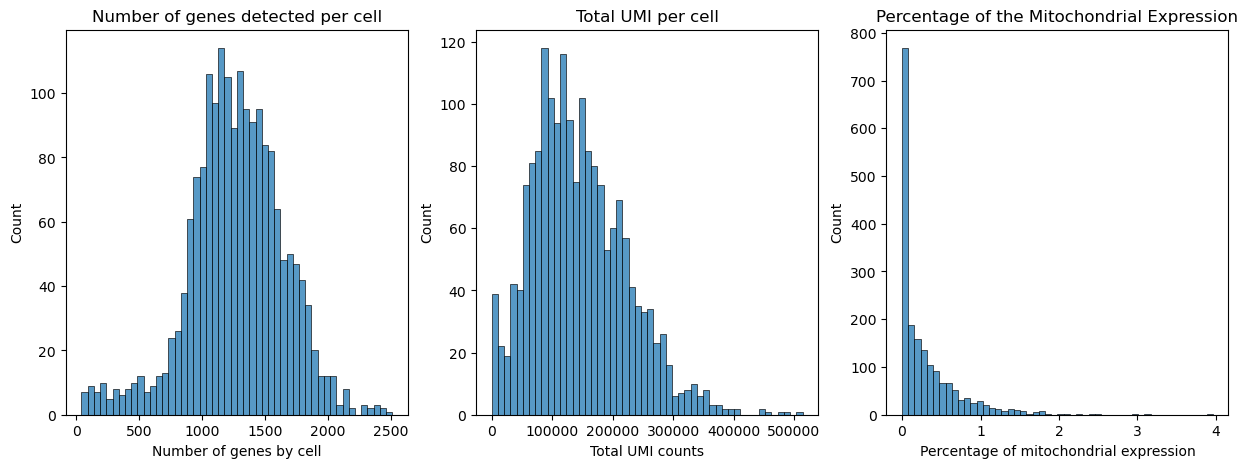

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(adata_glioblastoma_raw.obs["n_genes_by_cell"], bins=50, ax=axes[0])
axes[0].set_title("Number of genes detected per cell")
axes[0].set_xlabel("Number of genes by cell")
axes[0].set_ylabel("Count")

sns.histplot(adata_glioblastoma_raw.obs["total_UMI_counts"], bins=50, ax=axes[1])
axes[1].set_title("Total UMI per cell")
axes[1].set_xlabel("Total UMI counts")
axes[1].set_ylabel("Count")

sns.histplot(adata_glioblastoma_raw.obs["pct_mito"], bins=50, ax=axes[2])
axes[2].set_title("Percentage of the Mitochondrial Expression")
axes[2].set_xlabel("Percentage of mitochondrial expression")
axes[2].set_ylabel("Count")

plt.show()

### Filters

In [49]:
# Define filtering criteria
min_genes = 200    
max_genes = 5000   
min_UMI = 500      
max_mito = 10      

# Create a boolean mask for filtering
filtered_cells = (
    (adata_glioblastoma_raw.obs["n_genes_by_cell"] > min_genes) &
    (adata_glioblastoma_raw.obs["n_genes_by_cell"] < max_genes) &
    (adata_glioblastoma_raw.obs["total_UMI_counts"] > min_UMI) &
    (adata_glioblastoma_raw.obs["pct_mitocondrial"] < max_mito)
)


In [50]:
# Apply filtering
adata_glioblastoma_filtered = adata_glioblastoma_raw[filtered_cells].copy()

# Print the number of cells before and after filtering
print(f"Original number of cells: {adata_glioblastoma_raw.n_obs}")
print(f"Number of cells after filtering: {adata_glioblastoma_filtered.n_obs}")

Original number of cells: 1853
Number of cells after filtering: 1825


### Data Normalization

In [ ]:
# Normalize total UMI counts per cell and log-transform
sc.pp.normalize_total(adata_glioblastoma_filtered, target_sum=1e4)
sc.pp.log1p(adata_glioblastoma_filtered)

## Doublets and Singlets in Single-Cell RNA-Seq (scRNA-Seq)

In single-cell RNA sequencing (scRNA-Seq), the terms **"doublet"** and **"singlet"** refer to the nature of the captured cells in the experiment:

- **Singlet** → A single individual cell encapsulated in a droplet or captured in a well.
- **Doublet** → Two cells encapsulated together in the same droplet, which can lead to contaminated or mixed data in the analysis.

### 🔬 Why is it important to detect doublets?
Doublets can lead to **false interpretations** in the analysis, as they may appear to be a new cell type with a combined expression profile of two real cells. This affects:

- **Cell type identification** (they may seem like new cell types that do not actually exist).
- **Analysis of cellular subpopulations**.
- **Inference of cell relationships and trajectories**.


In [16]:
sc.pp.filter_genes(adata_test, min_cells = 10)

In [ ]:
%pip install scikit-misc

   ---------------------------------------- 0.0/10.0 MB ? eta -:--:--
   - -------------------------------------- 0.3/10.0 MB ? eta -:--:--
   --- ------------------------------------ 0.8/10.0 MB 2.8 MB/s eta 0:00:04
   ----- ---------------------------------- 1.3/10.0 MB 2.8 MB/s eta 0:00:04
   -------- ------------------------------- 2.1/10.0 MB 2.8 MB/s eta 0:00:03
   --------- ------------------------------ 2.4/10.0 MB 2.9 MB/s eta 0:00:03
   ------------ --------------------------- 3.1/10.0 MB 2.8 MB/s eta 0:00:03
   --------------- ------------------------ 3.9/10.0 MB 2.9 MB/s eta 0:00:03
   ---------------- ----------------------- 4.2/10.0 MB 3.0 MB/s eta 0:00:02
   ---------------------- ----------------- 5.5/10.0 MB 3.1 MB/s eta 0:00:02
   ------------------------ --------------- 6.0/10.0 MB 3.1 MB/s eta 0:00:02
   -------------------------- ------------- 6.6/10.0 MB 3.1 MB/s eta 0:00:02
   ----------------------------- ---------- 7.3/10.0 MB 3.0 MB/s eta 0:00:01
   ----------

In [20]:
sc.pp.highly_variable_genes(adata_test, n_top_genes=2000, subset=True, flavor="seurat_v3")